# Classify the type of risk for the stock price predicted by a CNN

In [30]:
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
import timeit
import warnings
warnings.filterwarnings('ignore')

## Load input data and build datasets to train, test and evaluate the CNN

In [131]:
samples = np.load('./data/x_samples.npy')
y = np.load('./data/y_labels.npy')
dates = np.load('./data/date_sequences.npy')

# convert to float32
samples = np.float32(samples)
y = np.float32(y)

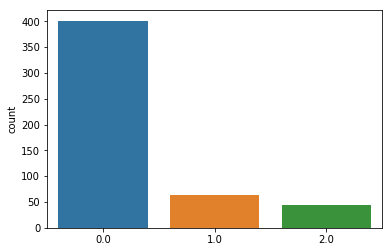

In [132]:
# Check if classes are unbalanced
_ = sns.countplot(y)

### Balance classes

In [133]:
# balancing parameters
n_samples = len(y)
classes = [0, 1, 2]
unbalanced_classes = [1, 2]
percentage_classes = pd.Series(y).value_counts(normalize=True).values.tolist()
n_values_classes = pd.Series(y).value_counts(normalize=False).values.tolist()
classes = pd.Series(y).value_counts(normalize=True).index.astype(int).tolist()
class_n_values = dict(zip(classes,n_values_classes))

# extract indices for each class in samples
index_0 = pd.Series(y)[pd.Series(y)==0].index.tolist()
index_1 = pd.Series(y)[pd.Series(y)==1].index.tolist()
index_2 = pd.Series(y)[pd.Series(y)==2].index.tolist()

# calculate number of repetitions in each class to balance data
repeat_1 = class_n_values[0] - class_n_values[1]
repeat_2 = class_n_values[0] - class_n_values[2]

# generate x and y repetitions to balance class 1
new_samples_1 = []
new_y_1 = []

counter = 0
while counter < repeat_1:
    idx = random.choice(index_1)
    new_s = samples[idx]
    new_y = y[idx]
    
    new_samples_1.append(new_s)
    new_y_1.append(new_y)
    
    counter += 1

# generate x and y repetitions to balance class 2
new_samples_2 = []
new_y_2 = []

counter = 0
while counter < repeat_2:
    idx = random.choice(index_2)
    new_s = samples[idx]
    new_y = y[idx]
    
    new_samples_2.append(new_s)
    new_y_2.append(new_y)
    
    counter += 1

In [136]:
# concatenate old and new samples
samples = np.append(arr=samples, values=np.array(new_samples_1), axis=0)
samples = np.append(arr=samples, values=np.array(new_samples_2), axis=0)

y = np.append(y, np.array(new_y_1))
y = np.append(y, np.array(new_y_2))

# randomize order of samples to correct distribution of classes in datasets
new_indices = pd.Series(y).index.tolist()
np.random.shuffle(new_indices)

random_samples = samples[[new_indices]]
random_y = y[[new_indices]]

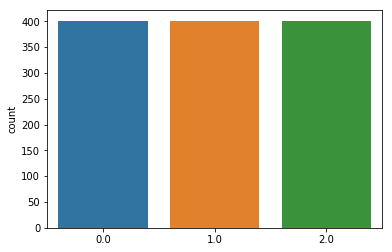

In [140]:
# Check if classes are unbalanced
_ = sns.countplot(random_y)

### Split between train, validation and test

In [141]:
def build_data_sets(samples, labels, dates, test_set_size_percentage, valid_set_size_percentage):
    
    # Calculate the amount of samples for each set
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * samples.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage / 100 * samples.shape[0]));
    train_set_size = samples.shape[0] - (valid_set_size + test_set_size);
    
    x_train = samples[:train_set_size]
    y_train = labels[:train_set_size]
    train_dates = dates[:train_set_size]
    
    x_valid = samples[train_set_size:train_set_size + valid_set_size]
    y_valid = labels[train_set_size:train_set_size + valid_set_size]
    valid_dates = dates[train_set_size:train_set_size + valid_set_size]
    
    x_test = samples[train_set_size+valid_set_size:]
    y_test = labels[train_set_size+valid_set_size:]
    test_dates = dates[train_set_size+valid_set_size:]
    
    return [x_train, y_train, train_dates, x_valid, y_valid, valid_dates, x_test, y_test, test_dates]

In [142]:
# Generate the data sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10

x_train, y_train, train_dates, x_valid, y_valid, valid_dates, x_test, y_test, test_dates = build_data_sets(\
                                                                                        random_samples, 
                                                                                        random_y, dates, 
                                                                                        test_set_size_percentage, 
                                                                                        valid_set_size_percentage)

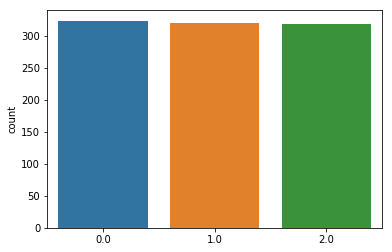

In [143]:
_ = sns.countplot(y_train)

In [144]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape,x_test.shape,y_test.shape)

(963, 32, 32, 3) (963,) (120, 32, 32, 3) (120,) (120, 32, 32, 3) (120,)


### Train a CNN

In [146]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN.
       Scheleton CNN copied from Tensorflow MNIST source code
       https://github.com/tensorflow/tensorflow/blob/r1.7/tensorflow/examples/tutorials/layers/cnn_mnist.py"""
    
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, decomposed_]
    # Time series from stock market input samples are 32x32 days (moved in a window size of 1 day), 
    # and have 3 decomposed values per day (trend, seasonality and residuals)
    input_layer = tf.reshape(features, [-1, 32, 32, 3])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 32, 32, 3]
    # Output Tensor Shape: [batch_size, 32, 32, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 32, 32, 32]
    # Output Tensor Shape: [batch_size, 16, 16, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 16, 16, 32]
    # Output Tensor Shape: [batch_size, 16, 16, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 16, 16, 64]
    # Output Tensor Shape: [batch_size, 8, 8, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 8, 8, 64]
    # Output Tensor Shape: [batch_size, 8 * 8 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 8 * 8 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 3]
    logits = tf.layers.dense(inputs=dropout, units=3)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "recall": tf.metrics.recall(
            labels=labels, predictions=predictions["classes"])}

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [147]:
# Load training and eval data
train_data = np.asarray(x_train, dtype=np.float32)  # Returns np.array
train_labels = np.asarray(y_train, dtype=np.int32)
eval_data = np.asarray(x_valid, dtype=np.float32)  # Returns np.array
eval_labels = np.asarray(y_valid, dtype=np.int32)

# to optimize
batch_sizes = [10, 20, 50]
n_iterations = [10, 20, 50]
n_steps = [1000, 5000, 10000]

In [ ]:
results = []

for batch_size in batch_sizes:
    for n_iteration in n_iterations:
        for n_step in n_steps:
            
            result = {}
            start = timeit.default_timer()
            
            # Create the Estimator
            time_series_classifier = tf.estimator.Estimator(
                model_fn=cnn_model_fn, model_dir="./data/cnn_models")

            # Set up logging for predictions
            # Log the values in the "Softmax" tensor with label "probabilities"
            tensors_to_time_series_classifierlog = {"probabilities": "softmax_tensor"}
            logging_hook = tf.train.LoggingTensorHook(
                tensors=tensors_to_time_series_classifierlog, every_n_iter=n_iteration)

            # Train the model
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x=train_data,
                y=train_labels,
                batch_size=batch_size,
                num_epochs=None,
                shuffle=True)

            time_series_classifier.train(
                input_fn=train_input_fn,
                steps=n_step,
                hooks=[logging_hook])

            # Evaluate the model and print results
            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x=eval_data,
                y=eval_labels,
                num_epochs=1,
                shuffle=False)
            eval_results = time_series_classifier.evaluate(input_fn=eval_input_fn)
            
            stop = timeit.default_timer()
            time = stop - start 
            
            result['eval_results'] = eval_results
            result['batch_sizes'] = batch_size
            result['n_iterations'] = n_iteration
            result['n_steps'] = n_step
            result['time (s)'] = time
            print(eval_results)
            
            results.append(result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './data/cnn_models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x126dc6b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./data/cnn_models/model.ckpt.
INFO:tensorflow:probabilities = [[0.21914098 0.52440286 

INFO:tensorflow:probabilities = [[0.34302136 0.30246583 0.3545128 ]
 [0.5123222  0.31170657 0.17597117]
 [0.30651605 0.3802167  0.31326732]
 [0.33701608 0.3390833  0.32390058]
 [0.3831252  0.323808   0.29306677]
 [0.417079   0.2918838  0.29103714]
 [0.29535496 0.26398394 0.4406611 ]
 [0.4170233  0.30744812 0.27552855]
 [0.34985402 0.29590684 0.3542392 ]
 [0.49380207 0.24730615 0.25889173]] (0.802 sec)
INFO:tensorflow:probabilities = [[0.3121309  0.27962062 0.40824842]
 [0.29026943 0.32145768 0.3882729 ]
 [0.4194935  0.23991542 0.3405911 ]
 [0.44287768 0.3299219  0.2272004 ]
 [0.3763373  0.29479542 0.3288673 ]
 [0.32215127 0.25848076 0.41936797]
 [0.36922693 0.28759176 0.34318122]
 [0.26168504 0.25485826 0.4834567 ]
 [0.18806328 0.18651873 0.62541795]
 [0.26360267 0.353922   0.38247532]] (0.907 sec)
INFO:tensorflow:global_step/sec: 12.1836
INFO:tensorflow:probabilities = [[0.36040512 0.29125988 0.34833503]
 [0.3499834  0.31786063 0.332156  ]
 [0.295417   0.46176457 0.24281852]
 [0.26153

INFO:tensorflow:probabilities = [[0.2957459  0.3180254  0.38622868]
 [0.33754414 0.3357603  0.32669556]
 [0.3060528  0.3379679  0.35597932]
 [0.4192639  0.2454038  0.33533227]
 [0.32061085 0.35582584 0.32356328]
 [0.34557799 0.35067517 0.3037469 ]
 [0.30792832 0.2993849  0.3926868 ]
 [0.4392682  0.31597114 0.24476069]
 [0.3524105  0.38110906 0.26648048]
 [0.45096594 0.29562318 0.25341088]] (0.738 sec)
INFO:tensorflow:probabilities = [[0.36233556 0.318514   0.3191505 ]
 [0.3213421  0.44468278 0.23397508]
 [0.3569709  0.33662274 0.30640635]
 [0.28317082 0.4449471  0.27188212]
 [0.23599742 0.3068528  0.45714977]
 [0.24456263 0.40187505 0.3535623 ]
 [0.30121407 0.29809535 0.4006906 ]
 [0.34047157 0.35422817 0.30530033]
 [0.3601215  0.29458472 0.34529382]
 [0.29863003 0.36866352 0.33270654]] (0.762 sec)
INFO:tensorflow:global_step/sec: 12.6117
INFO:tensorflow:probabilities = [[0.28178442 0.28506333 0.43315232]
 [0.33631822 0.3273268  0.33635503]
 [0.43203723 0.2209002  0.34706256]
 [0.26067

INFO:tensorflow:probabilities = [[0.28695494 0.35308796 0.35995707]
 [0.27737424 0.2863421  0.4362836 ]
 [0.34714457 0.34532335 0.30753204]
 [0.3335529  0.3466607  0.31978643]
 [0.23781171 0.35866526 0.4035231 ]
 [0.24347995 0.3343037  0.4222163 ]
 [0.26325905 0.38024104 0.3564999 ]
 [0.30854785 0.36411536 0.32733685]
 [0.26136494 0.3233008  0.4153342 ]
 [0.2459741  0.2866201  0.46740577]] (0.820 sec)
INFO:tensorflow:probabilities = [[0.24569051 0.3539126  0.40039688]
 [0.26932502 0.3557446  0.37493035]
 [0.39932045 0.39525166 0.20542787]
 [0.31106722 0.38510782 0.30382496]
 [0.44340453 0.31056228 0.24603322]
 [0.3860242  0.4359304  0.17804538]
 [0.24263115 0.38260707 0.37476173]
 [0.22153325 0.40657502 0.37189174]
 [0.26469296 0.3815072  0.3537999 ]
 [0.47440067 0.32236892 0.20323043]] (0.835 sec)
INFO:tensorflow:global_step/sec: 12.8879
INFO:tensorflow:probabilities = [[0.25844598 0.31752342 0.42403057]
 [0.2918266  0.3694972  0.33867615]
 [0.45288175 0.37183666 0.17528155]
 [0.25536

INFO:tensorflow:probabilities = [[0.43001592 0.35311827 0.21686576]
 [0.27748787 0.32616    0.3963521 ]
 [0.2806806  0.34465563 0.37466377]
 [0.24487543 0.31219175 0.4429328 ]
 [0.4077621  0.38291022 0.20932762]
 [0.42597985 0.35032195 0.22369821]
 [0.34972742 0.3233273  0.32694533]
 [0.29402134 0.32033983 0.3856388 ]
 [0.32208708 0.35856217 0.31935075]
 [0.3869679  0.27998257 0.3330496 ]] (0.768 sec)
INFO:tensorflow:probabilities = [[0.28501156 0.33922508 0.37576333]
 [0.38087147 0.3787861  0.24034247]
 [0.27150294 0.28365633 0.44484076]
 [0.25760037 0.35338446 0.38901517]
 [0.38832626 0.39422217 0.21745148]
 [0.2051547  0.3061485  0.4886968 ]
 [0.22350986 0.33863083 0.43785933]
 [0.27785712 0.3171785  0.40496442]
 [0.26860684 0.407468   0.32392514]
 [0.28372613 0.34855348 0.36772043]] (0.790 sec)
INFO:tensorflow:global_step/sec: 12.9309
INFO:tensorflow:probabilities = [[0.3222936  0.27426097 0.40344542]
 [0.35804847 0.3028003  0.3391512 ]
 [0.44283333 0.3526137  0.2045529 ]
 [0.35906

INFO:tensorflow:probabilities = [[0.30059844 0.31644377 0.38295785]
 [0.41714734 0.34427446 0.23857819]
 [0.272801   0.35474774 0.37245122]
 [0.3306436  0.3092131  0.3601434 ]
 [0.4319322  0.33563522 0.2324326 ]
 [0.35871926 0.45054808 0.19073263]
 [0.26978222 0.32861665 0.40160108]
 [0.40586296 0.2767028  0.31743425]
 [0.25832576 0.30558828 0.43608597]
 [0.39428946 0.35472846 0.250982  ]] (0.768 sec)
INFO:tensorflow:probabilities = [[0.2509728  0.3358042  0.41322297]
 [0.4680201  0.3400664  0.19191352]
 [0.2621002  0.30189872 0.43600115]
 [0.27268323 0.30587724 0.42143956]
 [0.45992827 0.33270663 0.20736513]
 [0.4430311  0.4024778  0.1544911 ]
 [0.32713473 0.28632668 0.3865386 ]
 [0.32772806 0.24945517 0.42281675]
 [0.4111935  0.30873504 0.2800715 ]
 [0.31239688 0.3408588  0.3467443 ]] (0.763 sec)
INFO:tensorflow:Saving checkpoints for 1000 into ./data/cnn_models/model.ckpt.
INFO:tensorflow:Loss for final step: 1.1045735.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling 

INFO:tensorflow:probabilities = [[0.30290756 0.3340556  0.36303687]
 [0.27462393 0.34094286 0.3844332 ]
 [0.47338578 0.3276669  0.1989474 ]
 [0.26242486 0.3478987  0.38967642]
 [0.47067901 0.29284602 0.2364749 ]
 [0.4829806  0.30945545 0.207564  ]
 [0.27915236 0.35078564 0.37006205]
 [0.3238599  0.31264043 0.36349964]
 [0.288196   0.32674918 0.38505483]
 [0.35319728 0.27223358 0.37456915]] (0.783 sec)
INFO:tensorflow:probabilities = [[0.30832264 0.30545524 0.38622215]
 [0.26764387 0.36275226 0.36960387]
 [0.37450826 0.29663506 0.3288567 ]
 [0.28411692 0.2852411  0.43064195]
 [0.30233294 0.31803077 0.37963632]
 [0.31413534 0.3318669  0.35399774]
 [0.51483613 0.27402398 0.21113996]
 [0.35269192 0.26309612 0.384212  ]
 [0.26354352 0.31679386 0.41966265]
 [0.24519849 0.32135236 0.43344915]] (0.786 sec)
INFO:tensorflow:probabilities = [[0.32767916 0.3136466  0.35867426]
 [0.5479378  0.3262916  0.12577061]
 [0.3246311  0.3002904  0.37507853]
 [0.39708993 0.30829376 0.2946163 ]
 [0.54830235 0

INFO:tensorflow:probabilities = [[0.2832638  0.3311321  0.38560408]
 [0.31969982 0.40533596 0.27496418]
 [0.32354975 0.37890953 0.2975408 ]
 [0.45527256 0.31595397 0.22877353]
 [0.44446906 0.40939796 0.14613292]
 [0.43335927 0.3970519  0.16958888]
 [0.32758343 0.33749837 0.33491814]
 [0.42345217 0.412905   0.16364281]
 [0.23460402 0.35904732 0.40634865]
 [0.39259985 0.4775195  0.12988073]] (0.851 sec)
INFO:tensorflow:probabilities = [[0.29591963 0.3941751  0.3099052 ]
 [0.278534   0.3067907  0.41467524]
 [0.42016885 0.36877984 0.21105133]
 [0.26018074 0.35243008 0.38738912]
 [0.26281634 0.32622486 0.41095874]
 [0.2827678  0.3458166  0.37141564]
 [0.25397292 0.31045464 0.43557236]
 [0.26489052 0.32763246 0.40747702]
 [0.29012436 0.32482222 0.38505346]
 [0.3875908  0.37209427 0.24031496]] (0.854 sec)
INFO:tensorflow:probabilities = [[0.2528943  0.3287585  0.41834712]
 [0.2636416  0.33503097 0.40132743]
 [0.29893056 0.32142368 0.37964574]
 [0.5017963  0.320351   0.17785275]
 [0.2524374  0

INFO:tensorflow:probabilities = [[0.27317727 0.30303052 0.42379218]
 [0.2918695  0.34200317 0.3661273 ]
 [0.41859525 0.39954302 0.18186174]
 [0.30142778 0.35801    0.34056228]
 [0.49177733 0.35401157 0.15421112]
 [0.4003286  0.43019712 0.16947433]
 [0.466839   0.32969028 0.20347074]
 [0.2785112  0.3203524  0.40113637]
 [0.49230272 0.35393435 0.15376286]
 [0.23963082 0.33952993 0.42083925]] (0.790 sec)
INFO:tensorflow:probabilities = [[0.37624153 0.3714417  0.2523168 ]
 [0.26031932 0.33848017 0.40120044]
 [0.26472083 0.32392848 0.41135064]
 [0.32582855 0.33927396 0.33489746]
 [0.28883544 0.32564935 0.38551524]
 [0.42886013 0.36305523 0.20808464]
 [0.25053024 0.32932344 0.42014632]
 [0.22193551 0.28406188 0.4940026 ]
 [0.23832992 0.34690097 0.41476905]
 [0.24368297 0.32701847 0.42929852]] (0.776 sec)
INFO:tensorflow:probabilities = [[0.43813038 0.37421232 0.18765736]
 [0.27513427 0.3202409  0.40462485]
 [0.4304377  0.31348792 0.25607437]
 [0.24752556 0.34929043 0.40318403]
 [0.33243972 0

INFO:tensorflow:probabilities = [[0.4349907  0.34321123 0.22179809]
 [0.2942025  0.3306803  0.37511718]
 [0.27311155 0.2714493  0.45543915]
 [0.25988686 0.28934434 0.45076883]
 [0.32836702 0.32734698 0.34428605]
 [0.4962819  0.28746295 0.21625523]
 [0.3453033  0.29746464 0.35723206]
 [0.27471557 0.27923372 0.4460507 ]
 [0.25563368 0.30652028 0.43784606]
 [0.32697883 0.26104727 0.41197392]] (0.775 sec)
INFO:tensorflow:probabilities = [[0.49548998 0.33582804 0.16868192]
 [0.30537894 0.3216779  0.3729432 ]
 [0.34130177 0.3493294  0.3093688 ]
 [0.27505985 0.3228428  0.4020973 ]
 [0.25022286 0.32499763 0.42477956]
 [0.45332667 0.32357332 0.22309998]
 [0.31557816 0.30278027 0.38164163]
 [0.44295523 0.3428235  0.21422134]
 [0.2620957  0.32643437 0.41146994]
 [0.2738195  0.32607803 0.4001025 ]] (0.769 sec)
INFO:tensorflow:probabilities = [[0.25739264 0.33007753 0.41252986]
 [0.2678833  0.34857595 0.3835408 ]
 [0.451683   0.37568462 0.17263237]
 [0.23652972 0.32722244 0.43624786]
 [0.2864747  0

INFO:tensorflow:probabilities = [[0.35945663 0.2839169  0.35662648]
 [0.5425879  0.3494986  0.10791355]
 [0.30921212 0.26840582 0.422382  ]
 [0.29823264 0.30140474 0.40036258]
 [0.4409773  0.28323612 0.27578664]
 [0.4236663  0.36558133 0.21075234]
 [0.3180077  0.31576625 0.36622596]
 [0.29692912 0.2959788  0.4070921 ]
 [0.3978883  0.29231423 0.30979756]
 [0.4424951  0.3231215  0.23438342]] (0.815 sec)
INFO:tensorflow:probabilities = [[0.3354392  0.28290662 0.3816542 ]
 [0.44424823 0.35233846 0.20341331]
 [0.24386    0.28999606 0.4661439 ]
 [0.23495887 0.3022197  0.46282148]
 [0.32872915 0.2988143  0.37245652]
 [0.23345834 0.30960017 0.45694152]
 [0.44599342 0.24567938 0.3083273 ]
 [0.4489755  0.41563934 0.13538511]
 [0.41271478 0.29129782 0.29598734]
 [0.2534207  0.30341402 0.44316527]] (0.811 sec)
INFO:tensorflow:probabilities = [[0.32293984 0.31804487 0.35901532]
 [0.4001283  0.28498018 0.31489158]
 [0.32692584 0.3356806  0.33739355]
 [0.38851407 0.39801937 0.2134665 ]
 [0.43444163 0

INFO:tensorflow:probabilities = [[0.2828137  0.31302056 0.40416571]
 [0.48359326 0.35962352 0.1567832 ]
 [0.24005994 0.36632472 0.39361534]
 [0.49009952 0.3554738  0.15442666]
 [0.2867179  0.32746145 0.38582063]
 [0.26284903 0.33772632 0.3994246 ]
 [0.31657472 0.31890664 0.36451873]
 [0.3026278  0.29641825 0.40095392]
 [0.29027948 0.3026261  0.40709442]
 [0.5015122  0.27167553 0.22681227]] (0.715 sec)
INFO:tensorflow:probabilities = [[0.2413093  0.35915735 0.39953336]
 [0.5120591  0.2893791  0.19856177]
 [0.41584688 0.2973968  0.28675625]
 [0.30657107 0.2994506  0.3939783 ]
 [0.26696596 0.29861295 0.43442106]
 [0.23353449 0.31021598 0.4562495 ]
 [0.21870115 0.35743913 0.42385975]
 [0.50578225 0.27967668 0.21454102]
 [0.27871528 0.30281076 0.41847402]
 [0.4810659  0.27768812 0.24124601]] (0.721 sec)
INFO:tensorflow:probabilities = [[0.46523413 0.2863537  0.24841213]
 [0.3050108  0.3173238  0.37766543]
 [0.24588275 0.34246516 0.41165215]
 [0.519122   0.27164498 0.20923297]
 [0.2572262  0

INFO:tensorflow:probabilities = [[0.27702102 0.35315517 0.36982384]
 [0.35250896 0.3451043  0.30238676]
 [0.25190398 0.30214176 0.4459543 ]
 [0.3920746  0.30674145 0.30118394]
 [0.5473473  0.29271933 0.15993339]
 [0.30525798 0.32203242 0.37270957]
 [0.28407994 0.33765593 0.3782641 ]
 [0.34368196 0.26555952 0.39075848]
 [0.48422185 0.3684711  0.14730705]
 [0.30515066 0.29187316 0.40297624]] (0.712 sec)
INFO:tensorflow:probabilities = [[0.26736313 0.33517703 0.39745986]
 [0.2958935  0.318485   0.3856215 ]
 [0.3256488  0.33236945 0.3419818 ]
 [0.4392646  0.406596   0.15413941]
 [0.3151336  0.31960118 0.36526522]
 [0.32742822 0.3175743  0.35499752]
 [0.47733626 0.3679701  0.15469363]
 [0.3913557  0.28211617 0.32652816]
 [0.43276653 0.3745294  0.19270404]
 [0.35818422 0.3389061  0.30290964]] (0.654 sec)
INFO:tensorflow:probabilities = [[0.26089305 0.334986   0.404121  ]
 [0.2968212  0.31282055 0.39035824]
 [0.32230532 0.3282574  0.3494372 ]
 [0.32748058 0.2813552  0.39116418]
 [0.34347755 0

INFO:tensorflow:probabilities = [[0.25759175 0.24930353 0.49310467]
 [0.26555753 0.3020991  0.43234333]
 [0.29776666 0.2768345  0.4253989 ]
 [0.29653075 0.294957   0.4085122 ]
 [0.4777598  0.33666784 0.18557239]
 [0.30534068 0.28560334 0.40905592]
 [0.26966068 0.30589783 0.42444143]
 [0.29890376 0.29147625 0.40961996]
 [0.2350563  0.2980826  0.4668611 ]
 [0.27753627 0.30132616 0.4211376 ]] (0.691 sec)
INFO:tensorflow:probabilities = [[0.46765018 0.40572992 0.12661989]
 [0.29389718 0.3125533  0.39354953]
 [0.525411   0.32543007 0.14915888]
 [0.42690453 0.35112876 0.22196676]
 [0.22068512 0.32028243 0.4590325 ]
 [0.27159262 0.31952038 0.408887  ]
 [0.28631416 0.34656242 0.3671234 ]
 [0.27615058 0.3439747  0.37987465]
 [0.287095   0.30048454 0.41242045]
 [0.48293304 0.3409252  0.17614171]] (0.780 sec)
INFO:tensorflow:probabilities = [[0.4652509  0.38654447 0.14820464]
 [0.37987706 0.44812223 0.17200068]
 [0.34303102 0.3677167  0.28925222]
 [0.37944385 0.4671726  0.15338355]
 [0.29473004 0

INFO:tensorflow:probabilities = [[0.31332862 0.34122306 0.34544823]
 [0.28892085 0.32642356 0.3846556 ]
 [0.39066407 0.4139315  0.19540444]
 [0.5242477  0.35369313 0.12205914]
 [0.3820161  0.43069896 0.18728495]
 [0.23043013 0.35505924 0.4145106 ]
 [0.46611956 0.40022632 0.13365418]
 [0.40163645 0.36322457 0.235139  ]
 [0.35740668 0.31191716 0.33067614]
 [0.2930468  0.31987152 0.3870817 ]] (0.709 sec)
INFO:tensorflow:probabilities = [[0.5230505  0.32786733 0.14908217]
 [0.23560359 0.30662835 0.45776805]
 [0.22168256 0.37716952 0.40114793]
 [0.21923506 0.37380004 0.4069649 ]
 [0.4224537  0.4264247  0.15112168]
 [0.22988875 0.35298944 0.4171219 ]
 [0.21618538 0.2841213  0.49969333]
 [0.20452796 0.337841   0.45763102]
 [0.24963157 0.3395529  0.4108155 ]
 [0.21209434 0.3327062  0.45519942]] (0.694 sec)
INFO:tensorflow:probabilities = [[0.5004537  0.3114972  0.18804902]
 [0.24691479 0.31939828 0.4336869 ]
 [0.2924201  0.31721842 0.39036152]
 [0.49024102 0.2992385  0.21052046]
 [0.25018418 0

INFO:tensorflow:probabilities = [[0.25425985 0.30858764 0.43715256]
 [0.39855906 0.30443597 0.29700494]
 [0.5151185  0.31070638 0.17417517]
 [0.26120803 0.30204767 0.4367443 ]
 [0.39841497 0.31960693 0.28197816]
 [0.463761   0.3847143  0.15152477]
 [0.50478923 0.35610068 0.13911004]
 [0.29824924 0.286391   0.41535974]
 [0.4291145  0.28823715 0.2826484 ]
 [0.5294382  0.3116214  0.15894037]] (0.704 sec)
INFO:tensorflow:probabilities = [[0.43452695 0.42540577 0.14006731]
 [0.45906627 0.33723143 0.20370232]
 [0.3088392  0.3239233  0.3672375 ]
 [0.25535437 0.3225798  0.42206576]
 [0.5055888  0.34166867 0.15274248]
 [0.28466868 0.2861727  0.42915866]
 [0.3253903  0.30935505 0.36525464]
 [0.43736297 0.2955697  0.26706728]
 [0.58968186 0.2510174  0.15930079]
 [0.28723785 0.30862904 0.4041331 ]] (0.708 sec)
INFO:tensorflow:probabilities = [[0.26786673 0.28951597 0.44261727]
 [0.2892473  0.27574056 0.4350121 ]
 [0.43658796 0.36074185 0.20267016]
 [0.49689874 0.31944093 0.18366034]
 [0.27546924 0

INFO:tensorflow:probabilities = [[0.33119833 0.3127896  0.35601205]
 [0.25044733 0.33162308 0.41792953]
 [0.27994835 0.31156194 0.4084897 ]
 [0.26870078 0.34092584 0.39037338]
 [0.42657077 0.3590128  0.2144164 ]
 [0.27159083 0.30659243 0.42181674]
 [0.32390854 0.28114015 0.39495128]
 [0.3795349  0.29888555 0.32157955]
 [0.2669415  0.30124843 0.43181014]
 [0.4445021  0.37788948 0.17760848]] (0.703 sec)
INFO:tensorflow:probabilities = [[0.28376412 0.37797433 0.33826154]
 [0.43682978 0.38422722 0.178943  ]
 [0.4645263  0.34650567 0.18896803]
 [0.24997143 0.3083762  0.4416523 ]
 [0.29530463 0.31694695 0.38774848]
 [0.4063084  0.30650613 0.2871854 ]
 [0.2622043  0.33929315 0.39850265]
 [0.46560052 0.32789516 0.20650437]
 [0.45232263 0.3808688  0.16680853]
 [0.26175207 0.33688664 0.4013613 ]] (0.697 sec)
INFO:tensorflow:probabilities = [[0.25223893 0.30033386 0.44742727]
 [0.27989033 0.29907852 0.42103112]
 [0.28230563 0.31009716 0.4075972 ]
 [0.23379627 0.31763604 0.44856766]
 [0.4017766  0

INFO:tensorflow:probabilities = [[0.30247074 0.32263353 0.37489575]
 [0.39258027 0.3375996  0.26982012]
 [0.37200695 0.3149282  0.31306478]
 [0.33325115 0.30035383 0.36639503]
 [0.36750257 0.3284917  0.30400568]
 [0.48998374 0.35607806 0.15393816]
 [0.42589012 0.42642027 0.14768958]
 [0.34621516 0.28748098 0.36630392]
 [0.41950783 0.30672824 0.27376398]
 [0.4164652  0.44314796 0.1403869 ]] (0.709 sec)
INFO:tensorflow:probabilities = [[0.48580468 0.30411983 0.21007544]
 [0.44278252 0.35929567 0.19792183]
 [0.2942312  0.30228257 0.40348625]
 [0.37545547 0.30368242 0.3208621 ]
 [0.31135234 0.32054663 0.368101  ]
 [0.4500074  0.29855165 0.25144094]
 [0.3368896  0.3102265  0.35288396]
 [0.2982536  0.31183997 0.38990644]
 [0.39962772 0.30781865 0.2925536 ]
 [0.39533645 0.2869806  0.3176829 ]] (0.698 sec)
INFO:tensorflow:probabilities = [[0.28338358 0.31522095 0.4013955 ]
 [0.39253712 0.2904493  0.31701356]
 [0.26566723 0.29097852 0.44335428]
 [0.2758064  0.31128335 0.41291022]
 [0.43861407 0

INFO:tensorflow:probabilities = [[0.38770425 0.34565985 0.26663584]
 [0.315253   0.32412255 0.3606245 ]
 [0.42708606 0.3718756  0.20103838]
 [0.41009632 0.37148082 0.21842285]
 [0.47757295 0.3495253  0.17290181]
 [0.29597536 0.37392682 0.3300978 ]
 [0.26820195 0.3563787  0.37541935]
 [0.288694   0.34754393 0.36376214]
 [0.46790087 0.3946331  0.13746609]
 [0.26319477 0.34201264 0.39479262]] (0.732 sec)
INFO:tensorflow:probabilities = [[0.24043047 0.31057402 0.4489955 ]
 [0.28725544 0.3152673  0.39747727]
 [0.34525493 0.3070484  0.34769675]
 [0.5107314  0.31002575 0.17924286]
 [0.26564634 0.33707365 0.39728004]
 [0.23816068 0.32201815 0.43982112]
 [0.47695744 0.33676448 0.18627805]
 [0.28305566 0.31391555 0.40302882]
 [0.2430299  0.34876585 0.4082042 ]
 [0.24105325 0.26340473 0.495542  ]] (0.710 sec)
INFO:tensorflow:probabilities = [[0.48753268 0.32508135 0.187386  ]
 [0.23540686 0.33187202 0.43272114]
 [0.21321294 0.31586263 0.47092444]
 [0.2553908  0.3322748  0.41233438]
 [0.296888   0

INFO:tensorflow:probabilities = [[0.27929983 0.32246265 0.39823756]
 [0.28059727 0.30750597 0.4118968 ]
 [0.47896668 0.33299524 0.1880381 ]
 [0.41538823 0.33851883 0.24609295]
 [0.24847327 0.31520623 0.43632048]
 [0.2525035  0.28366843 0.46382806]
 [0.44349    0.39001358 0.16649647]
 [0.24011749 0.31428608 0.4455964 ]
 [0.2551611  0.29047585 0.45436305]
 [0.35995573 0.32314867 0.31689557]] (0.706 sec)
INFO:tensorflow:probabilities = [[0.3102806  0.31306672 0.3766527 ]
 [0.24662153 0.34085163 0.41252676]
 [0.28635535 0.3174669  0.39617774]
 [0.45888877 0.3185494  0.22256179]
 [0.5318627  0.28746146 0.1806759 ]
 [0.27334902 0.34314123 0.38350976]
 [0.25774992 0.29910117 0.44314888]
 [0.41780132 0.39606512 0.18613362]
 [0.28906527 0.3338198  0.37711492]
 [0.4375404  0.3529381  0.20952149]] (0.718 sec)
INFO:tensorflow:probabilities = [[0.2901855  0.29762197 0.4121925 ]
 [0.27680862 0.29989612 0.42329526]
 [0.26206908 0.3014048  0.43652612]
 [0.33705097 0.30784404 0.355105  ]
 [0.26402614 0

INFO:tensorflow:probabilities = [[0.28453088 0.28842825 0.4270409 ]
 [0.37234843 0.2990037  0.32864788]
 [0.459316   0.34739566 0.1932884 ]
 [0.31128934 0.29727244 0.3914382 ]
 [0.29981396 0.2503655  0.44982055]
 [0.24451317 0.27927256 0.47621423]
 [0.51068413 0.27549013 0.21382575]
 [0.5042388  0.27603963 0.21972156]
 [0.31795532 0.25070986 0.43133482]
 [0.27097607 0.25061122 0.47841272]] (0.714 sec)
INFO:tensorflow:probabilities = [[0.26614052 0.30798462 0.42587486]
 [0.34182307 0.28843    0.36974698]
 [0.2609317  0.28745937 0.4516089 ]
 [0.44373932 0.31278715 0.24347346]
 [0.48601702 0.37476832 0.13921465]
 [0.47406867 0.3555963  0.17033513]
 [0.317166   0.2986165  0.38421756]
 [0.51179373 0.3353535  0.15285276]
 [0.48013613 0.34142262 0.17844121]
 [0.2796648  0.3069412  0.41339403]] (0.723 sec)
INFO:tensorflow:probabilities = [[0.2714588  0.32200548 0.40653574]
 [0.2791688  0.33178407 0.38904706]
 [0.272202   0.3221234  0.40567458]
 [0.54137564 0.32679215 0.13183224]
 [0.5524161  0

INFO:tensorflow:probabilities = [[0.41064546 0.40030095 0.18905357]
 [0.26818407 0.3441697  0.3876463 ]
 [0.2605435  0.3336931  0.40576345]
 [0.3783905  0.41936916 0.20224027]
 [0.32632768 0.32537842 0.34829384]
 [0.43835592 0.35773784 0.20390625]
 [0.25413236 0.355129   0.39073867]
 [0.38700327 0.33396125 0.27903542]
 [0.27168125 0.35273752 0.3755813 ]
 [0.4598306  0.36424792 0.17592146]] (0.709 sec)
INFO:tensorflow:probabilities = [[0.33103538 0.298238   0.37072664]
 [0.26136366 0.29711694 0.44151935]
 [0.25589022 0.3188047  0.42530507]
 [0.23725158 0.27021417 0.4925343 ]
 [0.2841239  0.26478115 0.45109493]
 [0.31548798 0.28157824 0.40293378]
 [0.26753274 0.2912956  0.44117165]
 [0.23990856 0.29333833 0.4667531 ]
 [0.42879117 0.23706436 0.33414453]
 [0.23910323 0.3076064  0.4532903 ]] (0.694 sec)
INFO:tensorflow:probabilities = [[0.26570323 0.32740942 0.40688735]
 [0.45847785 0.30216074 0.2393614 ]
 [0.32885534 0.294996   0.37614864]
 [0.25189963 0.28570113 0.46239927]
 [0.3564216  0

INFO:tensorflow:probabilities = [[0.4882913  0.36651692 0.14519183]
 [0.25255242 0.33553952 0.41190806]
 [0.4600698  0.35634392 0.18358633]
 [0.2668919  0.33974537 0.39336273]
 [0.39446968 0.46112683 0.14440349]
 [0.40290686 0.38856924 0.2085239 ]
 [0.4887237  0.39220083 0.11907551]
 [0.28299192 0.28047124 0.43653685]
 [0.27224743 0.31961495 0.40813756]
 [0.24348648 0.3029128  0.4536008 ]] (0.709 sec)
INFO:tensorflow:probabilities = [[0.48008195 0.38956672 0.13035132]
 [0.4232293  0.39857426 0.17819646]
 [0.27333602 0.32966307 0.3970009 ]
 [0.32667398 0.34975997 0.32356602]
 [0.24087913 0.35756236 0.40155852]
 [0.2683803  0.33596054 0.39565915]
 [0.34573466 0.33523092 0.31903452]
 [0.52244675 0.32004747 0.15750575]
 [0.47362146 0.41079143 0.11558707]
 [0.27862433 0.35235596 0.36901972]] (0.700 sec)
INFO:tensorflow:probabilities = [[0.3984549  0.44542122 0.1561239 ]
 [0.4109492  0.39945546 0.18959533]
 [0.26691374 0.36937222 0.36371404]
 [0.2772751  0.3356967  0.38702825]
 [0.34763625 0

INFO:tensorflow:probabilities = [[0.23141453 0.30736855 0.461217  ]
 [0.2601669  0.32413653 0.41569662]
 [0.2109789  0.33403954 0.45498157]
 [0.2522075  0.29357886 0.45421368]
 [0.24365193 0.31309003 0.44325805]
 [0.2372503  0.29879367 0.4639561 ]
 [0.3693501  0.29943085 0.33121905]
 [0.2738841  0.31610507 0.4100108 ]
 [0.2805915  0.3200874  0.3993211 ]
 [0.20999697 0.3549472  0.43505582]] (0.703 sec)
INFO:tensorflow:probabilities = [[0.29195675 0.29283604 0.41520715]
 [0.4956257  0.3306127  0.17376164]
 [0.22722594 0.31821308 0.45456102]
 [0.43635905 0.3720048  0.19163617]
 [0.528176   0.27370244 0.19812152]
 [0.2848949  0.32062873 0.39447638]
 [0.40789098 0.27813047 0.3139786 ]
 [0.33700985 0.29407176 0.3689184 ]
 [0.28613606 0.32205015 0.39181384]
 [0.4667024  0.28862715 0.24467047]] (0.710 sec)
INFO:tensorflow:probabilities = [[0.25579938 0.38621715 0.35798347]
 [0.49371865 0.32006264 0.18621865]
 [0.29421178 0.37310913 0.3326791 ]
 [0.5013642  0.38624838 0.11238748]
 [0.4442178  0

INFO:tensorflow:probabilities = [[0.51214415 0.35087743 0.13697834]
 [0.25015512 0.30810696 0.4417379 ]
 [0.2893504  0.31324306 0.39740658]
 [0.29374346 0.31841445 0.38784206]
 [0.2638084  0.30748218 0.4287094 ]
 [0.23687458 0.30673102 0.45639443]
 [0.5029363  0.35113284 0.14593089]
 [0.29162732 0.3658708  0.34250197]
 [0.27549613 0.31806573 0.4064381 ]
 [0.27370343 0.32801193 0.39828467]] (0.707 sec)
INFO:tensorflow:probabilities = [[0.4835242  0.29869354 0.21778226]
 [0.3046472  0.3191833  0.37616947]
 [0.35206944 0.34220865 0.3057219 ]
 [0.28958702 0.3206872  0.38972574]
 [0.2581823  0.3261827  0.415635  ]
 [0.291568   0.35522577 0.35320628]
 [0.54489094 0.33863905 0.11646999]
 [0.4490053  0.3030631  0.24793158]
 [0.47044224 0.36807647 0.16148132]
 [0.30423278 0.3255303  0.3702369 ]] (0.694 sec)
INFO:tensorflow:probabilities = [[0.2565715  0.32270527 0.42072323]
 [0.5232239  0.343594   0.13318205]
 [0.29573685 0.35068944 0.35357368]
 [0.35098264 0.34412146 0.30489585]
 [0.31222093 0

INFO:tensorflow:probabilities = [[0.5564583  0.33287847 0.11066321]
 [0.31376752 0.2911733  0.3950592 ]
 [0.39215967 0.3076718  0.3001686 ]
 [0.51881063 0.3568046  0.12438474]
 [0.5210724  0.3140241  0.16490357]
 [0.4390112  0.2987569  0.26223198]
 [0.45713958 0.2903222  0.2525382 ]
 [0.33373556 0.29427078 0.3719937 ]
 [0.43555802 0.31325504 0.2511869 ]
 [0.5174138  0.33673936 0.14584692]] (0.702 sec)
INFO:tensorflow:probabilities = [[0.30919474 0.28469267 0.40611264]
 [0.27591848 0.30043417 0.4236473 ]
 [0.4868386  0.34113753 0.17202386]
 [0.2733956  0.324581   0.40202335]
 [0.47024435 0.31957626 0.21017942]
 [0.42388886 0.340387   0.23572412]
 [0.5377002  0.31951904 0.14278077]
 [0.49961507 0.33046737 0.1699176 ]
 [0.5071387  0.31327942 0.17958182]
 [0.50927234 0.37345883 0.11726883]] (0.721 sec)
INFO:tensorflow:probabilities = [[0.2924218  0.26931727 0.43826094]
 [0.38529482 0.28589395 0.32881126]
 [0.3215823  0.2832858  0.3951319 ]
 [0.28809595 0.30646664 0.4054374 ]
 [0.2797517  0

INFO:tensorflow:probabilities = [[0.3833256  0.2997899  0.3168845 ]
 [0.30557767 0.3336207  0.36080164]
 [0.25860608 0.31658006 0.42481387]
 [0.2593585  0.3261011  0.41454044]
 [0.31429073 0.3097558  0.3759535 ]
 [0.41889518 0.32687086 0.254234  ]
 [0.2456289  0.31281123 0.44155994]
 [0.31763616 0.3292439  0.3531199 ]
 [0.2532157  0.33893865 0.40784562]
 [0.4211696  0.39520696 0.18362333]] (0.697 sec)
INFO:tensorflow:probabilities = [[0.21625821 0.31041166 0.47333017]
 [0.22028802 0.28691792 0.49279404]
 [0.26209933 0.2800636  0.45783713]
 [0.34781623 0.27355564 0.37862822]
 [0.41280857 0.2569774  0.33021396]
 [0.24218947 0.30483222 0.45297828]
 [0.21820779 0.3145532  0.467239  ]
 [0.25566083 0.2949123  0.44942686]
 [0.26445293 0.27205458 0.4634924 ]
 [0.41758275 0.27471754 0.30769968]] (0.726 sec)
INFO:tensorflow:probabilities = [[0.37788728 0.33586952 0.28624317]
 [0.2502906  0.37211692 0.37759247]
 [0.22591679 0.32028103 0.45380214]
 [0.4374403  0.38254827 0.18001151]
 [0.4254938  0

INFO:tensorflow:probabilities = [[0.4662267  0.29765084 0.2361225 ]
 [0.22685723 0.3144604  0.45868233]
 [0.24790215 0.3439282  0.40816966]
 [0.43927142 0.38930747 0.17142116]
 [0.27172655 0.35189736 0.37637612]
 [0.4571935  0.3499618  0.19284476]
 [0.4291405  0.29918393 0.27167556]
 [0.27815214 0.3266142  0.3952337 ]
 [0.38959947 0.47894174 0.13145882]
 [0.44278672 0.3923652  0.1648481 ]] (0.705 sec)
INFO:tensorflow:probabilities = [[0.24190862 0.33578163 0.4223098 ]
 [0.27491257 0.28570193 0.43938553]
 [0.29219612 0.3379231  0.36988074]
 [0.28537098 0.30792993 0.406699  ]
 [0.25226614 0.30827197 0.43946186]
 [0.29403806 0.35623592 0.349726  ]
 [0.24517016 0.31106964 0.4437602 ]
 [0.2610213  0.3096114  0.42936733]
 [0.29226378 0.31835422 0.38938195]
 [0.23050123 0.32472473 0.44477406]] (0.698 sec)
INFO:tensorflow:probabilities = [[0.28420156 0.3818316  0.33396676]
 [0.43770257 0.37846136 0.18383612]
 [0.29030764 0.38616753 0.3235249 ]
 [0.4358712  0.36704788 0.19708094]
 [0.25384328 0

INFO:tensorflow:probabilities = [[0.29882184 0.3423743  0.35880384]
 [0.33016318 0.36879247 0.30104443]
 [0.28301018 0.37170422 0.3452856 ]
 [0.285042   0.33003554 0.38492247]
 [0.2613174  0.39678416 0.3418985 ]
 [0.22667351 0.34854078 0.4247857 ]
 [0.22587651 0.3734148  0.40070868]
 [0.31076816 0.3293131  0.3599187 ]
 [0.324843   0.36198205 0.31317493]
 [0.24396439 0.32841074 0.42762488]] (0.691 sec)
INFO:tensorflow:probabilities = [[0.31126747 0.32417363 0.36455882]
 [0.5007195  0.3107793  0.1885011 ]
 [0.30826473 0.32143408 0.37030122]
 [0.27281693 0.33346787 0.3937152 ]
 [0.42167702 0.29120648 0.28711647]
 [0.35699257 0.30993107 0.33307633]
 [0.3595391  0.34481758 0.29564333]
 [0.2835693  0.32185805 0.39457265]
 [0.41478187 0.41223353 0.17298461]
 [0.28795603 0.34297806 0.3690659 ]] (0.718 sec)
INFO:tensorflow:probabilities = [[0.4037124  0.47177157 0.12451607]
 [0.39789435 0.33642867 0.26567698]
 [0.25210446 0.35949492 0.3884006 ]
 [0.26150677 0.31727225 0.42122096]
 [0.3753287  0

INFO:tensorflow:probabilities = [[0.3831008  0.27152893 0.34537032]
 [0.46615005 0.36833915 0.16551077]
 [0.45343676 0.37354162 0.17302164]
 [0.22865915 0.34289634 0.42844453]
 [0.47750726 0.3842722  0.13822053]
 [0.33215705 0.2875994  0.38024357]
 [0.23279509 0.33005038 0.43715453]
 [0.23952113 0.3148303  0.44564852]
 [0.3719859  0.31242627 0.31558788]
 [0.28196833 0.32825708 0.38977456]] (0.707 sec)
INFO:tensorflow:probabilities = [[0.24760796 0.29084778 0.46154428]
 [0.26356718 0.27634913 0.46008366]
 [0.46042153 0.42073387 0.11884458]
 [0.28050545 0.24487896 0.47461557]
 [0.43178535 0.38119072 0.18702395]
 [0.41293022 0.32405722 0.26301256]
 [0.4663594  0.37031722 0.16332343]
 [0.4536002  0.41159046 0.1348094 ]
 [0.49747697 0.28643474 0.21608825]
 [0.3617288  0.2871249  0.35114625]] (0.710 sec)
INFO:tensorflow:probabilities = [[0.4865011  0.37612098 0.13737795]
 [0.48459876 0.3989562  0.11644505]
 [0.42743537 0.39555535 0.17700934]
 [0.32589436 0.3024916  0.37161407]
 [0.45881513 0

INFO:tensorflow:probabilities = [[0.33306408 0.24817006 0.41876587]
 [0.3642563  0.26954964 0.36619407]
 [0.5907874  0.2732969  0.13591564]
 [0.54038393 0.21721514 0.24240099]
 [0.5775837  0.25215426 0.17026207]
 [0.2843011  0.3113217  0.40437713]
 [0.28843936 0.30744064 0.40412   ]
 [0.5453502  0.25387013 0.20077968]
 [0.28828546 0.29645452 0.41526002]
 [0.29862863 0.30742487 0.39394647]] (0.698 sec)
INFO:tensorflow:probabilities = [[0.4772468  0.3419279  0.18082532]
 [0.28807145 0.3275933  0.38433522]
 [0.530619   0.30865303 0.16072787]
 [0.29396346 0.32338738 0.38264912]
 [0.24978995 0.3489336  0.4012764 ]
 [0.22468089 0.329892   0.4454271 ]
 [0.2749188  0.37030023 0.354781  ]
 [0.31290215 0.32768208 0.3594158 ]
 [0.2574042  0.36740655 0.37518924]
 [0.36522597 0.31013644 0.3246376 ]] (0.695 sec)
INFO:tensorflow:probabilities = [[0.32354033 0.29138178 0.38507786]
 [0.24626362 0.32356727 0.4301691 ]
 [0.3116651  0.30494884 0.38338605]
 [0.28924456 0.29044014 0.4203153 ]
 [0.486262   0

INFO:tensorflow:global_step/sec: 13.8073
INFO:tensorflow:probabilities = [[0.23895478 0.27780044 0.48324475]
 [0.25534722 0.2845857  0.46006706]
 [0.38483158 0.26605153 0.3491169 ]
 [0.46680027 0.35435975 0.17883997]
 [0.23014578 0.28335124 0.48650295]
 [0.22037137 0.30880904 0.4708196 ]
 [0.22087075 0.26899773 0.5101315 ]
 [0.4482976  0.31378397 0.23791847]
 [0.41573012 0.28985137 0.2944185 ]
 [0.22539245 0.30786988 0.46673766]] (0.718 sec)
INFO:tensorflow:loss = 1.1349972, step = 6101 (7.245 sec)
INFO:tensorflow:probabilities = [[0.22584806 0.30644336 0.4677086 ]
 [0.25558564 0.3491425  0.3952718 ]
 [0.448922   0.38598046 0.16509752]
 [0.2430748  0.26911452 0.48781067]
 [0.24043217 0.2935627  0.4660051 ]
 [0.2618216  0.29511407 0.44306433]
 [0.27955306 0.27874938 0.44169763]
 [0.2365109  0.28281203 0.48067707]
 [0.31283942 0.2992134  0.38794708]
 [0.2646573  0.32448292 0.41085982]] (0.717 sec)
INFO:tensorflow:probabilities = [[0.27962375 0.33742994 0.38294634]
 [0.26956734 0.3067463 

INFO:tensorflow:global_step/sec: 13.9263
INFO:tensorflow:probabilities = [[0.3836223  0.45236897 0.16400872]
 [0.37117228 0.45606983 0.17275788]
 [0.24446806 0.3537578  0.40177417]
 [0.24737974 0.34172732 0.41089293]
 [0.23843558 0.36611676 0.39544767]
 [0.29284123 0.34560034 0.36155838]
 [0.24829556 0.3272587  0.42444575]
 [0.23123349 0.37732142 0.3914451 ]
 [0.31126472 0.35292011 0.3358152 ]
 [0.35443616 0.31939715 0.32616666]] (0.761 sec)
INFO:tensorflow:loss = 0.949063, step = 6301 (7.180 sec)
INFO:tensorflow:probabilities = [[0.29068378 0.3627001  0.34661615]
 [0.2698658  0.36999384 0.36014044]
 [0.40014228 0.47934416 0.12051354]
 [0.33745757 0.32758525 0.3349572 ]
 [0.24168757 0.31910038 0.43921202]
 [0.458607   0.39112842 0.15026453]
 [0.22835939 0.30720875 0.4644318 ]
 [0.47132567 0.34676394 0.18191046]
 [0.441082   0.3810484  0.17786953]
 [0.26950565 0.332231   0.39826337]] (0.778 sec)
INFO:tensorflow:probabilities = [[0.4558035  0.30157524 0.24262121]
 [0.47812793 0.30121505 

INFO:tensorflow:global_step/sec: 14.0534
INFO:tensorflow:probabilities = [[0.24668883 0.3233061  0.43000504]
 [0.22111504 0.31704932 0.46183565]
 [0.23733969 0.31171167 0.45094866]
 [0.5274544  0.28945285 0.18309274]
 [0.26875037 0.35216764 0.37908205]
 [0.48798895 0.3324723  0.1795387 ]
 [0.25966635 0.29503313 0.44530058]
 [0.37402704 0.28507054 0.34090245]
 [0.29313532 0.31258473 0.39427993]
 [0.24979468 0.2974443  0.45276093]] (0.703 sec)
INFO:tensorflow:loss = 1.0239506, step = 6501 (7.118 sec)
INFO:tensorflow:probabilities = [[0.30414292 0.29682148 0.39903566]
 [0.46056467 0.3463222  0.19311306]
 [0.4469217  0.3524941  0.20058419]
 [0.4320668  0.3934716  0.1744616 ]
 [0.31610477 0.30734557 0.37654966]
 [0.24658561 0.33159477 0.42181966]
 [0.22473812 0.32712564 0.44813627]
 [0.256319   0.31563273 0.42804834]
 [0.4007701  0.29598725 0.30324262]
 [0.47831237 0.2894661  0.23222156]] (0.733 sec)
INFO:tensorflow:probabilities = [[0.2594095  0.34971905 0.3908715 ]
 [0.26218024 0.3286019 

INFO:tensorflow:global_step/sec: 14.0965
INFO:tensorflow:probabilities = [[0.26998457 0.3449165  0.3850989 ]
 [0.26027668 0.3524278  0.38729548]
 [0.23032612 0.36620474 0.40346912]
 [0.29498795 0.33250067 0.37251136]
 [0.44325566 0.36052677 0.1962176 ]
 [0.2825244  0.35614556 0.36133003]
 [0.42986202 0.3178629  0.25227502]
 [0.28042838 0.3584005  0.36117116]
 [0.43815944 0.3164087  0.24543181]
 [0.4146271  0.4076624  0.17771055]] (0.701 sec)
INFO:tensorflow:loss = 0.99778473, step = 6701 (7.094 sec)
INFO:tensorflow:probabilities = [[0.25063705 0.3482742  0.40108877]
 [0.27935964 0.33248907 0.38815123]
 [0.47254273 0.30463815 0.22281905]
 [0.30878997 0.293584   0.39762607]
 [0.28173956 0.32862723 0.3896332 ]
 [0.22994688 0.31351644 0.45653665]
 [0.25628415 0.347305   0.39641082]
 [0.28343967 0.3014388  0.41512161]
 [0.23038946 0.33249694 0.43711355]
 [0.23880613 0.30001748 0.46117643]] (0.722 sec)
INFO:tensorflow:probabilities = [[0.28221333 0.31865323 0.3991335 ]
 [0.27609468 0.3282385

INFO:tensorflow:global_step/sec: 14.1042
INFO:tensorflow:probabilities = [[0.37241524 0.49696836 0.13061647]
 [0.27910596 0.33056206 0.39033192]
 [0.41926503 0.30736512 0.27336982]
 [0.2988908  0.3199658  0.38114348]
 [0.44665918 0.39945614 0.15388468]
 [0.28076845 0.34044367 0.37878782]
 [0.27384228 0.2980279  0.42812988]
 [0.23768632 0.3261566  0.43615708]
 [0.22960961 0.35412976 0.41626063]
 [0.27333355 0.3655326  0.36113378]] (0.718 sec)
INFO:tensorflow:loss = 1.0703337, step = 6901 (7.091 sec)
INFO:tensorflow:probabilities = [[0.42604566 0.3345191  0.23943526]
 [0.21619572 0.32316926 0.46063504]
 [0.2286197  0.33803076 0.43334955]
 [0.41352808 0.42303142 0.16344047]
 [0.23331375 0.34506613 0.42162007]
 [0.2356152  0.33436885 0.43001598]
 [0.27090344 0.29788277 0.43121374]
 [0.39138016 0.45493403 0.15368578]
 [0.35308024 0.30397716 0.34294263]
 [0.23092872 0.34961882 0.41945237]] (0.716 sec)
INFO:tensorflow:probabilities = [[0.45883185 0.31557068 0.22559747]
 [0.22470392 0.29042488

INFO:tensorflow:global_step/sec: 13.9981
INFO:tensorflow:probabilities = [[0.2561293  0.362626   0.38124478]
 [0.22299796 0.38484064 0.39216146]
 [0.28430596 0.563231   0.15246302]
 [0.3601131  0.45721546 0.18267147]
 [0.37413102 0.46743503 0.15843397]
 [0.24081159 0.37401333 0.38517505]
 [0.43765953 0.32253984 0.23980066]
 [0.42656794 0.32485667 0.24857536]
 [0.22637992 0.37094143 0.40267873]
 [0.23621222 0.36618322 0.39760453]] (0.741 sec)
INFO:tensorflow:loss = 1.1718167, step = 7101 (7.144 sec)
INFO:tensorflow:probabilities = [[0.29066426 0.2972978  0.4120379 ]
 [0.27293432 0.34156826 0.38549745]
 [0.4504347  0.41551748 0.13404779]
 [0.28129643 0.34658095 0.37212262]
 [0.46943897 0.41007987 0.1204811 ]
 [0.50394195 0.28797972 0.20807835]
 [0.24551108 0.32438713 0.43010175]
 [0.43206266 0.32320213 0.24473517]
 [0.25334975 0.34387186 0.4027784 ]
 [0.26366276 0.3458189  0.3905183 ]] (0.728 sec)
INFO:tensorflow:probabilities = [[0.5141946  0.32019687 0.16560854]
 [0.23405291 0.36346158

INFO:tensorflow:global_step/sec: 14.0335
INFO:tensorflow:probabilities = [[0.45696262 0.3819151  0.16112234]
 [0.26334813 0.34317103 0.3934809 ]
 [0.51923794 0.29288644 0.18787561]
 [0.28860632 0.3203057  0.39108795]
 [0.2658915  0.3578982  0.37621027]
 [0.23737177 0.3295317  0.43309656]
 [0.26829377 0.33552074 0.3961855 ]
 [0.49035713 0.3612359  0.14840701]
 [0.23725414 0.33306113 0.42968473]
 [0.4348744  0.4237794  0.14134622]] (0.719 sec)
INFO:tensorflow:loss = 0.9305009, step = 7301 (7.126 sec)
INFO:tensorflow:probabilities = [[0.21827327 0.3948738  0.38685292]
 [0.48458308 0.30488518 0.21053173]
 [0.34268954 0.34904084 0.30826962]
 [0.4460861  0.3419621  0.21195179]
 [0.25255612 0.41584665 0.33159736]
 [0.22991604 0.37427455 0.39580944]
 [0.51670957 0.34774598 0.1355445 ]
 [0.3609431  0.35727516 0.28178173]
 [0.23721568 0.34765112 0.41513324]
 [0.2258413  0.41125792 0.36290073]] (0.721 sec)
INFO:tensorflow:probabilities = [[0.2452838  0.34247413 0.41224214]
 [0.25192252 0.3663628 

INFO:tensorflow:global_step/sec: 14.0913
INFO:tensorflow:probabilities = [[0.4567078  0.25866878 0.2846234 ]
 [0.33794224 0.26676247 0.39529526]
 [0.5179845  0.3050385  0.17697701]
 [0.5152024  0.36119285 0.1236048 ]
 [0.49271125 0.33712828 0.17016046]
 [0.51696265 0.24979553 0.23324187]
 [0.26679784 0.2831671  0.45003504]
 [0.47813115 0.37880278 0.14306608]
 [0.28337276 0.30558613 0.41104114]
 [0.47697115 0.32088357 0.20214523]] (0.691 sec)
INFO:tensorflow:loss = 1.0875376, step = 7501 (7.098 sec)
INFO:tensorflow:probabilities = [[0.2509738  0.3190632  0.42996302]
 [0.2817872  0.35078186 0.36743093]
 [0.24922211 0.33627242 0.41450548]
 [0.23430103 0.32177    0.44392887]
 [0.511737   0.25240353 0.23585947]
 [0.30841592 0.32288542 0.36869866]
 [0.454839   0.3680701  0.17709096]
 [0.26272905 0.30113474 0.43613622]
 [0.24535698 0.295888   0.45875502]
 [0.24187064 0.33002645 0.4281029 ]] (0.730 sec)
INFO:tensorflow:probabilities = [[0.46244302 0.33299264 0.20456436]
 [0.2987212  0.37946597

INFO:tensorflow:global_step/sec: 13.8041
INFO:tensorflow:probabilities = [[0.2591728  0.35211986 0.3887073 ]
 [0.20488638 0.34374344 0.4513702 ]
 [0.2845013  0.34312102 0.37237772]
 [0.46937668 0.3917483  0.13887502]
 [0.38008472 0.2966603  0.32325497]
 [0.23271216 0.3468559  0.4204319 ]
 [0.41396862 0.27970305 0.3063283 ]
 [0.44951466 0.38787282 0.16261254]
 [0.4856622  0.29509112 0.21924669]
 [0.43119535 0.2865815  0.28222314]] (0.704 sec)
INFO:tensorflow:loss = 1.144275, step = 7701 (7.244 sec)
INFO:tensorflow:probabilities = [[0.30679438 0.29627085 0.39693484]
 [0.28740722 0.34992674 0.36266598]
 [0.3282221  0.31144136 0.36033654]
 [0.4462263  0.34645832 0.20731543]
 [0.4244923  0.40030557 0.17520209]
 [0.4487772  0.31921732 0.23200543]
 [0.25008953 0.36635828 0.38355222]
 [0.3415895  0.30360836 0.3548021 ]
 [0.37906033 0.48923412 0.1317055 ]
 [0.28266773 0.33617574 0.38115653]] (0.711 sec)
INFO:tensorflow:probabilities = [[0.4508734  0.2950653  0.2540613 ]
 [0.39576527 0.42884272 

INFO:tensorflow:global_step/sec: 13.9991
INFO:tensorflow:probabilities = [[0.2589879  0.33869046 0.40232167]
 [0.29488388 0.32198772 0.38312843]
 [0.460447   0.3734538  0.1660992 ]
 [0.24873725 0.35439578 0.396867  ]
 [0.30884218 0.31976688 0.37139094]
 [0.48867667 0.2669385  0.24438486]
 [0.28029072 0.32665515 0.3930542 ]
 [0.4903192  0.34793505 0.16174576]
 [0.30950636 0.30966207 0.3808316 ]
 [0.5086263  0.33421013 0.1571636 ]] (0.716 sec)
INFO:tensorflow:loss = 1.1539906, step = 7901 (7.142 sec)
INFO:tensorflow:probabilities = [[0.40987262 0.44084933 0.14927809]
 [0.27946416 0.33628875 0.38424703]
 [0.251771   0.31190705 0.4363219 ]
 [0.4049821  0.29402056 0.30099732]
 [0.28134003 0.31025615 0.40840378]
 [0.4224622  0.3081032  0.26943457]
 [0.30480662 0.32096776 0.37422562]
 [0.35356554 0.3262588  0.3201756 ]
 [0.2951689  0.31044108 0.39439   ]
 [0.4955027  0.32722127 0.17727605]] (0.712 sec)
INFO:tensorflow:probabilities = [[0.4333252  0.3717091  0.19496575]
 [0.46092513 0.3972445 

INFO:tensorflow:global_step/sec: 14.0217
INFO:tensorflow:probabilities = [[0.5041411  0.2921336  0.20372531]
 [0.26069677 0.2669714  0.47233185]
 [0.26914743 0.26139653 0.46945602]
 [0.55967695 0.3118627  0.12846035]
 [0.24027991 0.25504735 0.5046727 ]
 [0.56746393 0.26253134 0.17000471]
 [0.5284509  0.31516087 0.15638828]
 [0.53096825 0.258681   0.21035075]
 [0.28226438 0.25630847 0.4614271 ]
 [0.52131146 0.31071895 0.16796966]] (0.708 sec)
INFO:tensorflow:loss = 1.0121213, step = 8101 (7.131 sec)
INFO:tensorflow:probabilities = [[0.4487035  0.32061422 0.23068224]
 [0.24166667 0.2943782  0.4639551 ]
 [0.25097796 0.31837937 0.4306427 ]
 [0.3862801  0.37522963 0.23849027]
 [0.24278568 0.3248511  0.43236324]
 [0.45337    0.3477362  0.19889383]
 [0.27054098 0.34116215 0.3882969 ]
 [0.42398196 0.41226822 0.1637498 ]
 [0.26511627 0.31375337 0.42113033]
 [0.34849888 0.28568286 0.36581826]] (0.703 sec)
INFO:tensorflow:probabilities = [[0.24604863 0.3632183  0.390733  ]
 [0.44774643 0.40130764

INFO:tensorflow:global_step/sec: 14.0889
INFO:tensorflow:probabilities = [[0.2568999  0.29953513 0.44356498]
 [0.3589819  0.48691723 0.15410088]
 [0.29261687 0.3014998  0.4058833 ]
 [0.27215827 0.30979213 0.41804963]
 [0.28256375 0.30294314 0.4144931 ]
 [0.3059483  0.3092085  0.38484317]
 [0.41588423 0.37554315 0.20857258]
 [0.25610986 0.28739104 0.45649907]
 [0.2679054  0.30535483 0.42673972]
 [0.28143415 0.31430826 0.40425766]] (0.713 sec)
INFO:tensorflow:loss = 1.0715207, step = 8301 (7.099 sec)
INFO:tensorflow:probabilities = [[0.2543932  0.32919046 0.4164163 ]
 [0.23012161 0.30375454 0.46612385]
 [0.28172982 0.3220008  0.39626938]
 [0.3176311  0.2997493  0.3826196 ]
 [0.46824974 0.2871329  0.24461733]
 [0.39182684 0.28478512 0.3233881 ]
 [0.48928663 0.27966592 0.23104742]
 [0.4518091  0.37844825 0.16974261]
 [0.3613014  0.4603706  0.17832801]
 [0.28695336 0.30336547 0.40968114]] (0.706 sec)
INFO:tensorflow:probabilities = [[0.24971576 0.3665905  0.38369378]
 [0.39228326 0.40758362

INFO:tensorflow:global_step/sec: 14.0013
INFO:tensorflow:probabilities = [[0.27110043 0.32743418 0.4014653 ]
 [0.23848867 0.35971293 0.40179837]
 [0.36958477 0.49660176 0.13381347]
 [0.27918097 0.33990195 0.38091704]
 [0.22638382 0.33195814 0.44165802]
 [0.24237905 0.39070514 0.36691585]
 [0.52555954 0.28234285 0.19209759]
 [0.25957212 0.3729972  0.3674307 ]
 [0.5355028  0.32417238 0.14032489]
 [0.40770817 0.3150643  0.27722746]] (0.736 sec)
INFO:tensorflow:loss = 1.0444883, step = 8501 (7.142 sec)
INFO:tensorflow:probabilities = [[0.23792082 0.2864926  0.47558656]
 [0.52308315 0.36201423 0.11490257]
 [0.265295   0.28851125 0.44619372]
 [0.45845726 0.27873924 0.2628035 ]
 [0.2611689  0.3234133  0.4154177 ]
 [0.28637677 0.32319635 0.39042687]
 [0.5031544  0.31654656 0.18029907]
 [0.3891322  0.30012754 0.31074023]
 [0.50195557 0.28893247 0.209112  ]
 [0.4774441  0.38361084 0.13894503]] (0.724 sec)
INFO:tensorflow:probabilities = [[0.21800826 0.2538264  0.52816534]
 [0.3327461  0.24676505

INFO:tensorflow:global_step/sec: 14.1114
INFO:tensorflow:probabilities = [[0.2912331  0.36884552 0.33992139]
 [0.36726862 0.49619433 0.13653696]
 [0.23830807 0.34809402 0.41359788]
 [0.2431933  0.32552382 0.43128288]
 [0.4226864  0.45594528 0.12136836]
 [0.25808743 0.36062953 0.3812831 ]
 [0.2795841  0.32281905 0.39759684]
 [0.2747866  0.37705824 0.3481551 ]
 [0.23957452 0.3678067  0.39261878]
 [0.39048332 0.3829909  0.22652583]] (0.714 sec)
INFO:tensorflow:loss = 1.2685925, step = 8701 (7.086 sec)
INFO:tensorflow:probabilities = [[0.24021676 0.3900435  0.3697397 ]
 [0.2080574  0.3980271  0.39391547]
 [0.45162314 0.3921647  0.15621218]
 [0.2781392  0.38598803 0.33587286]
 [0.22924888 0.39194652 0.3788046 ]
 [0.39233324 0.454254   0.15341277]
 [0.26081046 0.39182428 0.3473652 ]
 [0.36929533 0.37144828 0.25925642]
 [0.23863274 0.43686634 0.32450095]
 [0.27166083 0.3737062  0.35463297]] (0.724 sec)
INFO:tensorflow:probabilities = [[0.2398174  0.2752316  0.48495096]
 [0.2768917  0.3428353 

INFO:tensorflow:global_step/sec: 14.348
INFO:tensorflow:probabilities = [[0.43480214 0.33539537 0.22980246]
 [0.25374857 0.33052596 0.41572547]
 [0.5160124  0.28072643 0.20326114]
 [0.3829992  0.25768107 0.3593197 ]
 [0.2798329  0.3157957  0.40437138]
 [0.26011547 0.31418172 0.42570278]
 [0.41051587 0.26353115 0.325953  ]
 [0.3628464  0.52502126 0.11213234]
 [0.2431924  0.29181692 0.46499065]
 [0.48373628 0.29666454 0.21959917]] (0.640 sec)
INFO:tensorflow:loss = 1.1750712, step = 8901 (6.968 sec)
INFO:tensorflow:probabilities = [[0.5558371  0.2931591  0.15100381]
 [0.22318546 0.36318514 0.41362938]
 [0.24166948 0.2981811  0.46014938]
 [0.4366008  0.28066194 0.28273723]
 [0.24483632 0.31882635 0.4363373 ]
 [0.4785942  0.2973675  0.22403821]
 [0.2530695  0.31953874 0.42739177]
 [0.50095826 0.33674607 0.16229565]
 [0.22920904 0.32546183 0.44532913]
 [0.2649892  0.28969055 0.44532025]] (0.642 sec)
INFO:tensorflow:probabilities = [[0.5026367  0.3594099  0.13795348]
 [0.25264493 0.30135626 

INFO:tensorflow:global_step/sec: 15.8955
INFO:tensorflow:probabilities = [[0.22514042 0.40042594 0.37443364]
 [0.26126578 0.33050865 0.4082255 ]
 [0.5446152  0.26079378 0.194591  ]
 [0.25000888 0.33405742 0.41593373]
 [0.22317275 0.37043083 0.40639645]
 [0.50515294 0.31078792 0.18405917]
 [0.24387366 0.388497   0.36762938]
 [0.2778437  0.3557587  0.3663976 ]
 [0.25453976 0.34357637 0.40188384]
 [0.22794938 0.38939214 0.38265842]] (0.706 sec)
INFO:tensorflow:loss = 1.1602997, step = 9101 (6.290 sec)
INFO:tensorflow:probabilities = [[0.48242524 0.36232284 0.15525192]
 [0.24703212 0.3441787  0.40878916]
 [0.23818348 0.35957578 0.4022408 ]
 [0.44389403 0.36720955 0.1888964 ]
 [0.47443798 0.3556096  0.16995245]
 [0.23168866 0.37234318 0.39596817]
 [0.5482373  0.24128683 0.21047585]
 [0.419067   0.4421636  0.13876946]
 [0.4123708  0.43498752 0.15264167]
 [0.42897543 0.38761586 0.18340865]] (0.611 sec)
INFO:tensorflow:probabilities = [[0.4240635  0.42211878 0.15381776]
 [0.22609884 0.3987873 

INFO:tensorflow:global_step/sec: 16.3365
INFO:tensorflow:probabilities = [[0.49885917 0.27124965 0.22989118]
 [0.50318164 0.26820502 0.22861338]
 [0.46679708 0.33889353 0.19430935]
 [0.24285404 0.31108487 0.44606104]
 [0.22282228 0.32962    0.4475577 ]
 [0.22973053 0.30188856 0.46838093]
 [0.26827815 0.31965035 0.41207147]
 [0.23517896 0.35042685 0.41439417]
 [0.43030438 0.3105715  0.25912422]
 [0.23405388 0.330482   0.4354641 ]] (0.612 sec)
INFO:tensorflow:loss = 1.0480331, step = 9301 (6.121 sec)
INFO:tensorflow:probabilities = [[0.26007083 0.30937427 0.43055487]
 [0.24204987 0.3861007  0.37184936]
 [0.44429326 0.3974737  0.15823299]
 [0.43825078 0.40966922 0.15208003]
 [0.27283585 0.28956512 0.43759906]
 [0.38086638 0.3398285  0.27930507]
 [0.41879982 0.32853562 0.25266457]
 [0.24623187 0.36434376 0.38942438]
 [0.19706689 0.37432638 0.42860675]
 [0.25596783 0.39986935 0.34416288]] (0.620 sec)
INFO:tensorflow:probabilities = [[0.46025053 0.38442436 0.15532517]
 [0.23586966 0.320949  

INFO:tensorflow:global_step/sec: 16.3828
INFO:tensorflow:probabilities = [[0.5637883  0.2729277  0.16328397]
 [0.24070124 0.3555409  0.40375784]
 [0.2870282  0.31862244 0.39434934]
 [0.46653852 0.34320158 0.1902599 ]
 [0.21499996 0.32872212 0.45627794]
 [0.2350402  0.38353    0.3814298 ]
 [0.2597507  0.33992454 0.40032473]
 [0.5483521  0.25616235 0.19548552]
 [0.28825742 0.36818162 0.34356093]
 [0.23373605 0.326787   0.43947697]] (0.604 sec)
INFO:tensorflow:loss = 0.87570155, step = 9501 (6.104 sec)
INFO:tensorflow:probabilities = [[0.25432462 0.3562532  0.38942218]
 [0.25932026 0.40697676 0.333703  ]
 [0.407211   0.45435464 0.13843432]
 [0.25985783 0.35789508 0.38224712]
 [0.23815763 0.41059428 0.35124812]
 [0.2918934  0.3338731  0.37423354]
 [0.3657175  0.4740258  0.1602567 ]
 [0.32865372 0.4944294  0.1769169 ]
 [0.3836919  0.36039066 0.25591737]
 [0.24909578 0.3545865  0.39631775]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.5020424  0.29322007 0.20473742]
 [0.29062587 0.3178487

INFO:tensorflow:global_step/sec: 16.382
INFO:tensorflow:probabilities = [[0.27131367 0.32171458 0.40697178]
 [0.5435476  0.30303928 0.15341315]
 [0.5585575  0.28232855 0.15911388]
 [0.5450515  0.30308792 0.15186058]
 [0.2821517  0.3657803  0.352068  ]
 [0.26176882 0.32446903 0.4137621 ]
 [0.3980872  0.3086505  0.29326236]
 [0.26405638 0.31849813 0.41744548]
 [0.24416807 0.29823378 0.45759812]
 [0.29444605 0.28453243 0.42102158]] (0.613 sec)
INFO:tensorflow:loss = 1.0627898, step = 9701 (6.104 sec)
INFO:tensorflow:probabilities = [[0.27027476 0.33965704 0.39006817]
 [0.35683027 0.33842707 0.30474266]
 [0.25813684 0.3348428  0.40702036]
 [0.27724412 0.3280623  0.39469358]
 [0.31991303 0.3405527  0.33953434]
 [0.27215934 0.29210043 0.43574023]
 [0.48179445 0.32683256 0.19137296]
 [0.27081245 0.39045337 0.33873415]
 [0.26114613 0.385289   0.35356483]
 [0.2938351  0.36648884 0.33967605]] (0.625 sec)
INFO:tensorflow:probabilities = [[0.29927057 0.36700946 0.33372   ]
 [0.25557858 0.38771087 

INFO:tensorflow:global_step/sec: 16.4747
INFO:tensorflow:probabilities = [[0.22142717 0.39325443 0.38531843]
 [0.19987251 0.40131342 0.39881408]
 [0.22176118 0.41658902 0.36164984]
 [0.22098817 0.4041231  0.37488872]
 [0.24176064 0.40416127 0.35407808]
 [0.42961824 0.39645615 0.1739256 ]
 [0.4170796  0.43742338 0.14549698]
 [0.2443996  0.353685   0.40191537]
 [0.2183456  0.44175166 0.3399027 ]
 [0.25557446 0.4505227  0.2939028 ]] (0.610 sec)
INFO:tensorflow:loss = 1.068363, step = 9901 (6.070 sec)
INFO:tensorflow:probabilities = [[0.43370694 0.35385662 0.21243644]
 [0.40923193 0.3646097  0.22615846]
 [0.25924373 0.3772547  0.3635016 ]
 [0.25143275 0.41394612 0.33462122]
 [0.2333214  0.37566122 0.39101744]
 [0.27774766 0.3596501  0.36260217]
 [0.32126638 0.52150834 0.15722525]
 [0.2510179  0.38606915 0.36291295]
 [0.4488482  0.32855472 0.22259714]
 [0.26221362 0.38329366 0.35449272]] (0.606 sec)
INFO:tensorflow:probabilities = [[0.5017664  0.33053008 0.16770346]
 [0.41328412 0.3815167  

INFO:tensorflow:global_step/sec: 16.3039
INFO:tensorflow:probabilities = [[0.28058442 0.29477462 0.42464095]
 [0.47980338 0.3820113  0.13818534]
 [0.36082146 0.24568681 0.39349166]
 [0.27534878 0.27962056 0.4450307 ]
 [0.27803996 0.28863645 0.4333236 ]
 [0.3040768  0.3002663  0.39565688]
 [0.46902227 0.33025163 0.20072614]
 [0.46281677 0.3599572  0.17722596]
 [0.25702623 0.24750936 0.49546447]
 [0.35368577 0.2547114  0.39160278]] (0.619 sec)
INFO:tensorflow:loss = 1.0674226, step = 10101 (6.134 sec)
INFO:tensorflow:probabilities = [[0.25427318 0.32024467 0.4254822 ]
 [0.24097449 0.33083084 0.42819464]
 [0.57493544 0.23906931 0.18599527]
 [0.21214868 0.34010345 0.44774795]
 [0.54145014 0.31403738 0.1445124 ]
 [0.26103407 0.29258156 0.44638437]
 [0.5020586  0.33646336 0.16147804]
 [0.4880673  0.34888622 0.16304646]
 [0.2587576  0.34243903 0.3988034 ]
 [0.26602653 0.31560075 0.41837272]] (0.609 sec)
INFO:tensorflow:probabilities = [[0.4045011  0.32122982 0.2742691 ]
 [0.22792648 0.3531915

INFO:tensorflow:global_step/sec: 16.4695
INFO:tensorflow:probabilities = [[0.46701425 0.41213632 0.12084948]
 [0.34946933 0.28255308 0.3679776 ]
 [0.2525603  0.31418157 0.43325818]
 [0.2656338  0.32010534 0.4142609 ]
 [0.40332568 0.40826213 0.18841217]
 [0.42527    0.44894037 0.12578963]
 [0.469243   0.38811538 0.14264168]
 [0.27668825 0.30460525 0.41870654]
 [0.23497342 0.35806048 0.40696612]
 [0.277616   0.32581592 0.39656806]] (0.609 sec)
INFO:tensorflow:loss = 1.2199086, step = 10301 (6.068 sec)
INFO:tensorflow:probabilities = [[0.53779787 0.33030874 0.13189337]
 [0.5076849  0.3221763  0.17013885]
 [0.24566808 0.32068634 0.43364558]
 [0.23980378 0.33638912 0.42380708]
 [0.28008425 0.30280507 0.41711068]
 [0.5143493  0.24757834 0.23807244]
 [0.25723594 0.3286727  0.41409126]
 [0.4786916  0.37598094 0.14532748]
 [0.34199506 0.2675209  0.39048406]
 [0.28759357 0.28157577 0.43083066]] (0.604 sec)
INFO:tensorflow:probabilities = [[0.32508287 0.28111514 0.393802  ]
 [0.28101793 0.2884805

INFO:tensorflow:global_step/sec: 16.4535
INFO:tensorflow:probabilities = [[0.33829275 0.333499   0.32820824]
 [0.28984964 0.34485203 0.36529836]
 [0.2692039  0.32113174 0.40966442]
 [0.27349183 0.29934826 0.42715994]
 [0.55732495 0.25664994 0.18602508]
 [0.5456879  0.31682554 0.13748653]
 [0.29127622 0.321411   0.3873127 ]
 [0.51583654 0.34473425 0.13942923]
 [0.46333146 0.3690726  0.16759595]
 [0.32835102 0.34564602 0.3260029 ]] (0.609 sec)
INFO:tensorflow:loss = 0.948351, step = 10501 (6.078 sec)
INFO:tensorflow:probabilities = [[0.27810532 0.29658407 0.42531067]
 [0.26227784 0.30379173 0.43393046]
 [0.46864152 0.39401406 0.13734446]
 [0.49905825 0.29929227 0.20164953]
 [0.4487816  0.3651681  0.18605022]
 [0.55890626 0.26246876 0.17862502]
 [0.32961687 0.2802804  0.39010262]
 [0.3100837  0.32879195 0.36112434]
 [0.31386396 0.31648406 0.36965203]
 [0.32832703 0.32178128 0.34989166]] (0.615 sec)
INFO:tensorflow:probabilities = [[0.42248473 0.43272862 0.14478669]
 [0.46684277 0.3082363 

INFO:tensorflow:global_step/sec: 16.3871
INFO:tensorflow:probabilities = [[0.25825918 0.27616465 0.46557623]
 [0.22899638 0.3669458  0.40405783]
 [0.25862145 0.30608368 0.4352949 ]
 [0.28115067 0.35104775 0.36780152]
 [0.3137069  0.33591768 0.3503754 ]
 [0.41359127 0.30958277 0.27682593]
 [0.25694185 0.2920327  0.4510254 ]
 [0.251868   0.378758   0.36937404]
 [0.50345594 0.36159152 0.13495253]
 [0.2503423  0.32330793 0.42634973]] (0.617 sec)
INFO:tensorflow:loss = 1.0952704, step = 10701 (6.104 sec)
INFO:tensorflow:probabilities = [[0.26429188 0.3108865  0.42482165]
 [0.258122   0.36800304 0.37387493]
 [0.32746595 0.32676363 0.34577045]
 [0.553437   0.2663069  0.18025614]
 [0.52520007 0.32933548 0.14546444]
 [0.49521458 0.34811887 0.15666652]
 [0.29150203 0.31346187 0.39503613]
 [0.2624356  0.36033854 0.37722588]
 [0.40515283 0.29149127 0.303356  ]
 [0.25319344 0.30177358 0.44503295]] (0.608 sec)
INFO:tensorflow:probabilities = [[0.28449085 0.2609921  0.45451704]
 [0.23782755 0.3166320

INFO:tensorflow:global_step/sec: 16.4613
INFO:tensorflow:probabilities = [[0.4993294  0.32966125 0.17100939]
 [0.30658782 0.35077474 0.34263748]
 [0.25460184 0.32654497 0.41885316]
 [0.30813763 0.33138722 0.36047518]
 [0.2731317  0.34149665 0.38537163]
 [0.25738105 0.33860502 0.40401396]
 [0.26172432 0.33222836 0.40604728]
 [0.29097348 0.35847    0.35055652]
 [0.44611803 0.32151484 0.23236711]
 [0.42933324 0.39288664 0.17778021]] (0.610 sec)
INFO:tensorflow:loss = 1.0535643, step = 10901 (6.076 sec)
INFO:tensorflow:probabilities = [[0.25612903 0.28613204 0.457739  ]
 [0.48535648 0.30249774 0.21214586]
 [0.23991951 0.3277703  0.43231016]
 [0.29036543 0.26361006 0.44602454]
 [0.28691682 0.28580314 0.42728   ]
 [0.45869923 0.24390274 0.297398  ]
 [0.4985514  0.30161136 0.19983725]
 [0.30664304 0.33687901 0.356478  ]
 [0.49114215 0.3445814  0.1642765 ]
 [0.28647503 0.3338716  0.37965336]] (0.610 sec)
INFO:tensorflow:probabilities = [[0.36787894 0.36123776 0.27088326]
 [0.5421138  0.3116789

INFO:tensorflow:global_step/sec: 16.4658
INFO:tensorflow:probabilities = [[0.26553467 0.34981993 0.38464537]
 [0.24037355 0.32654795 0.43307853]
 [0.24591045 0.30663466 0.44745496]
 [0.26261577 0.30636722 0.43101704]
 [0.24107827 0.28892112 0.47000062]
 [0.32959768 0.3241006  0.34630176]
 [0.24342886 0.32270953 0.43386164]
 [0.26816764 0.30284077 0.42899165]
 [0.46982232 0.39191538 0.13826233]
 [0.24691407 0.33949605 0.41358992]] (0.606 sec)
INFO:tensorflow:loss = 1.096829, step = 11101 (6.073 sec)
INFO:tensorflow:probabilities = [[0.5030667  0.28168058 0.2152527 ]
 [0.4814108  0.33681524 0.18177393]
 [0.3078198  0.3430806  0.3490996 ]
 [0.29367107 0.32176545 0.38456345]
 [0.24829432 0.29562837 0.4560773 ]
 [0.31965557 0.31596917 0.36437526]
 [0.3893034  0.45547584 0.15522079]
 [0.32730088 0.31085905 0.36184007]
 [0.3746199  0.47255483 0.15282522]
 [0.29671934 0.36318523 0.34009546]] (0.605 sec)
INFO:tensorflow:probabilities = [[0.4173062  0.35612443 0.22656931]
 [0.27483878 0.40475565

INFO:tensorflow:global_step/sec: 16.426
INFO:tensorflow:probabilities = [[0.5353265  0.3032411  0.16143245]
 [0.25827605 0.31150144 0.43022254]
 [0.4901828  0.36054695 0.14927024]
 [0.45357105 0.34365666 0.20277226]
 [0.54140574 0.28517565 0.17341863]
 [0.28942177 0.3633169  0.34726137]
 [0.45644528 0.3954423  0.14811243]
 [0.2362979  0.37806097 0.38564107]
 [0.28650042 0.33387965 0.37961993]
 [0.63677144 0.21045181 0.15277669]] (0.605 sec)
INFO:tensorflow:loss = 1.1856085, step = 11301 (6.088 sec)
INFO:tensorflow:probabilities = [[0.40030846 0.25044474 0.3492468 ]
 [0.57274634 0.25120473 0.17604895]
 [0.27508563 0.282161   0.4427534 ]
 [0.20583203 0.2869302  0.50723773]
 [0.57467806 0.23316513 0.19215682]
 [0.39894247 0.26499256 0.33606496]
 [0.23895113 0.27057603 0.49047285]
 [0.25778952 0.30992737 0.43228307]
 [0.5361532  0.2930064  0.17084034]
 [0.24149983 0.23590583 0.5225944 ]] (0.613 sec)
INFO:tensorflow:probabilities = [[0.29884154 0.30414203 0.39701644]
 [0.38678008 0.4344322 

INFO:tensorflow:global_step/sec: 16.473
INFO:tensorflow:probabilities = [[0.5615311  0.22367401 0.21479486]
 [0.24588218 0.28736082 0.466757  ]
 [0.5984923  0.20327692 0.19823071]
 [0.2943369  0.2894732  0.41618985]
 [0.28212884 0.31711838 0.40075275]
 [0.24774745 0.28593728 0.46631533]
 [0.25060725 0.25454202 0.49485075]
 [0.29409066 0.30518848 0.4007209 ]
 [0.25257725 0.29738617 0.4500366 ]
 [0.26683626 0.33544025 0.3977235 ]] (0.609 sec)
INFO:tensorflow:loss = 0.8857113, step = 11501 (6.070 sec)
INFO:tensorflow:probabilities = [[0.44338667 0.2086429  0.3479704 ]
 [0.2249826  0.24382253 0.53119487]
 [0.55321    0.24910882 0.1976812 ]
 [0.27647543 0.27285525 0.45066926]
 [0.2621773  0.26303038 0.4747924 ]
 [0.53342766 0.31836623 0.14820608]
 [0.4306966  0.20550734 0.36379606]
 [0.2878804  0.24482474 0.46729496]
 [0.23863833 0.27410704 0.4872547 ]
 [0.37071052 0.20671184 0.42257768]] (0.610 sec)
INFO:tensorflow:probabilities = [[0.2166101  0.28288418 0.5005058 ]
 [0.25371933 0.3181005 

INFO:tensorflow:global_step/sec: 16.3279
INFO:tensorflow:probabilities = [[0.62622684 0.20955668 0.16421643]
 [0.27220988 0.32375702 0.4040331 ]
 [0.26289544 0.28100887 0.45609567]
 [0.45923048 0.38834354 0.152426  ]
 [0.2343444  0.29886943 0.46678618]
 [0.2667447  0.2835311  0.4497243 ]
 [0.45702526 0.3867727  0.15620206]
 [0.26084223 0.28009605 0.45906174]
 [0.27050546 0.29349494 0.4359996 ]
 [0.25349066 0.26358566 0.48292378]] (0.660 sec)
INFO:tensorflow:loss = 1.0239786, step = 11701 (6.125 sec)
INFO:tensorflow:probabilities = [[0.25467533 0.34245017 0.4028745 ]
 [0.23330739 0.30658013 0.46011242]
 [0.27030933 0.32520065 0.40449   ]
 [0.24875782 0.3583419  0.39290023]
 [0.36876866 0.31788394 0.31334737]
 [0.2520635  0.33251646 0.41542011]
 [0.28769377 0.32851377 0.38379243]
 [0.23720449 0.3355015  0.42729402]
 [0.49431223 0.3672527  0.13843516]
 [0.27383968 0.3642458  0.36191452]] (0.607 sec)
INFO:tensorflow:probabilities = [[0.28192678 0.34341517 0.37465808]
 [0.35818192 0.3215244

INFO:tensorflow:global_step/sec: 16.4619
INFO:tensorflow:probabilities = [[0.5162467  0.26903388 0.21471943]
 [0.4833039  0.22207622 0.29461992]
 [0.47828946 0.34086305 0.18084753]
 [0.4071521  0.3882866  0.20456128]
 [0.46966535 0.26731342 0.26302123]
 [0.21979645 0.26654097 0.5136626 ]
 [0.27105603 0.30790722 0.42103675]
 [0.23298796 0.30702567 0.4599864 ]
 [0.49985376 0.33417165 0.1659746 ]
 [0.24805999 0.2779213  0.47401872]] (0.615 sec)
INFO:tensorflow:loss = 0.8376719, step = 11901 (6.076 sec)
INFO:tensorflow:probabilities = [[0.26236996 0.3414625  0.39616752]
 [0.26586702 0.30636    0.4277729 ]
 [0.534967   0.3005553  0.16447775]
 [0.5905758  0.23188107 0.17754309]
 [0.27314758 0.32265693 0.40419555]
 [0.24680832 0.30244696 0.45074478]
 [0.5283816  0.24175712 0.22986132]
 [0.22296627 0.2741792  0.5028545 ]
 [0.26266295 0.315699   0.42163804]
 [0.46311155 0.33241075 0.20447777]] (0.610 sec)
INFO:tensorflow:probabilities = [[0.52294683 0.22237861 0.25467455]
 [0.5577843  0.2912091

INFO:tensorflow:global_step/sec: 16.3959
INFO:tensorflow:probabilities = [[0.31608665 0.56381273 0.12010062]
 [0.28618246 0.59957874 0.11423878]
 [0.33293527 0.38899764 0.27806714]
 [0.45967498 0.37742877 0.16289619]
 [0.3109946  0.4027389  0.28626657]
 [0.22897069 0.30619693 0.4648324 ]
 [0.26262644 0.37499037 0.36238325]
 [0.31884268 0.37009084 0.31106642]
 [0.34367403 0.4922866  0.16403939]
 [0.3287665  0.33336028 0.33787328]] (0.609 sec)
INFO:tensorflow:loss = 1.1251689, step = 12101 (6.098 sec)
INFO:tensorflow:probabilities = [[0.24565138 0.39512065 0.35922796]
 [0.50667554 0.3279549  0.16536964]
 [0.33195898 0.3593611  0.30867997]
 [0.22282596 0.42761666 0.3495574 ]
 [0.42591283 0.42687592 0.14721128]
 [0.24521938 0.4309341  0.32384652]
 [0.22365776 0.28745183 0.48889044]
 [0.23514633 0.37724483 0.38760883]
 [0.22845352 0.41163313 0.35991335]
 [0.25650704 0.39486283 0.34863016]] (0.614 sec)
INFO:tensorflow:probabilities = [[0.27594826 0.33599505 0.38805667]
 [0.4904313  0.3512851

INFO:tensorflow:global_step/sec: 16.1308
INFO:tensorflow:probabilities = [[0.54375094 0.252576   0.20367302]
 [0.26399043 0.33867168 0.39733794]
 [0.53352576 0.2982878  0.1681864 ]
 [0.2817581  0.32742104 0.39082083]
 [0.5393849  0.29687446 0.16374066]
 [0.36232734 0.34743106 0.29024166]
 [0.39907315 0.43935797 0.16156888]
 [0.48793826 0.36293754 0.14912428]
 [0.22836687 0.31418    0.45745316]
 [0.21524277 0.28467438 0.5000828 ]] (0.611 sec)
INFO:tensorflow:loss = 0.8422287, step = 12301 (6.096 sec)
INFO:tensorflow:probabilities = [[0.23312661 0.2800605  0.48681283]
 [0.26856935 0.35674423 0.3746864 ]
 [0.2908613  0.31729925 0.3918395 ]
 [0.23925519 0.29644808 0.46429673]
 [0.26524878 0.28594846 0.44880274]
 [0.51959604 0.25416923 0.22623469]
 [0.25393835 0.35277215 0.39328948]
 [0.24570659 0.2682048  0.4860886 ]
 [0.25547767 0.3092113  0.43531102]
 [0.4751605  0.40646887 0.11837061]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.27028632 0.30561906 0.42409468]
 [0.2638817  0.3165724

INFO:tensorflow:global_step/sec: 16.4851
INFO:tensorflow:probabilities = [[0.418545   0.44908574 0.13236934]
 [0.52249515 0.2991417  0.17836323]
 [0.29842728 0.40376762 0.29780507]
 [0.3125518  0.36468813 0.32276008]
 [0.3335477  0.5229075  0.14354485]
 [0.2765773  0.40113568 0.32228702]
 [0.32411873 0.3641943  0.31168702]
 [0.30237165 0.37852594 0.3191024 ]
 [0.25965834 0.37084883 0.36949292]
 [0.49160892 0.31780574 0.19058536]] (0.606 sec)
INFO:tensorflow:loss = 1.0085796, step = 12501 (6.066 sec)
INFO:tensorflow:probabilities = [[0.36559573 0.2711751  0.36322922]
 [0.2926572  0.2875502  0.41979265]
 [0.26662764 0.2902244  0.44314805]
 [0.27422902 0.28014874 0.4456222 ]
 [0.26003858 0.31540152 0.42455992]
 [0.27905425 0.28050256 0.4404432 ]
 [0.29257286 0.30993548 0.39749163]
 [0.61627454 0.22170225 0.16202316]
 [0.5920745  0.25476626 0.15315919]
 [0.26614654 0.28389964 0.44995376]] (0.609 sec)
INFO:tensorflow:probabilities = [[0.27714026 0.2948918  0.42796794]
 [0.28716606 0.2684922

INFO:tensorflow:global_step/sec: 16.4406
INFO:tensorflow:probabilities = [[0.2355834  0.39298347 0.37143308]
 [0.26258722 0.42842448 0.30898836]
 [0.26217914 0.40191564 0.3359053 ]
 [0.22920516 0.46359876 0.30719602]
 [0.4052248  0.40540665 0.18936852]
 [0.24502048 0.37381485 0.3811647 ]
 [0.4928953  0.35530287 0.15180178]
 [0.5403628  0.28681675 0.17282042]
 [0.38548616 0.46036157 0.15415229]
 [0.3867959  0.47583762 0.13736649]] (0.611 sec)
INFO:tensorflow:loss = 1.0512835, step = 12701 (6.082 sec)
INFO:tensorflow:probabilities = [[0.62119937 0.2044807  0.17431988]
 [0.24349535 0.3316185  0.42488614]
 [0.2940186  0.2981623  0.40781906]
 [0.35344574 0.30344978 0.3431045 ]
 [0.19897448 0.35391045 0.44711503]
 [0.61188173 0.24686062 0.14125766]
 [0.23066677 0.28401688 0.48531637]
 [0.23513506 0.31583154 0.44903338]
 [0.21386515 0.32501003 0.46112475]
 [0.26285028 0.31341448 0.42373526]] (0.610 sec)
INFO:tensorflow:probabilities = [[0.42058894 0.28238896 0.2970221 ]
 [0.4721963  0.3570168

INFO:tensorflow:global_step/sec: 16.4622
INFO:tensorflow:probabilities = [[0.48636186 0.35168415 0.16195394]
 [0.2552082  0.33289638 0.41189548]
 [0.25124478 0.3632781  0.38547707]
 [0.5583741  0.30192035 0.13970566]
 [0.27081892 0.31983534 0.40934575]
 [0.30285466 0.3268192  0.37032607]
 [0.3595024  0.27664757 0.36385006]
 [0.29412776 0.34958097 0.35629123]
 [0.5922499  0.23507304 0.1726771 ]
 [0.2782473  0.26822698 0.4535257 ]] (0.613 sec)
INFO:tensorflow:loss = 1.145473, step = 12901 (6.075 sec)
INFO:tensorflow:probabilities = [[0.36684245 0.43399748 0.19916008]
 [0.28633806 0.35654014 0.35712186]
 [0.30673426 0.3354209  0.35784486]
 [0.28482217 0.37447178 0.34070614]
 [0.2951275  0.34779218 0.35708028]
 [0.5688515  0.23246649 0.1986821 ]
 [0.30219543 0.3994282  0.29837638]
 [0.37714052 0.46159372 0.16126576]
 [0.2795894  0.38463578 0.33577484]
 [0.25456938 0.36166742 0.38376322]] (0.611 sec)
INFO:tensorflow:probabilities = [[0.25216272 0.29522792 0.4526094 ]
 [0.26177353 0.29782718

INFO:tensorflow:global_step/sec: 16.3884
INFO:tensorflow:probabilities = [[0.5738271  0.26256406 0.16360883]
 [0.25153106 0.26592427 0.4825447 ]
 [0.24584378 0.26918042 0.48497576]
 [0.27748668 0.2778442  0.4446691 ]
 [0.51635385 0.30366853 0.17997761]
 [0.43632454 0.24319571 0.32047972]
 [0.25972167 0.30168238 0.43859595]
 [0.23236156 0.2942989  0.47333956]
 [0.2204107  0.23460801 0.5449813 ]
 [0.2513107  0.29313666 0.45555267]] (0.611 sec)
INFO:tensorflow:loss = 0.95223045, step = 13101 (6.101 sec)
INFO:tensorflow:probabilities = [[0.41934752 0.39316574 0.18748677]
 [0.34770226 0.34550843 0.30678928]
 [0.22170652 0.3194028  0.4588906 ]
 [0.48563975 0.35888904 0.15547119]
 [0.25723353 0.36587292 0.37689355]
 [0.2713331  0.3748809  0.353786  ]
 [0.22338092 0.3865084  0.3901106 ]
 [0.24135542 0.31676775 0.44187677]
 [0.4908557  0.27801403 0.23113032]
 [0.28122416 0.3665598  0.35221604]] (0.609 sec)
INFO:tensorflow:probabilities = [[0.28858393 0.32909188 0.3823242 ]
 [0.44968203 0.424415

INFO:tensorflow:global_step/sec: 16.4723
INFO:tensorflow:probabilities = [[0.26549637 0.38415596 0.35034764]
 [0.42142528 0.43439236 0.14418235]
 [0.20699121 0.44236505 0.35064375]
 [0.24972194 0.3754402  0.37483785]
 [0.24736044 0.3693708  0.3832687 ]
 [0.47735417 0.36782163 0.15482423]
 [0.45057175 0.37583855 0.17358969]
 [0.20838924 0.31218138 0.47942936]
 [0.5768838  0.26777646 0.15533972]
 [0.40649012 0.36799008 0.22551984]] (0.612 sec)
INFO:tensorflow:loss = 0.9606046, step = 13301 (6.071 sec)
INFO:tensorflow:probabilities = [[0.19708718 0.24239446 0.5605184 ]
 [0.25134575 0.31086224 0.43779206]
 [0.305483   0.28135628 0.41316068]
 [0.21581724 0.3078807  0.47630206]
 [0.24019432 0.30035344 0.4594522 ]
 [0.19559231 0.28164312 0.5227646 ]
 [0.20848832 0.24360423 0.5479074 ]
 [0.19468899 0.37201196 0.43329903]
 [0.18459995 0.26848876 0.5469113 ]
 [0.18155439 0.29497695 0.5234686 ]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.45180923 0.34981817 0.19837265]
 [0.44082955 0.3917795

INFO:tensorflow:global_step/sec: 16.4657
INFO:tensorflow:probabilities = [[0.3017217  0.29770443 0.40057388]
 [0.23688564 0.39178005 0.37133428]
 [0.27426046 0.30511189 0.42062768]
 [0.2539935  0.3292846  0.41672182]
 [0.3157708  0.35164022 0.33258894]
 [0.24333799 0.3606586  0.39600343]
 [0.26194704 0.36016724 0.37788576]
 [0.2320788  0.33826455 0.42965657]
 [0.4577258  0.37631086 0.16596332]
 [0.43465668 0.40649277 0.15885054]] (0.610 sec)
INFO:tensorflow:loss = 1.0871524, step = 13501 (6.073 sec)
INFO:tensorflow:probabilities = [[0.3261661  0.28946698 0.3843669 ]
 [0.38218468 0.4456711  0.1721442 ]
 [0.25968468 0.30916163 0.43115368]
 [0.2657545  0.3148574  0.4193881 ]
 [0.34092355 0.3196187  0.3394577 ]
 [0.30147466 0.3511302  0.34739515]
 [0.27562118 0.34432688 0.38005188]
 [0.327186   0.28331912 0.38949484]
 [0.47169372 0.27710596 0.25120032]
 [0.5249323  0.24298175 0.23208593]] (0.607 sec)
INFO:tensorflow:probabilities = [[0.35378477 0.24741511 0.39880013]
 [0.36475837 0.2491057

INFO:tensorflow:global_step/sec: 16.3903
INFO:tensorflow:probabilities = [[0.22764416 0.36420432 0.40815154]
 [0.2603815  0.3258642  0.41375428]
 [0.21549743 0.35533267 0.42916995]
 [0.6108978  0.20723654 0.18186566]
 [0.5534381  0.27048698 0.17607488]
 [0.2399381  0.3183705  0.4416915 ]
 [0.24935117 0.28337628 0.46727252]
 [0.22886148 0.30456877 0.46656975]
 [0.26804563 0.29920143 0.43275297]
 [0.53090256 0.28792384 0.18117353]] (0.609 sec)
INFO:tensorflow:loss = 1.0396949, step = 13701 (6.101 sec)
INFO:tensorflow:probabilities = [[0.27184805 0.3924312  0.3357207 ]
 [0.27656403 0.47091138 0.25252464]
 [0.22900407 0.45520273 0.31579316]
 [0.28667244 0.40586227 0.30746534]
 [0.35028598 0.48740938 0.16230461]
 [0.26207173 0.40888253 0.32904568]
 [0.37299716 0.49228087 0.13472185]
 [0.28723162 0.3867016  0.32606673]
 [0.34223446 0.4767805  0.180985  ]
 [0.23436695 0.44529277 0.32034025]] (0.616 sec)
INFO:tensorflow:probabilities = [[0.47293523 0.36371145 0.16335335]
 [0.2831029  0.2880549

INFO:tensorflow:global_step/sec: 16.4638
INFO:tensorflow:probabilities = [[0.25668702 0.30423146 0.4390815 ]
 [0.37818956 0.49294004 0.12887034]
 [0.30681732 0.35067976 0.34250295]
 [0.30382702 0.2833907  0.41278228]
 [0.3225554  0.3137196  0.36372498]
 [0.42333192 0.26257077 0.31409734]
 [0.29998717 0.33963194 0.3603809 ]
 [0.26550636 0.25191274 0.48258084]
 [0.3571265  0.49527153 0.14760198]
 [0.30857143 0.29333165 0.39809695]] (0.608 sec)
INFO:tensorflow:loss = 0.98981935, step = 13901 (6.073 sec)
INFO:tensorflow:probabilities = [[0.23453446 0.24488038 0.5205852 ]
 [0.4611941  0.21654566 0.32226026]
 [0.2631447  0.26697323 0.4698821 ]
 [0.30727017 0.24813958 0.4445902 ]
 [0.237056   0.24570176 0.51724225]
 [0.30614042 0.25767905 0.4361805 ]
 [0.3742043  0.46592045 0.1598752 ]
 [0.26717916 0.27682677 0.45599407]
 [0.2522482  0.2675799  0.48017186]
 [0.2662315  0.28571934 0.4480492 ]] (0.611 sec)
INFO:tensorflow:probabilities = [[0.3163641  0.4348254  0.24881049]
 [0.5440156  0.276946

INFO:tensorflow:global_step/sec: 16.4319
INFO:tensorflow:probabilities = [[0.33238658 0.3867367  0.28087673]
 [0.23667036 0.38072503 0.38260463]
 [0.2662223  0.38369063 0.3500871 ]
 [0.23613037 0.31717715 0.44669244]
 [0.27479926 0.3846326  0.3405682 ]
 [0.40736628 0.32297873 0.26965496]
 [0.2181855  0.4487313  0.33308318]
 [0.24946558 0.2968161  0.4537183 ]
 [0.5469579  0.28464004 0.16840209]
 [0.22967803 0.4096197  0.36070228]] (0.607 sec)
INFO:tensorflow:loss = 0.99634784, step = 14101 (6.085 sec)
INFO:tensorflow:probabilities = [[0.2355563  0.26232126 0.5021225 ]
 [0.23926915 0.272235   0.48849586]
 [0.3214526  0.26269436 0.41585305]
 [0.35603222 0.2527689  0.3911989 ]
 [0.60298455 0.2224744  0.1745411 ]
 [0.25709048 0.2721312  0.47077835]
 [0.27432427 0.32891572 0.39675996]
 [0.4096864  0.26856032 0.3217533 ]
 [0.23473136 0.252202   0.51306665]
 [0.5709646  0.2670739  0.16196154]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.30643347 0.35785705 0.3357095 ]
 [0.26508808 0.385100

INFO:tensorflow:global_step/sec: 16.459
INFO:tensorflow:probabilities = [[0.31100813 0.2545965  0.4343953 ]
 [0.3838602  0.43146926 0.18467061]
 [0.5766117  0.20599973 0.21738859]
 [0.42849043 0.39086366 0.18064593]
 [0.2977536  0.2729942  0.4292522 ]
 [0.28476223 0.30113715 0.41410068]
 [0.27186084 0.30317807 0.4249611 ]
 [0.26332226 0.3026445  0.43403327]
 [0.27183968 0.27641928 0.45174104]
 [0.2739077  0.26827294 0.45781937]] (0.610 sec)
INFO:tensorflow:loss = 1.1457261, step = 14301 (6.072 sec)
INFO:tensorflow:probabilities = [[0.2577555  0.27329636 0.4689482 ]
 [0.36639926 0.43387276 0.19972798]
 [0.23145878 0.3818249  0.38671628]
 [0.2776791  0.3104108  0.4119101 ]
 [0.3784526  0.43417686 0.18737045]
 [0.47155198 0.28211126 0.24633677]
 [0.24462438 0.3311295  0.4242461 ]
 [0.25906694 0.3159146  0.4250184 ]
 [0.39449298 0.3742059  0.23130107]
 [0.41104823 0.30752432 0.28142744]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.23298755 0.34200627 0.42500618]
 [0.21458235 0.27404988

INFO:tensorflow:global_step/sec: 16.4669
INFO:tensorflow:probabilities = [[0.21945474 0.4367475  0.3437978 ]
 [0.20428419 0.49120313 0.30451268]
 [0.31131816 0.56203467 0.12664711]
 [0.29726803 0.5025347  0.20019719]
 [0.20650616 0.38837093 0.4051229 ]
 [0.51014566 0.28341657 0.2064378 ]
 [0.22436552 0.41429776 0.36133677]
 [0.32346028 0.53124285 0.14529695]
 [0.20622355 0.3952124  0.39856398]
 [0.35708094 0.49919763 0.14372142]] (0.606 sec)
INFO:tensorflow:loss = 0.8439814, step = 14501 (6.072 sec)
INFO:tensorflow:probabilities = [[0.42221418 0.28230682 0.29547894]
 [0.5938634  0.25973034 0.14640622]
 [0.23025855 0.37723216 0.39250928]
 [0.2890434  0.3709349  0.3400217 ]
 [0.23984638 0.32054865 0.43960494]
 [0.23370928 0.33591083 0.4303799 ]
 [0.24470514 0.36678955 0.38850525]
 [0.21844892 0.3216544  0.4598967 ]
 [0.26065    0.32725406 0.41209596]
 [0.24125202 0.33462986 0.4241182 ]] (0.610 sec)
INFO:tensorflow:probabilities = [[0.28487924 0.3048756  0.41024518]
 [0.25426286 0.2907548

INFO:tensorflow:global_step/sec: 16.4617
INFO:tensorflow:probabilities = [[0.22389536 0.35361418 0.4224905 ]
 [0.20849283 0.46974656 0.32176062]
 [0.37423605 0.3645032  0.26126072]
 [0.22652596 0.4418298  0.33164424]
 [0.21094814 0.45202726 0.33702463]
 [0.24683033 0.40828115 0.3448885 ]
 [0.22796953 0.5039183  0.2681122 ]
 [0.2682968  0.4297774  0.30192572]
 [0.27622664 0.45631945 0.26745382]
 [0.2510318  0.41855374 0.33041447]] (0.609 sec)
INFO:tensorflow:loss = 1.1987265, step = 14701 (6.074 sec)
INFO:tensorflow:probabilities = [[0.26469913 0.6274515  0.10784941]
 [0.31542495 0.3462026  0.33837238]
 [0.27398884 0.3718464  0.35416478]
 [0.46210033 0.3565681  0.18133157]
 [0.4434149  0.3927703  0.1638148 ]
 [0.44648808 0.3018979  0.25161406]
 [0.5073961  0.36343294 0.12917098]
 [0.3443456  0.5045209  0.15113363]
 [0.23028478 0.35977432 0.40994093]
 [0.2679527  0.37456045 0.35748684]] (0.611 sec)
INFO:tensorflow:probabilities = [[0.54023755 0.23310348 0.22665901]
 [0.58090055 0.2044052

INFO:tensorflow:global_step/sec: 16.4244
INFO:tensorflow:probabilities = [[0.24140398 0.4312431  0.32735297]
 [0.23112659 0.3868837  0.38198975]
 [0.28932658 0.31582618 0.39484724]
 [0.23145148 0.5098997  0.2586489 ]
 [0.27973345 0.46830094 0.2519656 ]
 [0.26123595 0.41876614 0.31999785]
 [0.46685767 0.3881436  0.14499871]
 [0.21711439 0.43584022 0.34704545]
 [0.24147014 0.41107345 0.34745643]
 [0.58133245 0.27730298 0.14136457]] (0.619 sec)
INFO:tensorflow:loss = 0.9047112, step = 14901 (6.089 sec)
INFO:tensorflow:probabilities = [[0.432527   0.43051577 0.13695721]
 [0.5457896  0.2609597  0.19325072]
 [0.26754716 0.29878598 0.43366686]
 [0.23925799 0.34651515 0.4142268 ]
 [0.36224842 0.46559224 0.17215934]
 [0.27304402 0.3301081  0.39684793]
 [0.3773972  0.41563326 0.20696957]
 [0.25388733 0.2707217  0.475391  ]
 [0.2620469  0.3349716  0.4029815 ]
 [0.27939633 0.37967676 0.34092695]] (0.611 sec)
INFO:tensorflow:probabilities = [[0.32708773 0.5347422  0.13817011]
 [0.51739377 0.3168332

INFO:tensorflow:global_step/sec: 16.4189
INFO:tensorflow:probabilities = [[0.23225126 0.22615522 0.5415935 ]
 [0.3027953  0.22571641 0.4714884 ]
 [0.25574714 0.24063262 0.5036203 ]
 [0.30205095 0.24604924 0.45189977]
 [0.29179788 0.27873346 0.42946866]
 [0.42680305 0.34301805 0.23017894]
 [0.27091515 0.23885758 0.49022725]
 [0.24857904 0.28524622 0.46617466]
 [0.26764923 0.2707902  0.46156064]
 [0.27521563 0.27638394 0.44840047]] (0.612 sec)
INFO:tensorflow:loss = 1.3275318, step = 15101 (6.089 sec)
INFO:tensorflow:probabilities = [[0.27897274 0.3315563  0.38947105]
 [0.23061009 0.2945321  0.4748578 ]
 [0.29201117 0.25962272 0.44836608]
 [0.41158402 0.41934294 0.16907302]
 [0.3211943  0.45713973 0.22166604]
 [0.26064208 0.33626702 0.40309095]
 [0.55066425 0.23468995 0.21464579]
 [0.4211056  0.37950382 0.19939062]
 [0.28571942 0.3273678  0.3869128 ]
 [0.44491315 0.43090844 0.12417847]] (0.613 sec)
INFO:tensorflow:probabilities = [[0.494149   0.27427906 0.23157194]
 [0.2915488  0.3281386

INFO:tensorflow:global_step/sec: 16.4759
INFO:tensorflow:probabilities = [[0.26831543 0.32721263 0.40447193]
 [0.35914555 0.45611048 0.18474399]
 [0.31203982 0.4452108  0.24274936]
 [0.37468114 0.44372544 0.1815934 ]
 [0.38504148 0.4424824  0.17247607]
 [0.24872142 0.33375555 0.41752303]
 [0.2347143  0.34135878 0.42392692]
 [0.22805741 0.34690124 0.42504138]
 [0.26603064 0.29445192 0.43951744]
 [0.23109528 0.3030758  0.46582893]] (0.610 sec)
INFO:tensorflow:loss = 1.1524718, step = 15301 (6.070 sec)
INFO:tensorflow:probabilities = [[0.45045626 0.33265024 0.21689352]
 [0.46519363 0.35625374 0.17855266]
 [0.21127763 0.31944597 0.46927637]
 [0.30176857 0.33912677 0.35910466]
 [0.35540032 0.3273125  0.31728718]
 [0.5573533  0.25904748 0.18359916]
 [0.23171534 0.30772203 0.46056265]
 [0.24720658 0.3608844  0.39190897]
 [0.2622101  0.35679898 0.38099092]
 [0.2559853  0.4036427  0.34037197]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.26842627 0.27487367 0.45670006]
 [0.43033147 0.2655649

INFO:tensorflow:global_step/sec: 16.536
INFO:tensorflow:probabilities = [[0.45338592 0.38075262 0.16586147]
 [0.27173054 0.30120647 0.42706296]
 [0.37217286 0.25948882 0.36833826]
 [0.4445574  0.41277844 0.14266422]
 [0.27649924 0.2569969  0.46650392]
 [0.32434717 0.25120077 0.42445204]
 [0.43104917 0.42469794 0.1442529 ]
 [0.25598556 0.30935368 0.43466073]
 [0.27536783 0.28222215 0.44241002]
 [0.40095258 0.43659997 0.16244747]] (0.608 sec)
INFO:tensorflow:loss = 1.0568142, step = 15501 (6.047 sec)
INFO:tensorflow:probabilities = [[0.28085458 0.27965397 0.43949148]
 [0.31531107 0.2731581  0.41153082]
 [0.2905829  0.28261128 0.42680576]
 [0.24436125 0.23529686 0.5203419 ]
 [0.25534803 0.58779925 0.15685277]
 [0.4354468  0.40751696 0.1570363 ]
 [0.55435115 0.27938145 0.16626741]
 [0.33725923 0.23926605 0.4234747 ]
 [0.31011996 0.28135544 0.4085246 ]
 [0.35345608 0.22217578 0.42436814]] (0.610 sec)
INFO:tensorflow:probabilities = [[0.35846457 0.2744345  0.3671009 ]
 [0.26489967 0.33568415

INFO:tensorflow:global_step/sec: 16.4011
INFO:tensorflow:probabilities = [[0.34587848 0.20191753 0.45220396]
 [0.27387327 0.23857206 0.48755467]
 [0.38632917 0.21579222 0.3978786 ]
 [0.46500257 0.19308251 0.341915  ]
 [0.28119984 0.25137502 0.46742514]
 [0.26790977 0.21615918 0.51593107]
 [0.31211612 0.2365913  0.45129266]
 [0.26929414 0.24443352 0.4862724 ]
 [0.3568992  0.19056687 0.452534  ]
 [0.28747016 0.24984127 0.46268865]] (0.614 sec)
INFO:tensorflow:loss = 1.1389917, step = 15701 (6.098 sec)
INFO:tensorflow:probabilities = [[0.3231939  0.24361105 0.43319505]
 [0.4730238  0.33073008 0.19624616]
 [0.23992288 0.24838307 0.511694  ]
 [0.3266616  0.27163297 0.40170547]
 [0.2944411  0.31565887 0.38990003]
 [0.3078778  0.2578155  0.4343067 ]
 [0.4121807  0.46145344 0.12636591]
 [0.30119988 0.27426314 0.42453694]
 [0.30392885 0.28286192 0.4132093 ]
 [0.19928743 0.29553857 0.50517404]] (0.612 sec)
INFO:tensorflow:probabilities = [[0.52095515 0.26786408 0.21118082]
 [0.27964523 0.2788473

INFO:tensorflow:global_step/sec: 16.4643
INFO:tensorflow:probabilities = [[0.25186518 0.29887477 0.44926006]
 [0.2465068  0.29182202 0.4616712 ]
 [0.23793112 0.29178056 0.4702883 ]
 [0.30611375 0.25409496 0.4397913 ]
 [0.27952978 0.26573166 0.45473853]
 [0.3312502  0.27382877 0.3949211 ]
 [0.20688327 0.28086245 0.5122543 ]
 [0.3073337  0.269248   0.4234183 ]
 [0.2831225  0.28687373 0.43000376]
 [0.57047725 0.24864243 0.18088023]] (0.606 sec)
INFO:tensorflow:loss = 0.96767586, step = 15901 (6.073 sec)
INFO:tensorflow:probabilities = [[0.5260404  0.21220942 0.26175016]
 [0.23546992 0.22756267 0.53696746]
 [0.4361159  0.19373246 0.37015167]
 [0.5110621  0.33855313 0.15038475]
 [0.5272808  0.2890026  0.18371664]
 [0.6066072  0.1947119  0.19868095]
 [0.47661564 0.3705675  0.15281682]
 [0.58868444 0.21138757 0.19992794]
 [0.2577109  0.2180468  0.5242423 ]
 [0.2769743  0.26453626 0.45848948]] (0.606 sec)
INFO:tensorflow:probabilities = [[0.2227505  0.22728792 0.54996157]
 [0.27344778 0.235053

INFO:tensorflow:loss = 1.197568, step = 16101 (6.133 sec)
INFO:tensorflow:probabilities = [[0.4577014  0.3938091  0.14848949]
 [0.26363486 0.32002795 0.41633722]
 [0.4878285  0.27383608 0.23833549]
 [0.3357248  0.4896462  0.17462894]
 [0.41313404 0.47074917 0.11611681]
 [0.2518783  0.35591212 0.39220965]
 [0.35016537 0.3008668  0.3489678 ]
 [0.35315144 0.5224188  0.12442982]
 [0.6362913  0.20061664 0.16309202]
 [0.376933   0.48132062 0.14174636]] (1.198 sec)
INFO:tensorflow:probabilities = [[0.2791511  0.62279564 0.09805328]
 [0.2490606  0.30975655 0.44118282]
 [0.2759441  0.61274064 0.11131521]
 [0.2603877  0.35956186 0.38005045]
 [0.22159804 0.35678932 0.4216126 ]
 [0.2763647  0.26554075 0.45809454]
 [0.24988654 0.30608886 0.44402456]
 [0.25178945 0.37050846 0.37770215]
 [0.21757762 0.28435487 0.49806756]
 [0.29326674 0.37204155 0.33469173]] (1.196 sec)
INFO:tensorflow:probabilities = [[0.26372352 0.39987057 0.33640593]
 [0.2487153  0.3447519  0.40653273]
 [0.5778284  0.2318186  0.19

INFO:tensorflow:loss = 1.0687784, step = 16501 (5.989 sec)
INFO:tensorflow:probabilities = [[0.23390289 0.42353636 0.34256074]
 [0.26161432 0.43182844 0.3065573 ]
 [0.26406196 0.35556832 0.38036978]
 [0.21647944 0.46134716 0.32217342]
 [0.27160734 0.38951135 0.3388813 ]
 [0.23294024 0.38880053 0.37825924]
 [0.37528127 0.35948712 0.26523164]
 [0.20831329 0.33951896 0.4521678 ]
 [0.49564615 0.31685227 0.18750152]
 [0.4854763  0.3297328  0.18479086]] (1.204 sec)
INFO:tensorflow:probabilities = [[0.33619133 0.5342226  0.12958606]
 [0.34385803 0.49426177 0.16188018]
 [0.2915584  0.39978465 0.30865696]
 [0.27139446 0.32979658 0.398809  ]
 [0.27483606 0.35197577 0.37318817]
 [0.25807223 0.40640083 0.33552694]
 [0.24718414 0.35480493 0.39801088]
 [0.41339296 0.31103843 0.27556863]
 [0.4549584  0.37100923 0.17403227]
 [0.23789091 0.4237696  0.33833957]] (1.197 sec)
INFO:tensorflow:probabilities = [[0.27284157 0.30521262 0.42194584]
 [0.24524286 0.5292794  0.2254777 ]
 [0.2164544  0.31741908 0.4

INFO:tensorflow:loss = 1.0755082, step = 16901 (6.031 sec)
INFO:tensorflow:probabilities = [[0.42881948 0.4225185  0.148662  ]
 [0.309643   0.30628303 0.38407397]
 [0.2578167  0.36419988 0.37798345]
 [0.5478509  0.30377173 0.14837737]
 [0.26880452 0.3262135  0.40498203]
 [0.24968438 0.34306252 0.40725312]
 [0.45310098 0.33895227 0.20794672]
 [0.3471346  0.35519755 0.2976678 ]
 [0.2648551  0.3095156  0.42562932]
 [0.48304534 0.36981237 0.14714232]] (1.204 sec)
INFO:tensorflow:probabilities = [[0.25570872 0.260525   0.4837663 ]
 [0.27290848 0.23623212 0.49085936]
 [0.26418975 0.26747087 0.4683394 ]
 [0.28543442 0.2734143  0.44115117]
 [0.279188   0.3112317  0.40958023]
 [0.24579906 0.26451465 0.48968628]
 [0.26293987 0.23600014 0.50106   ]
 [0.23140936 0.30943927 0.45915136]
 [0.24652214 0.23913676 0.5143411 ]
 [0.27748385 0.30262017 0.41989598]] (1.195 sec)
INFO:tensorflow:probabilities = [[0.30920088 0.33926877 0.35153034]
 [0.35153022 0.46235615 0.18611367]
 [0.47078916 0.3000138  0.2

INFO:tensorflow:probabilities = [[0.27066588 0.30937755 0.4199566 ]
 [0.25007832 0.2565156  0.4934061 ]
 [0.40653074 0.25923193 0.33423734]
 [0.24959613 0.3220429  0.42836097]
 [0.2736117  0.25842494 0.46796334]
 [0.25030872 0.31884748 0.4308438 ]
 [0.30175325 0.27918535 0.41906136]
 [0.46161196 0.36832637 0.17006171]
 [0.30200464 0.31269795 0.38529745]
 [0.26039216 0.30045366 0.43915412]] (1.210 sec)
INFO:tensorflow:probabilities = [[0.25013775 0.31939435 0.43046784]
 [0.21742366 0.36011705 0.42245936]
 [0.40906474 0.38085052 0.21008472]
 [0.23906288 0.33477643 0.42616072]
 [0.2492511  0.31783903 0.43290982]
 [0.24730147 0.38080096 0.37189752]
 [0.22999313 0.39714998 0.37285694]
 [0.3681684  0.4006448  0.23118678]
 [0.24036367 0.37144023 0.38819614]
 [0.5039105  0.32390887 0.17218062]] (1.206 sec)
INFO:tensorflow:probabilities = [[0.23607676 0.44232738 0.32159585]
 [0.44925645 0.30405977 0.24668384]
 [0.6038001  0.23628862 0.15991133]
 [0.5294746  0.30864194 0.16188344]
 [0.20199321 0

INFO:tensorflow:probabilities = [[0.52126443 0.2995839  0.1791517 ]
 [0.5547437  0.2803767  0.16487958]
 [0.31798026 0.33523947 0.3467802 ]
 [0.23722412 0.28109136 0.48168457]
 [0.25418723 0.2800445  0.46576828]
 [0.26195863 0.3916645  0.34637687]
 [0.22780636 0.2646814  0.5075122 ]
 [0.24696839 0.3827952  0.37023643]
 [0.24245855 0.40476063 0.35278082]
 [0.46045065 0.29811093 0.24143839]] (1.211 sec)
INFO:tensorflow:probabilities = [[0.28965676 0.28888306 0.42146015]
 [0.28392902 0.3311015  0.38496947]
 [0.33830446 0.24603812 0.4156575 ]
 [0.40175113 0.39871076 0.19953814]
 [0.4282509  0.41376963 0.1579794 ]
 [0.2579634  0.31218398 0.4298527 ]
 [0.40782493 0.42425156 0.1679235 ]
 [0.30810347 0.2962314  0.39566517]
 [0.4176532  0.29801577 0.28433102]
 [0.55337286 0.28473723 0.16188997]] (1.200 sec)
INFO:tensorflow:probabilities = [[0.27475968 0.2492601  0.47598028]
 [0.26513484 0.28924334 0.44562188]
 [0.29237348 0.2830883  0.42453828]
 [0.26411855 0.228569   0.5073125 ]
 [0.25072137 0

INFO:tensorflow:probabilities = [[0.3214714  0.27593887 0.4025897 ]
 [0.23953098 0.26158863 0.49888033]
 [0.31452957 0.29712826 0.38834214]
 [0.26024127 0.27635083 0.4634079 ]
 [0.5388064  0.28643993 0.17475367]
 [0.31395152 0.3178426  0.3682059 ]
 [0.27613783 0.23805873 0.48580346]
 [0.6157127  0.21117787 0.17310943]
 [0.25148058 0.2738228  0.47469664]
 [0.45154938 0.3210862  0.22736447]] (1.200 sec)
INFO:tensorflow:probabilities = [[0.3095477  0.25879765 0.43165463]
 [0.2790073  0.2326786  0.4883141 ]
 [0.22522646 0.25489604 0.5198775 ]
 [0.27394745 0.26282847 0.46322405]
 [0.43685094 0.3417407  0.22140843]
 [0.2188736  0.30754426 0.4735821 ]
 [0.23190603 0.3167128  0.45138124]
 [0.24814901 0.29307437 0.4587766 ]
 [0.5189094  0.25900427 0.22208643]
 [0.25431982 0.26292852 0.4827517 ]] (1.202 sec)
INFO:tensorflow:probabilities = [[0.3107132  0.50971246 0.17957433]
 [0.2814844  0.41079396 0.3077216 ]
 [0.38607082 0.36100495 0.2529242 ]
 [0.21731257 0.32547125 0.4572162 ]
 [0.21353807 0

INFO:tensorflow:probabilities = [[0.24254555 0.3446738  0.41278064]
 [0.20901847 0.3506455  0.44033605]
 [0.45245796 0.33624884 0.21129315]
 [0.2286389  0.34779564 0.42356545]
 [0.23087321 0.35057142 0.41855538]
 [0.24461533 0.35053536 0.40484926]
 [0.42001987 0.4143655  0.16561465]
 [0.23976304 0.3259208  0.43431625]
 [0.39476824 0.4130584  0.19217338]
 [0.25780302 0.29491875 0.4472782 ]] (1.205 sec)
INFO:tensorflow:probabilities = [[0.2922808  0.3131544  0.39456484]
 [0.29213783 0.31112894 0.39673325]
 [0.33893058 0.3151091  0.3459603 ]
 [0.33314905 0.46526718 0.20158374]
 [0.2563682  0.28231218 0.46131966]
 [0.48094693 0.3614638  0.15758932]
 [0.2418467  0.3441605  0.41399285]
 [0.5569667  0.25873503 0.1842983 ]
 [0.43424925 0.3735752  0.19217555]
 [0.2618968  0.30356658 0.43453664]] (1.220 sec)
INFO:tensorflow:probabilities = [[0.68907624 0.17987522 0.13104853]
 [0.26460594 0.28111827 0.45427576]
 [0.24541913 0.2999983  0.4545826 ]
 [0.5855598  0.25505546 0.15938468]
 [0.21687283 0

INFO:tensorflow:probabilities = [[0.30391338 0.22897914 0.4671075 ]
 [0.30664808 0.2507023  0.44264957]
 [0.4760052  0.34449014 0.17950471]
 [0.30925956 0.21929124 0.47144926]
 [0.36519152 0.44514495 0.18966351]
 [0.639715   0.1731498  0.1871352 ]
 [0.43879145 0.3219958  0.23921268]
 [0.43038306 0.40466347 0.16495347]
 [0.53419983 0.2750672  0.19073288]
 [0.2979754  0.24375132 0.45827332]] (1.208 sec)
INFO:tensorflow:probabilities = [[0.19707341 0.38220307 0.42072353]
 [0.36784747 0.32593697 0.30621558]
 [0.24760848 0.40829828 0.34409326]
 [0.2277419  0.39525855 0.37699953]
 [0.23695773 0.39904737 0.36399493]
 [0.5334747  0.32724828 0.13927704]
 [0.32805556 0.31888163 0.35306278]
 [0.5914129  0.2635504  0.14503668]
 [0.20529889 0.45992526 0.33477592]
 [0.2528254  0.36304605 0.38412857]] (1.203 sec)
INFO:tensorflow:probabilities = [[0.23534013 0.42695874 0.3377011 ]
 [0.3781752  0.37025088 0.251574  ]
 [0.37503114 0.35132456 0.2736443 ]
 [0.48350257 0.3276655  0.18883194]
 [0.5022253  0

INFO:tensorflow:probabilities = [[0.36585394 0.21887505 0.41527095]
 [0.23788434 0.24831715 0.5137985 ]
 [0.23476537 0.20028402 0.5649507 ]
 [0.2505753  0.29895312 0.45047164]
 [0.74146885 0.14437215 0.11415903]
 [0.2603169  0.27861053 0.4610726 ]
 [0.2582903  0.21006808 0.5316416 ]
 [0.6920543  0.18193291 0.12601277]
 [0.69437164 0.15660532 0.14902303]
 [0.6788335  0.15964101 0.16152552]] (1.201 sec)
INFO:tensorflow:probabilities = [[0.2806264  0.36579457 0.35357904]
 [0.24369086 0.3433641  0.41294506]
 [0.27773058 0.36007726 0.36219212]
 [0.32098213 0.5322021  0.14681564]
 [0.2623888  0.5211058  0.21650536]
 [0.2776475  0.25454068 0.46781182]
 [0.30036137 0.31838927 0.38124937]
 [0.39066994 0.44171426 0.16761576]
 [0.31949735 0.41999453 0.26050812]
 [0.41232678 0.38183627 0.20583694]] (1.204 sec)
INFO:tensorflow:probabilities = [[0.22408499 0.44749442 0.32842058]
 [0.3010654  0.44710314 0.25183147]
 [0.23557389 0.39006546 0.37436062]
 [0.29670697 0.41745988 0.28583318]
 [0.2763146  0

INFO:tensorflow:probabilities = [[0.262622   0.26698276 0.4703953 ]
 [0.42769983 0.27671066 0.29558948]
 [0.2795319  0.34501424 0.3754538 ]
 [0.46293628 0.3623934  0.17467031]
 [0.2811605  0.28249186 0.4363477 ]
 [0.45649666 0.3948892  0.14861421]
 [0.24600431 0.27261192 0.48138383]
 [0.46991843 0.34232843 0.18775308]
 [0.2045127  0.3094333  0.48605397]
 [0.23678157 0.25479117 0.5084272 ]] (1.216 sec)
INFO:tensorflow:probabilities = [[0.218646   0.30768856 0.47366548]
 [0.23818661 0.32366848 0.43814498]
 [0.20463733 0.22893155 0.56643116]
 [0.22211316 0.3315241  0.44636276]
 [0.25498527 0.28840393 0.45661074]
 [0.22374469 0.25328615 0.5229691 ]
 [0.281604   0.25649348 0.46190253]
 [0.22208951 0.37785843 0.40005207]
 [0.57047665 0.1855028  0.24402057]
 [0.27378622 0.31110546 0.4151083 ]] (1.208 sec)
INFO:tensorflow:probabilities = [[0.60892427 0.2324067  0.15866908]
 [0.22315362 0.3250636  0.45178285]
 [0.6190739  0.23659934 0.14432672]
 [0.17132877 0.2876636  0.54100764]
 [0.61926436 0

INFO:tensorflow:probabilities = [[0.29694766 0.23335418 0.46969816]
 [0.41045913 0.3978088  0.19173203]
 [0.47539538 0.35710016 0.16750449]
 [0.30837587 0.23438306 0.4572411 ]
 [0.32107207 0.2701605  0.4087674 ]
 [0.41142255 0.24202493 0.34655252]
 [0.27594692 0.25038156 0.47367153]
 [0.31184626 0.28620616 0.40194753]
 [0.43917665 0.26965296 0.29117042]
 [0.33607346 0.2566925  0.407234  ]] (1.207 sec)
INFO:tensorflow:probabilities = [[0.5329672  0.32522228 0.14181048]
 [0.5902226  0.23155531 0.17822206]
 [0.28963128 0.29572862 0.4146401 ]
 [0.39182544 0.44123453 0.16694002]
 [0.25971645 0.30087537 0.43940812]
 [0.29275656 0.32171926 0.38552412]
 [0.4571441  0.38106227 0.1617936 ]
 [0.26100758 0.30576563 0.43322685]
 [0.29948512 0.26626557 0.43424928]
 [0.21815751 0.3066506  0.4751919 ]] (1.209 sec)
INFO:tensorflow:probabilities = [[0.4042207  0.44128978 0.1544895 ]
 [0.24561258 0.41874078 0.3356466 ]
 [0.31066754 0.37395597 0.31537646]
 [0.3269293  0.49477196 0.17829877]
 [0.19890231 0

INFO:tensorflow:probabilities = [[0.20804389 0.26125994 0.5306962 ]
 [0.258026   0.31799066 0.4239833 ]
 [0.31118515 0.24054018 0.44827473]
 [0.4192421  0.4012123  0.1795456 ]
 [0.46263292 0.39244726 0.1449198 ]
 [0.34765604 0.24184397 0.41050002]
 [0.3848834  0.45235044 0.16276623]
 [0.28194743 0.31518224 0.4028704 ]
 [0.47575378 0.37089345 0.15335278]
 [0.32411408 0.2587285  0.41715744]] (1.226 sec)
INFO:tensorflow:probabilities = [[0.2689453  0.33874604 0.39230865]
 [0.3389621  0.30745983 0.35357806]
 [0.21751496 0.41611826 0.3663668 ]
 [0.26148835 0.42520896 0.3133027 ]
 [0.2664671  0.3726313  0.36090168]
 [0.587922   0.29982626 0.11225184]
 [0.25566986 0.3095169  0.43481323]
 [0.18777902 0.34680402 0.46541694]
 [0.5834098  0.2862432  0.13034701]
 [0.24400325 0.38344306 0.3725538 ]] (1.338 sec)
INFO:tensorflow:probabilities = [[0.40295392 0.44730875 0.14973733]
 [0.55745614 0.28370136 0.15884244]
 [0.35137588 0.4869069  0.16171727]
 [0.339867   0.3544832  0.30564982]
 [0.31419417 0

INFO:tensorflow:probabilities = [[0.44539264 0.3502582  0.20434918]
 [0.26647505 0.23297782 0.5005472 ]
 [0.30206767 0.22148913 0.4764432 ]
 [0.21532935 0.27988994 0.5047807 ]
 [0.3160559  0.19668643 0.48725763]
 [0.4512868  0.3658433  0.18286993]
 [0.25617322 0.23994775 0.5038791 ]
 [0.26950365 0.19115011 0.5393462 ]
 [0.50710505 0.27930498 0.21359   ]
 [0.56633663 0.25579372 0.17786968]] (1.208 sec)
INFO:tensorflow:probabilities = [[0.34798196 0.27884018 0.37317792]
 [0.23361857 0.27497736 0.4914041 ]
 [0.27554652 0.28455684 0.43989664]
 [0.5616271  0.29116124 0.14721166]
 [0.6634585  0.18827589 0.14826557]
 [0.4675176  0.3007039  0.2317784 ]
 [0.45704213 0.37472743 0.16823044]
 [0.26372066 0.31577843 0.42050081]
 [0.31125712 0.2694742  0.41926864]
 [0.3170426  0.33085537 0.35210204]] (1.209 sec)
INFO:tensorflow:probabilities = [[0.26357076 0.16343613 0.5729931 ]
 [0.2634878  0.18268098 0.5538312 ]
 [0.49714535 0.32449344 0.17836115]
 [0.28441644 0.21852998 0.49705356]
 [0.30949682 0

INFO:tensorflow:probabilities = [[0.7071392  0.16769758 0.12516314]
 [0.4827562  0.25134128 0.26590252]
 [0.30242732 0.24262105 0.45495155]
 [0.30566853 0.30625668 0.38807473]
 [0.3147288  0.2815757  0.40369552]
 [0.28907144 0.3376804  0.3732482 ]
 [0.44358057 0.41656587 0.13985357]
 [0.27079096 0.26002973 0.4691793 ]
 [0.26236448 0.32081917 0.41681632]
 [0.41061884 0.43217477 0.15720646]] (1.209 sec)
INFO:tensorflow:probabilities = [[0.23351616 0.35810372 0.40838003]
 [0.26741868 0.35154322 0.38103807]
 [0.3025427  0.22330217 0.47415522]
 [0.2597035  0.2963721  0.44392437]
 [0.6008393  0.23416185 0.16499878]
 [0.58603656 0.19970179 0.21426164]
 [0.24217506 0.36014265 0.39768228]
 [0.4779043  0.38362917 0.13846661]
 [0.2437283  0.23164882 0.52462286]
 [0.34465486 0.2573853  0.39795992]] (1.207 sec)
INFO:tensorflow:probabilities = [[0.5579445  0.26303372 0.17902182]
 [0.23820294 0.38245842 0.37933865]
 [0.277318   0.28354463 0.4391373 ]
 [0.25914836 0.2788618  0.46198982]
 [0.24379316 0

INFO:tensorflow:probabilities = [[0.31676805 0.24004011 0.44319177]
 [0.2678019  0.28500786 0.44719023]
 [0.32989356 0.28769913 0.38240734]
 [0.408932   0.45567033 0.13539769]
 [0.26048765 0.28937295 0.4501394 ]
 [0.3172623  0.23440829 0.44832945]
 [0.33761707 0.21661663 0.44576633]
 [0.34464118 0.50742894 0.14792989]
 [0.2528181  0.3075181  0.43966377]
 [0.2386138  0.27211618 0.48926997]] (1.208 sec)
INFO:tensorflow:probabilities = [[0.27530122 0.5797924  0.14490634]
 [0.24217947 0.46305367 0.2947668 ]
 [0.24047977 0.34833887 0.41118136]
 [0.2060858  0.43669388 0.35722026]
 [0.26326382 0.4022427  0.3344935 ]
 [0.24138051 0.38501662 0.3736029 ]
 [0.36251017 0.5011421  0.13634773]
 [0.35193208 0.42039326 0.22767471]
 [0.42984062 0.3712992  0.19886011]
 [0.4568021  0.3831602  0.1600376 ]] (1.226 sec)
INFO:tensorflow:probabilities = [[0.26182264 0.42578506 0.31239232]
 [0.29736435 0.43565905 0.2669766 ]
 [0.3818844  0.38829845 0.22981714]
 [0.25836584 0.44210225 0.29953194]
 [0.3784883  0

{'loss': 1.0525615, 'recall': 0.75609756, 'global_step': 22000}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './data/cnn_models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x109bc7128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./data/cnn_models/model.ckpt-22000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_

INFO:tensorflow:probabilities = [[0.291117   0.31049603 0.398387  ]
 [0.7048036  0.16550995 0.12968647]
 [0.27664348 0.32985035 0.39350617]
 [0.22015497 0.39757273 0.38227227]
 [0.27850366 0.32653975 0.3949566 ]
 [0.22365838 0.37477258 0.40156904]
 [0.2422115  0.28269127 0.47509715]
 [0.24457043 0.3096191  0.44581053]
 [0.24485357 0.2921603  0.4629862 ]
 [0.6541949  0.18073274 0.16507235]] (1.195 sec)
INFO:tensorflow:probabilities = [[0.32309878 0.32820922 0.34869197]
 [0.22177564 0.317202   0.46102238]
 [0.33249375 0.31374252 0.35376373]
 [0.3189338  0.31725693 0.36380923]
 [0.24023631 0.41353562 0.346228  ]
 [0.24089658 0.2992509  0.4598525 ]
 [0.2597619  0.39070928 0.34952885]
 [0.26514235 0.28998965 0.44486806]
 [0.20067453 0.40130252 0.398023  ]
 [0.23296413 0.40006632 0.36696962]] (1.198 sec)
INFO:tensorflow:probabilities = [[0.3494501  0.45752698 0.19302289]
 [0.26186606 0.27762297 0.4605109 ]
 [0.27974713 0.37220073 0.34805217]
 [0.36207902 0.21295387 0.42496708]
 [0.26089597 0

INFO:tensorflow:probabilities = [[0.48298317 0.31242248 0.20459436]
 [0.33815858 0.21364987 0.44819146]
 [0.23727776 0.18403499 0.5786872 ]
 [0.25256467 0.17479122 0.5726441 ]
 [0.31787565 0.15470536 0.527419  ]
 [0.2756705  0.24515678 0.47917274]
 [0.28272095 0.13451245 0.5827666 ]
 [0.29625463 0.1891822  0.5145632 ]
 [0.65164554 0.18669379 0.16166067]
 [0.27710733 0.18006589 0.5428268 ]] (1.209 sec)
INFO:tensorflow:probabilities = [[0.3967167  0.42329568 0.17998761]
 [0.24893464 0.3496023  0.4014631 ]
 [0.29342246 0.36428437 0.34229317]
 [0.2637154  0.22940457 0.50688004]
 [0.25483233 0.25294614 0.4922215 ]
 [0.23428446 0.3637141  0.40200144]
 [0.28803343 0.5022187  0.2097478 ]
 [0.31208044 0.28606397 0.40185562]
 [0.23515302 0.35237384 0.41247308]
 [0.27283606 0.32182375 0.4053402 ]] (1.198 sec)
INFO:tensorflow:probabilities = [[0.23073563 0.3210111  0.44825327]
 [0.2700032  0.30269998 0.42729676]
 [0.42494357 0.40251842 0.17253801]
 [0.2563141  0.31083    0.4328559 ]
 [0.23214313 0

INFO:tensorflow:probabilities = [[0.277803   0.33159345 0.3906035 ]
 [0.59252083 0.2672712  0.14020802]
 [0.23340246 0.280327   0.48627052]
 [0.1986966  0.38982537 0.4114781 ]
 [0.6807646  0.17495227 0.14428316]
 [0.22265129 0.40723893 0.37010974]
 [0.6643884  0.19937526 0.13623632]
 [0.21514802 0.44296047 0.3418915 ]
 [0.65405554 0.20123401 0.14471051]
 [0.20520172 0.47356483 0.32123348]] (1.207 sec)
INFO:tensorflow:probabilities = [[0.28794983 0.27756462 0.43448555]
 [0.32931823 0.19554397 0.47513774]
 [0.4205987  0.41810215 0.1612991 ]
 [0.2870979  0.2204406  0.49246156]
 [0.30813706 0.215717   0.4761459 ]
 [0.35430312 0.27400154 0.37169534]
 [0.3043531  0.24452898 0.4511179 ]
 [0.36044946 0.18706296 0.4524875 ]
 [0.3187787  0.20620407 0.4750172 ]
 [0.30838558 0.32207066 0.36954373]] (1.191 sec)
INFO:tensorflow:probabilities = [[0.62496734 0.19383025 0.1812024 ]
 [0.26925755 0.4192359  0.31150657]
 [0.21921292 0.3506432  0.43014392]
 [0.3175845  0.24792182 0.43449363]
 [0.28295296 0

INFO:tensorflow:probabilities = [[0.28275037 0.33763057 0.37961903]
 [0.56452894 0.22721757 0.20825349]
 [0.23398821 0.6821862  0.08382563]
 [0.33506146 0.24070862 0.4242299 ]
 [0.61037284 0.19413188 0.19549526]
 [0.31989026 0.27114224 0.40896747]
 [0.28064927 0.35108218 0.36826858]
 [0.30862325 0.29430735 0.3970694 ]
 [0.29405004 0.32770854 0.37824142]
 [0.52765656 0.22312638 0.24921703]] (1.196 sec)
INFO:tensorflow:probabilities = [[0.23573135 0.38541427 0.37885433]
 [0.23725899 0.3547427  0.4079983 ]
 [0.32212764 0.52811104 0.14976127]
 [0.3459105  0.45843536 0.19565411]
 [0.2634573  0.36798313 0.36855957]
 [0.3642719  0.46609074 0.16963731]
 [0.26486868 0.29879072 0.4363406 ]
 [0.2714203  0.25238764 0.47619206]
 [0.282947   0.33848003 0.378573  ]
 [0.25864032 0.24595071 0.49540895]] (1.197 sec)
INFO:tensorflow:probabilities = [[0.23838358 0.33407086 0.42754555]
 [0.22308557 0.33349788 0.44341657]
 [0.29664332 0.30973676 0.39361995]
 [0.22571716 0.36894345 0.4053394 ]
 [0.20367345 0

INFO:tensorflow:probabilities = [[0.28568497 0.37186077 0.34245422]
 [0.2645808  0.3362437  0.39917555]
 [0.51789737 0.2899955  0.19210717]
 [0.36911297 0.4450142  0.18587276]
 [0.6259112  0.21351531 0.16057357]
 [0.3685747  0.43552256 0.19590272]
 [0.37818357 0.26392734 0.35788912]
 [0.26925802 0.30539924 0.42534265]
 [0.49326056 0.27494106 0.23179838]
 [0.53949404 0.23898159 0.22152436]] (1.202 sec)
INFO:tensorflow:probabilities = [[0.28880548 0.14129817 0.56989634]
 [0.4317149  0.3983934  0.16989173]
 [0.62485313 0.17005478 0.20509212]
 [0.72004414 0.10818943 0.17176637]
 [0.34768477 0.18102689 0.47128832]
 [0.62718093 0.14067616 0.23214282]
 [0.34372652 0.13377266 0.5225009 ]
 [0.33607864 0.16436428 0.49955705]
 [0.30220234 0.56705594 0.13074173]
 [0.6689792  0.1502507  0.18077005]] (1.203 sec)
INFO:tensorflow:probabilities = [[0.51646936 0.28558838 0.1979423 ]
 [0.27602476 0.2150141  0.5089612 ]
 [0.4056429  0.38866466 0.20569247]
 [0.5268361  0.30581078 0.1673531 ]
 [0.26211745 0

INFO:tensorflow:probabilities = [[0.61879015 0.24159732 0.13961256]
 [0.25964335 0.2817732  0.4585834 ]
 [0.44321308 0.3872002  0.16958669]
 [0.28234985 0.33283702 0.38481316]
 [0.28915846 0.36479792 0.34604362]
 [0.36019465 0.27558568 0.36421967]
 [0.30822256 0.2396172  0.4521602 ]
 [0.2703766  0.43102726 0.2985961 ]
 [0.29767916 0.27386206 0.4284588 ]
 [0.47239333 0.40244356 0.12516317]] (1.192 sec)
INFO:tensorflow:probabilities = [[0.5031189  0.3435842  0.15329698]
 [0.20805085 0.63294846 0.15900071]
 [0.40809143 0.37535033 0.21655829]
 [0.61831784 0.2236332  0.15804894]
 [0.6303315  0.21183653 0.15783194]
 [0.2758251  0.37116262 0.3530122 ]
 [0.32511884 0.35350546 0.3213757 ]
 [0.3831813  0.28937525 0.3274435 ]
 [0.23289774 0.38667727 0.38042504]
 [0.2768967  0.39909413 0.3240092 ]] (1.202 sec)
INFO:tensorflow:probabilities = [[0.25061256 0.1307406  0.61864686]
 [0.20285031 0.10681711 0.6903326 ]
 [0.23574093 0.14669183 0.6175672 ]
 [0.21434921 0.13932087 0.64632994]
 [0.25561032 0

INFO:tensorflow:probabilities = [[0.20685983 0.5707652  0.22237495]
 [0.25158677 0.37126216 0.37715113]
 [0.24902949 0.44401786 0.3069527 ]
 [0.20833935 0.4885289  0.30313182]
 [0.4414246  0.3316221  0.22695328]
 [0.24922556 0.48568565 0.26508886]
 [0.5875117  0.2785522  0.13393612]
 [0.64212936 0.24661231 0.11125831]
 [0.18420634 0.6604758  0.1553179 ]
 [0.55288213 0.31033543 0.13678247]] (1.202 sec)
INFO:tensorflow:probabilities = [[0.503452   0.31013477 0.18641315]
 [0.4886654  0.32359266 0.18774195]
 [0.64966506 0.2414813  0.10885359]
 [0.25901505 0.3402643  0.40072063]
 [0.24492535 0.38846734 0.36660734]
 [0.63760585 0.24996307 0.11243103]
 [0.2010239  0.27524275 0.5237333 ]
 [0.50782627 0.2654991  0.22667468]
 [0.19984592 0.48024344 0.31991068]
 [0.32493448 0.2627585  0.41230696]] (1.194 sec)
INFO:tensorflow:probabilities = [[0.29389685 0.29261658 0.41348657]
 [0.59526277 0.22052039 0.18421696]
 [0.2948389  0.3127963  0.3923648 ]
 [0.29678044 0.36256492 0.3406547 ]
 [0.6020613  0

INFO:tensorflow:probabilities = [[0.26426515 0.37300467 0.36273015]
 [0.2808184  0.3255207  0.39366087]
 [0.26948944 0.29751384 0.43299675]
 [0.26680753 0.38298497 0.3502075 ]
 [0.2306973  0.17873028 0.59057236]
 [0.33535653 0.47679982 0.18784367]
 [0.25045782 0.40074787 0.3487944 ]
 [0.26229253 0.29914406 0.43856338]
 [0.25117904 0.35581496 0.39300594]
 [0.5112367  0.2943977  0.19436559]] (1.204 sec)
INFO:tensorflow:probabilities = [[0.21171613 0.45280865 0.3354752 ]
 [0.22369675 0.37209055 0.40421268]
 [0.4978084  0.3433289  0.15886268]
 [0.25216186 0.34644634 0.40139186]
 [0.21236484 0.4293763  0.35825884]
 [0.26471853 0.5798676  0.15541387]
 [0.27922454 0.39166608 0.32910934]
 [0.5897712  0.28578508 0.12444367]
 [0.20722936 0.50642985 0.28634074]
 [0.22882886 0.49914816 0.272023  ]] (1.200 sec)
INFO:tensorflow:probabilities = [[0.22490974 0.35889065 0.41619956]
 [0.20321596 0.47514397 0.32164013]
 [0.27613598 0.29069692 0.43316707]
 [0.21404767 0.34150717 0.4444451 ]
 [0.64971286 0

INFO:tensorflow:probabilities = [[0.20096827 0.3912582  0.40777355]
 [0.5554738  0.27812317 0.16640295]
 [0.30904037 0.23924333 0.45171627]
 [0.24733497 0.30888477 0.4437802 ]
 [0.458733   0.32988578 0.21138118]
 [0.2643419  0.35166043 0.3839977 ]
 [0.26660654 0.2916592  0.44173422]
 [0.23583132 0.325894   0.43827468]
 [0.24984623 0.32808724 0.42206654]
 [0.26307076 0.26580277 0.47112644]] (1.200 sec)
INFO:tensorflow:probabilities = [[0.29566088 0.10989414 0.594445  ]
 [0.55135256 0.24916877 0.19947863]
 [0.30484512 0.14356087 0.551594  ]
 [0.27807325 0.17432289 0.54760385]
 [0.67657495 0.14106958 0.18235539]
 [0.51817024 0.288128   0.19370183]
 [0.24250397 0.19524576 0.5622503 ]
 [0.30176306 0.18807891 0.510158  ]
 [0.27858284 0.21909438 0.50232273]
 [0.6024785  0.13468003 0.26284143]] (1.201 sec)
INFO:tensorflow:probabilities = [[0.27120206 0.30359033 0.4252076 ]
 [0.6417307  0.20722961 0.15103965]
 [0.4058336  0.28256395 0.3116025 ]
 [0.34351724 0.23654869 0.41993412]
 [0.21880054 0

INFO:tensorflow:probabilities = [[0.35202613 0.3970093  0.25096458]
 [0.33331788 0.25219667 0.41448542]
 [0.25828162 0.33673525 0.4049832 ]
 [0.303784   0.32141444 0.37480158]
 [0.23763415 0.2032868  0.55907905]
 [0.2761041  0.32171565 0.40218025]
 [0.5481678  0.20335765 0.24847455]
 [0.31040478 0.20207947 0.48751572]
 [0.28608567 0.1499391  0.5639752 ]
 [0.27264506 0.32546422 0.4018907 ]] (1.201 sec)
INFO:tensorflow:probabilities = [[0.28381893 0.23404941 0.48213166]
 [0.6425127  0.178125   0.17936234]
 [0.6712921  0.15938139 0.16932647]
 [0.32935897 0.1654035  0.5052376 ]
 [0.25757638 0.19794296 0.5444807 ]
 [0.2825249  0.24330974 0.47416535]
 [0.28022498 0.17040606 0.549369  ]
 [0.22648142 0.26826233 0.5052562 ]
 [0.24979849 0.15238543 0.5978161 ]
 [0.25568032 0.12401392 0.6203058 ]] (1.206 sec)
INFO:tensorflow:probabilities = [[0.2713504  0.14957683 0.5790727 ]
 [0.2857615  0.3128048  0.40143365]
 [0.2387712  0.30959332 0.45163548]
 [0.22594877 0.14643575 0.62761545]
 [0.4834478  0

INFO:tensorflow:probabilities = [[0.23592338 0.40244845 0.3616282 ]
 [0.35148975 0.22912262 0.4193876 ]
 [0.24133727 0.20506707 0.5535957 ]
 [0.45633975 0.35966033 0.18399996]
 [0.24782929 0.26772505 0.48444563]
 [0.21628359 0.35669577 0.42702064]
 [0.24629666 0.30475742 0.4489459 ]
 [0.28023458 0.26403204 0.45573345]
 [0.2944809  0.23658612 0.468933  ]
 [0.24365382 0.31504235 0.4413038 ]] (1.205 sec)
INFO:tensorflow:probabilities = [[0.24941163 0.17413358 0.57645476]
 [0.26736787 0.3143877  0.41824448]
 [0.51264906 0.30253312 0.18481776]
 [0.28466126 0.31691805 0.39842063]
 [0.2482163  0.42770374 0.32408   ]
 [0.34182286 0.22977823 0.42839894]
 [0.46310806 0.25848213 0.2784098 ]
 [0.2673576  0.33065942 0.40198305]
 [0.60400367 0.24388398 0.1521124 ]
 [0.23013406 0.2904825  0.4793835 ]] (1.201 sec)
INFO:tensorflow:probabilities = [[0.31309348 0.32341436 0.3634922 ]
 [0.30172434 0.26060295 0.43767273]
 [0.26888657 0.18972108 0.5413924 ]
 [0.28733245 0.19699517 0.5156724 ]
 [0.37226057 0

INFO:tensorflow:probabilities = [[0.26864392 0.3620011  0.369355  ]
 [0.21027933 0.38476673 0.404954  ]
 [0.26745486 0.44112468 0.29142037]
 [0.27181888 0.3798463  0.34833482]
 [0.68831646 0.21394883 0.09773465]
 [0.21169354 0.5592571  0.22904935]
 [0.5765869  0.27703992 0.14637327]
 [0.67945164 0.19935757 0.12119083]
 [0.1902608  0.5093705  0.30036873]
 [0.2828765  0.45947775 0.25764576]] (1.206 sec)
INFO:tensorflow:probabilities = [[0.21220762 0.5429282  0.24486414]
 [0.2454231  0.41633132 0.3382455 ]
 [0.36942354 0.47063813 0.15993829]
 [0.2268739  0.5201579  0.25296828]
 [0.3821295  0.3570831  0.26078743]
 [0.22404708 0.4351467  0.34080625]
 [0.22608186 0.47909474 0.29482338]
 [0.18425111 0.5151372  0.3006117 ]
 [0.4917846  0.36483    0.14338543]
 [0.20975949 0.5875611  0.2026794 ]] (1.196 sec)
INFO:tensorflow:probabilities = [[0.2631509  0.10223643 0.63461274]
 [0.22333148 0.16576818 0.6109003 ]
 [0.6650228  0.19737546 0.1376018 ]
 [0.2524051  0.24217518 0.5054197 ]
 [0.6419323  0

INFO:tensorflow:probabilities = [[0.33266285 0.4136469  0.2536902 ]
 [0.28130084 0.36867362 0.35002548]
 [0.24639939 0.36082453 0.3927761 ]
 [0.46991655 0.29569122 0.23439223]
 [0.24787658 0.33305603 0.41906732]
 [0.3073555  0.5372984  0.15534613]
 [0.24905927 0.3297873  0.42115337]
 [0.25205967 0.3908474  0.35709295]
 [0.36912912 0.4134912  0.21737975]
 [0.32507226 0.46521506 0.20971271]] (1.198 sec)
INFO:tensorflow:probabilities = [[0.28808838 0.1947707  0.51714087]
 [0.37287027 0.13856772 0.48856202]
 [0.3492195  0.51025546 0.14052506]
 [0.3140323  0.20538625 0.4805814 ]
 [0.50007784 0.29222214 0.20770001]
 [0.24954158 0.17882502 0.5716334 ]
 [0.24035323 0.18014729 0.57949954]
 [0.37472162 0.4474579  0.17782053]
 [0.26992884 0.26355177 0.4665194 ]
 [0.32951784 0.5026629  0.16781932]] (1.192 sec)
INFO:tensorflow:probabilities = [[0.308904   0.31714946 0.3739465 ]
 [0.5541804  0.26926994 0.17654966]
 [0.2882215  0.34643322 0.36534527]
 [0.26140454 0.38208073 0.35651466]
 [0.26960534 0

INFO:tensorflow:probabilities = [[0.5691061  0.17382856 0.25706536]
 [0.28163406 0.21477288 0.503593  ]
 [0.2739907  0.26069802 0.46531126]
 [0.288762   0.5066452  0.20459282]
 [0.31137842 0.2903744  0.39824718]
 [0.4207674  0.33106086 0.24817178]
 [0.286121   0.2609952  0.45288375]
 [0.3267316  0.49612004 0.17714836]
 [0.37202275 0.42862028 0.19935696]
 [0.28707272 0.21220396 0.50072336]] (1.204 sec)
INFO:tensorflow:probabilities = [[0.6100377  0.20620818 0.18375413]
 [0.29334635 0.30045152 0.4062021 ]
 [0.40381616 0.40441647 0.19176735]
 [0.38112298 0.35168755 0.26718947]
 [0.25104645 0.4378237  0.31112987]
 [0.26562127 0.35176346 0.3826153 ]
 [0.27107474 0.37893078 0.3499945 ]
 [0.2261073  0.49335605 0.28053668]
 [0.6672948  0.2205569  0.11214828]
 [0.2460214  0.334625   0.41935366]] (1.209 sec)
INFO:tensorflow:probabilities = [[0.20527299 0.55927724 0.2354497 ]
 [0.21669541 0.4985527  0.28475192]
 [0.2265926  0.4976811  0.27572632]
 [0.4127088  0.39669567 0.19059551]
 [0.20522158 0

INFO:tensorflow:probabilities = [[0.33365238 0.50079507 0.16555254]
 [0.18245886 0.5670053  0.2505359 ]
 [0.32487425 0.53036124 0.1447645 ]
 [0.16045907 0.63455814 0.20498277]
 [0.3964991  0.44052896 0.16297188]
 [0.15886144 0.6510462  0.19009237]
 [0.14871766 0.57592875 0.2753536 ]
 [0.17648132 0.6340116  0.18950704]
 [0.17892565 0.64317316 0.17790112]
 [0.32747865 0.54390585 0.12861551]] (1.202 sec)
INFO:tensorflow:probabilities = [[0.16977407 0.5577784  0.27244756]
 [0.25308964 0.40340847 0.3435019 ]
 [0.1896504  0.5782515  0.23209813]
 [0.21691698 0.36575142 0.41733155]
 [0.20116082 0.49900973 0.29982948]
 [0.20339337 0.3816107  0.41499597]
 [0.22840273 0.44243702 0.32916024]
 [0.23919378 0.44144958 0.31935656]
 [0.24827865 0.4668622  0.28485912]
 [0.24220785 0.52328455 0.2345076 ]] (1.193 sec)
INFO:tensorflow:probabilities = [[0.4190853  0.23639007 0.34452468]
 [0.34609133 0.24140635 0.4125023 ]
 [0.40965998 0.4467962  0.1435438 ]
 [0.2644066  0.30788493 0.42770845]
 [0.26820496 0

INFO:tensorflow:probabilities = [[0.53943133 0.29828134 0.16228731]
 [0.53641623 0.29607663 0.16750719]
 [0.6598541  0.19060661 0.14953929]
 [0.2654162  0.2750544  0.45952946]
 [0.23227653 0.25476962 0.5129539 ]
 [0.28023535 0.19777946 0.5219852 ]
 [0.3278694  0.1716898  0.5004409 ]
 [0.24195918 0.30752468 0.4505161 ]
 [0.29842663 0.25427446 0.4472989 ]
 [0.3060244  0.14982682 0.5441488 ]] (1.202 sec)
INFO:tensorflow:probabilities = [[0.5043801  0.3339906  0.16162921]
 [0.21084683 0.5387913  0.25036195]
 [0.22234276 0.43532887 0.3423283 ]
 [0.2454158  0.38012227 0.37446195]
 [0.23929037 0.37025514 0.39045447]
 [0.5685298  0.23593485 0.19553536]
 [0.2106747  0.3858766  0.4034487 ]
 [0.39075077 0.3845302  0.22471897]
 [0.5435465  0.2952215  0.16123195]
 [0.5265081  0.26959416 0.20389779]] (1.200 sec)
INFO:tensorflow:probabilities = [[0.24618061 0.3121353  0.44168413]
 [0.23963295 0.54160774 0.2187593 ]
 [0.23709883 0.4500995  0.3128016 ]
 [0.34367868 0.29790083 0.35842055]
 [0.21968378 0

INFO:tensorflow:probabilities = [[0.41988212 0.40551063 0.1746072 ]
 [0.1676898  0.52415806 0.30815217]
 [0.1554071  0.6382582  0.20633465]
 [0.5420457  0.31581038 0.14214396]
 [0.2454991  0.4912586  0.2632423 ]
 [0.25506046 0.47485307 0.27008644]
 [0.21813597 0.49698925 0.28487483]
 [0.42534    0.3887623  0.18589771]
 [0.33832517 0.50535125 0.1563236 ]
 [0.525762   0.33987582 0.1343622 ]] (1.198 sec)
INFO:tensorflow:probabilities = [[0.2879333  0.11749857 0.5945682 ]
 [0.4514429  0.37912905 0.16942808]
 [0.42193058 0.12689121 0.45117828]
 [0.34407356 0.12397408 0.5319524 ]
 [0.26019982 0.18581511 0.55398506]
 [0.3038405  0.14755972 0.5485997 ]
 [0.28954646 0.14500178 0.56545174]
 [0.32379827 0.25339496 0.42280677]
 [0.69229174 0.13571942 0.17198883]
 [0.35204694 0.09615535 0.55179775]] (1.195 sec)
INFO:tensorflow:probabilities = [[0.18091503 0.6002736  0.21881142]
 [0.19490987 0.56801784 0.23707233]
 [0.29942352 0.5178066  0.18276986]
 [0.25700113 0.54616725 0.1968316 ]
 [0.43910253 0

INFO:tensorflow:probabilities = [[0.32484186 0.48929393 0.18586418]
 [0.64786905 0.2085004  0.1436305 ]
 [0.4260405  0.37219632 0.20176318]
 [0.23459563 0.24215674 0.5232476 ]
 [0.25720492 0.18409063 0.5587045 ]
 [0.33223122 0.49516615 0.17260262]
 [0.232251   0.63868827 0.12906079]
 [0.25275296 0.35909998 0.38814712]
 [0.41168958 0.26792237 0.32038802]
 [0.32628113 0.51920736 0.15451159]] (1.201 sec)
INFO:tensorflow:probabilities = [[0.30595404 0.29956758 0.39447838]
 [0.21821542 0.44025087 0.34153375]
 [0.28338784 0.50538856 0.21122365]
 [0.2312739  0.39214653 0.37657955]
 [0.25569955 0.3282481  0.4160524 ]
 [0.25413442 0.4193655  0.32650018]
 [0.20125936 0.45478085 0.3439598 ]
 [0.6647498  0.20171693 0.13353322]
 [0.21666715 0.4445491  0.33878374]
 [0.21795557 0.33407527 0.44796914]] (1.195 sec)
INFO:tensorflow:probabilities = [[0.2514054  0.1767735  0.5718211 ]
 [0.3186279  0.16436267 0.51700944]
 [0.3165562  0.14372694 0.53971684]
 [0.25719643 0.21618046 0.52662313]
 [0.38257587 0

INFO:tensorflow:probabilities = [[0.22836666 0.61654204 0.15509129]
 [0.23764344 0.497882   0.26447457]
 [0.2562595  0.4101953  0.33354515]
 [0.6693767  0.22207293 0.10855035]
 [0.24672167 0.3392783  0.414     ]
 [0.25385246 0.63594055 0.11020696]
 [0.22289589 0.5297425  0.24736163]
 [0.342977   0.4727535  0.18426949]
 [0.21741587 0.4796684  0.30291578]
 [0.28295878 0.43042636 0.28661484]] (1.197 sec)
INFO:tensorflow:probabilities = [[0.26050305 0.3210436  0.41845337]
 [0.3887348  0.45131546 0.15994973]
 [0.22570653 0.4975053  0.27678818]
 [0.4401999  0.3966711  0.16312903]
 [0.28019863 0.4430657  0.27673563]
 [0.22024281 0.25250605 0.5272511 ]
 [0.23331483 0.43494877 0.3317364 ]
 [0.22825088 0.45176157 0.31998754]
 [0.224051   0.27400655 0.5019425 ]
 [0.32059124 0.31695992 0.36244887]] (1.197 sec)
INFO:tensorflow:probabilities = [[0.34495223 0.46937588 0.18567188]
 [0.7164701  0.14404234 0.13948755]
 [0.35037908 0.18442434 0.46519664]
 [0.29832995 0.13705108 0.564619  ]
 [0.27460843 0

INFO:tensorflow:probabilities = [[0.25100952 0.22183383 0.52715665]
 [0.30512455 0.17299911 0.52187634]
 [0.25868583 0.33783117 0.40348306]
 [0.2339903  0.27924067 0.48676905]
 [0.25198996 0.23002306 0.517987  ]
 [0.3105197  0.1942503  0.49523002]
 [0.52779114 0.19512974 0.2770791 ]
 [0.30313045 0.18523353 0.511636  ]
 [0.56427896 0.2584037  0.17731732]
 [0.28086984 0.22689125 0.49223894]] (1.236 sec)
INFO:tensorflow:probabilities = [[0.5585644  0.27318007 0.16825552]
 [0.22060525 0.4541618  0.32523298]
 [0.23447104 0.34484267 0.4206863 ]
 [0.28886765 0.24375156 0.46738088]
 [0.21019815 0.46912012 0.3206817 ]
 [0.24714118 0.3311829  0.42167592]
 [0.255412   0.27348202 0.4711059 ]
 [0.27515358 0.2903283  0.43451813]
 [0.2362501  0.4443643  0.3193856 ]
 [0.33449927 0.27563083 0.38986996]] (1.209 sec)
INFO:tensorflow:probabilities = [[0.2534006  0.26985496 0.4767444 ]
 [0.26091054 0.24148041 0.49760905]
 [0.3885076  0.3510988  0.2603936 ]
 [0.1967403  0.508066   0.29519364]
 [0.18457763 0

INFO:tensorflow:probabilities = [[0.25108138 0.1771401  0.57177854]
 [0.40117946 0.31227946 0.28654104]
 [0.3970304  0.31299263 0.28997695]
 [0.4880179  0.30470255 0.20727958]
 [0.35179952 0.12620692 0.5219936 ]
 [0.41339627 0.15580665 0.43079707]
 [0.29178914 0.11191493 0.59629595]
 [0.27712134 0.16905858 0.55382013]
 [0.34430674 0.19779588 0.45789745]
 [0.3121419  0.17710392 0.51075417]] (1.192 sec)
INFO:tensorflow:probabilities = [[0.26105642 0.24350618 0.49543738]
 [0.20794235 0.5851791  0.20687859]
 [0.22516018 0.49810115 0.27673867]
 [0.25484478 0.3615916  0.38356355]
 [0.3262199  0.19740471 0.4763754 ]
 [0.29646263 0.32802114 0.3755162 ]
 [0.4493452  0.3512658  0.19938901]
 [0.2819961  0.2722944  0.44570947]
 [0.27113256 0.33448032 0.3943871 ]
 [0.25185513 0.4302379  0.31790695]] (1.195 sec)
INFO:tensorflow:probabilities = [[0.3047264  0.09936742 0.59590614]
 [0.25573254 0.10968935 0.6345781 ]
 [0.5211965  0.1421946  0.33660895]
 [0.5770303  0.23435688 0.18861285]
 [0.30094725 0

INFO:tensorflow:probabilities = [[0.6521401  0.22063173 0.12722826]
 [0.71673733 0.1664995  0.11676319]
 [0.30887622 0.42917034 0.26195347]
 [0.35947526 0.47340575 0.167119  ]
 [0.33622763 0.29946083 0.36431158]
 [0.31383166 0.5267375  0.15943079]
 [0.2623311  0.47199762 0.26567122]
 [0.2693734  0.37424043 0.35638618]
 [0.2911699  0.31745353 0.39137655]
 [0.29017687 0.16476469 0.5450585 ]] (1.201 sec)
INFO:tensorflow:probabilities = [[0.3200451  0.20930138 0.4706535 ]
 [0.28494364 0.14938614 0.5656702 ]
 [0.38010043 0.44281578 0.17708382]
 [0.22669096 0.46263525 0.31067383]
 [0.3038241  0.1812364  0.51493955]
 [0.65326303 0.19337896 0.153358  ]
 [0.22318354 0.27961704 0.49719945]
 [0.5691866  0.29215667 0.13865663]
 [0.31535092 0.277138   0.40751106]
 [0.6483974  0.23335028 0.1182524 ]] (1.198 sec)
INFO:tensorflow:probabilities = [[0.6239179  0.20052949 0.17555271]
 [0.2841781  0.24146327 0.47435856]
 [0.24925694 0.21519011 0.535553  ]
 [0.5890169  0.26598066 0.14500235]
 [0.24382132 0

INFO:tensorflow:probabilities = [[0.3109012  0.52314293 0.16595587]
 [0.6410018  0.21992305 0.13907513]
 [0.2247946  0.6005402  0.17466511]
 [0.2528551  0.5040076  0.24313731]
 [0.46940714 0.36506552 0.16552727]
 [0.2836341  0.55475074 0.16161527]
 [0.33609897 0.42763937 0.23626168]
 [0.1796435  0.5580049  0.2623517 ]
 [0.22890656 0.54145503 0.2296384 ]
 [0.16724412 0.5994237  0.2333322 ]] (1.199 sec)
INFO:tensorflow:probabilities = [[0.13665126 0.62848526 0.23486349]
 [0.17834158 0.51172084 0.3099376 ]
 [0.25522998 0.4218537  0.32291636]
 [0.23634154 0.47067997 0.29297847]
 [0.18419817 0.55539984 0.26040196]
 [0.61409044 0.27372614 0.11218342]
 [0.6456311  0.22348784 0.13088118]
 [0.25257295 0.36635575 0.38107127]
 [0.2377716  0.33612067 0.42610773]
 [0.17614533 0.58411634 0.23973839]] (1.199 sec)
INFO:tensorflow:probabilities = [[0.32641605 0.10238048 0.5712034 ]
 [0.3303868  0.2000673  0.469546  ]
 [0.23975001 0.33365968 0.4265903 ]
 [0.26150814 0.49591568 0.24257618]
 [0.41391322 0

INFO:tensorflow:probabilities = [[0.28986856 0.3244387  0.38569278]
 [0.2683701  0.13967729 0.59195256]
 [0.6353004  0.14453124 0.2201683 ]
 [0.34891614 0.13162851 0.5194554 ]
 [0.2658729  0.07455464 0.6595725 ]
 [0.2912279  0.27993122 0.42884088]
 [0.2921295  0.5490943  0.15877628]
 [0.27273422 0.18957724 0.53768855]
 [0.29451942 0.18823874 0.51724184]
 [0.32020622 0.11872843 0.5610653 ]] (1.196 sec)
INFO:tensorflow:probabilities = [[0.2628506  0.42326745 0.3138819 ]
 [0.18385373 0.469525   0.34662122]
 [0.25762662 0.3491925  0.39318085]
 [0.282813   0.37316746 0.34401953]
 [0.417964   0.39067718 0.19135879]
 [0.28450823 0.34617683 0.36931494]
 [0.3554051  0.46288115 0.1817137 ]
 [0.22472112 0.23957905 0.5356999 ]
 [0.33706346 0.24314071 0.41979584]
 [0.5253953  0.28151038 0.19309436]] (1.197 sec)
INFO:tensorflow:probabilities = [[0.17838456 0.6217134  0.19990201]
 [0.16409855 0.6540383  0.18186319]
 [0.5851704  0.31678304 0.09804656]
 [0.16580522 0.6855864  0.14860839]
 [0.45863688 0

INFO:tensorflow:probabilities = [[0.16200425 0.60785323 0.23014253]
 [0.2825454  0.5311     0.1863547 ]
 [0.1289034  0.6475249  0.22357172]
 [0.1283173  0.64970666 0.22197601]
 [0.15106814 0.60957325 0.23935862]
 [0.351584   0.51051474 0.1379013 ]
 [0.14946157 0.6587867  0.19175175]
 [0.19055316 0.60403115 0.20541577]
 [0.32272375 0.4709161  0.20636019]
 [0.19631396 0.67931306 0.12437297]] (1.202 sec)
INFO:tensorflow:Saving checkpoints for 31946 into ./data/cnn_models/model.ckpt.
INFO:tensorflow:probabilities = [[0.51370496 0.299035   0.18725999]
 [0.6239351  0.22367617 0.15238866]
 [0.31493923 0.12875965 0.5563011 ]
 [0.2329006  0.20180719 0.56529224]
 [0.21777    0.3114342  0.47079584]
 [0.2059023  0.23151366 0.562584  ]
 [0.22557907 0.11686239 0.65755856]
 [0.28634328 0.1903788  0.52327794]
 [0.24680316 0.12325562 0.62994117]
 [0.27405384 0.22124907 0.5046971 ]] (1.460 sec)
INFO:tensorflow:probabilities = [[0.30132905 0.26630855 0.4323624 ]
 [0.22998142 0.47640717 0.2936114 ]
 [0.21

INFO:tensorflow:global_step/sec: 16.4655
INFO:tensorflow:probabilities = [[0.572708   0.2695624  0.15772958]
 [0.31288853 0.2585049  0.4286065 ]
 [0.7383882  0.15176858 0.10984322]
 [0.30951107 0.18908925 0.5013997 ]
 [0.48161885 0.32412004 0.19426116]
 [0.2661349  0.3067912  0.42707393]
 [0.20921193 0.3593365  0.4314516 ]
 [0.26954597 0.1688833  0.56157076]
 [0.262419   0.28520522 0.45237586]
 [0.41364104 0.3719556  0.21440336]] (3.027 sec)
INFO:tensorflow:loss = 0.92841846, step = 32601 (6.072 sec)
INFO:tensorflow:probabilities = [[0.22036777 0.40027973 0.37935242]
 [0.53368497 0.32567248 0.14064254]
 [0.19932096 0.6048591  0.19582002]
 [0.18028954 0.55690026 0.26281017]
 [0.216535   0.54913926 0.2343257 ]
 [0.65746105 0.24281698 0.09972198]
 [0.28427136 0.457651   0.25807765]
 [0.23227702 0.39296392 0.37475902]
 [0.20134778 0.46903723 0.329615  ]
 [0.6014225  0.28658667 0.11199082]] (3.022 sec)
INFO:tensorflow:global_step/sec: 16.5405
INFO:tensorflow:probabilities = [[0.3221619  0.1

INFO:tensorflow:loss = 0.9611761, step = 33301 (5.979 sec)
INFO:tensorflow:probabilities = [[0.4690734  0.40949106 0.12143551]
 [0.49307054 0.33817387 0.16875564]
 [0.48740283 0.38238522 0.130212  ]
 [0.17638808 0.6356958  0.18791611]
 [0.20146114 0.5277285  0.2708103 ]
 [0.20505528 0.38778153 0.40716317]
 [0.19498913 0.6149564  0.19005442]
 [0.21009919 0.395892   0.39400876]
 [0.25129658 0.49943975 0.24926369]
 [0.40704244 0.44831106 0.1446465 ]] (2.997 sec)
INFO:tensorflow:global_step/sec: 16.6435
INFO:tensorflow:probabilities = [[0.3532987  0.36291084 0.28379047]
 [0.15969889 0.57260805 0.26769307]
 [0.25284913 0.20576511 0.5413857 ]
 [0.23598148 0.5787204  0.18529812]
 [0.23057911 0.46492478 0.30449608]
 [0.3296596  0.49581942 0.17452098]
 [0.27070764 0.35831833 0.370974  ]
 [0.31275848 0.18206133 0.50518024]
 [0.21085767 0.52033246 0.26880988]
 [0.25696063 0.4007143  0.34232503]] (3.011 sec)
INFO:tensorflow:loss = 1.0627631, step = 33401 (6.008 sec)
INFO:tensorflow:probabilities =

INFO:tensorflow:probabilities = [[0.51080185 0.35475293 0.13444522]
 [0.16782968 0.64318544 0.18898489]
 [0.18943751 0.55694216 0.25362036]
 [0.2627856  0.29780707 0.43940735]
 [0.16537727 0.544325   0.29029772]
 [0.4051206  0.40667665 0.18820274]
 [0.24010998 0.41004765 0.34984237]
 [0.23312502 0.4290567  0.3378183 ]
 [0.46725014 0.34124956 0.1915003 ]
 [0.28834805 0.42873192 0.2829201 ]] (2.992 sec)
INFO:tensorflow:global_step/sec: 16.7408
INFO:tensorflow:probabilities = [[0.3393583  0.43110526 0.22953646]
 [0.25684738 0.4861006  0.25705206]
 [0.3263984  0.2913717  0.38222995]
 [0.72281224 0.16978084 0.10740694]
 [0.50410813 0.33551973 0.1603722 ]
 [0.5158449  0.31913534 0.16501978]
 [0.30944827 0.25582486 0.43472677]
 [0.47454324 0.38495606 0.14050071]
 [0.3097967  0.28271446 0.40748882]
 [0.6209052  0.24987125 0.12922351]] (2.981 sec)
INFO:tensorflow:loss = 1.1067019, step = 34301 (5.974 sec)
INFO:tensorflow:probabilities = [[0.4102414  0.42958203 0.1601766 ]
 [0.38094068 0.1677470

INFO:tensorflow:global_step/sec: 16.7272
INFO:tensorflow:probabilities = [[0.16163543 0.6964778  0.14188685]
 [0.19251494 0.52187794 0.28560704]
 [0.21549381 0.50407296 0.28043318]
 [0.20784667 0.52493876 0.26721457]
 [0.21060504 0.41775754 0.37163746]
 [0.44641963 0.3299962  0.22358415]
 [0.18725203 0.5121224  0.30062553]
 [0.6276941  0.2868193  0.08548655]
 [0.22325665 0.56358546 0.21315788]
 [0.2576776  0.562735   0.17958732]] (2.993 sec)
INFO:tensorflow:loss = 0.9806353, step = 35201 (5.978 sec)
INFO:tensorflow:probabilities = [[0.26806778 0.21708912 0.51484305]
 [0.35087997 0.3340195  0.31510058]
 [0.28240013 0.33102483 0.38657507]
 [0.22944297 0.3213197  0.4492373 ]
 [0.22719577 0.42512068 0.34768358]
 [0.36501557 0.45882413 0.17616037]
 [0.34557626 0.40785253 0.24657121]
 [0.16996297 0.6102257  0.21981129]
 [0.31023502 0.33138832 0.3583767 ]
 [0.22342044 0.43387327 0.3427063 ]] (3.120 sec)
INFO:tensorflow:global_step/sec: 16.3548
INFO:tensorflow:probabilities = [[0.19724438 0.40

INFO:tensorflow:probabilities = [[0.27289158 0.3605957  0.36651278]
 [0.2703621  0.44577825 0.2838596 ]
 [0.20043373 0.6106876  0.18887863]
 [0.26707456 0.31890473 0.41402078]
 [0.2355214  0.43832263 0.3261559 ]
 [0.21681449 0.48942274 0.2937627 ]
 [0.22971377 0.37082708 0.39945918]
 [0.25052014 0.512385   0.23709479]
 [0.13437608 0.68326277 0.18236113]
 [0.3103083  0.3733887  0.31630304]] (2.995 sec)
INFO:tensorflow:loss = 1.05594, step = 36101 (5.983 sec)
INFO:tensorflow:probabilities = [[0.1753616  0.5910477  0.23359062]
 [0.20132637 0.5663177  0.23235594]
 [0.24657732 0.60449994 0.1489228 ]
 [0.58215463 0.28751522 0.13033016]
 [0.5466485  0.3240136  0.129338  ]
 [0.22759087 0.4769506  0.2954585 ]
 [0.1790238  0.673416   0.1475601 ]
 [0.12194036 0.7245073  0.15355234]
 [0.10325792 0.7443849  0.15235725]
 [0.1632115  0.68985635 0.14693214]] (2.990 sec)
INFO:tensorflow:global_step/sec: 16.7298
INFO:tensorflow:probabilities = [[0.29043058 0.28713942 0.42242998]
 [0.24783017 0.16101183 

INFO:tensorflow:loss = 0.7071857, step = 37001 (5.963 sec)
INFO:tensorflow:probabilities = [[0.26365662 0.26383927 0.47250408]
 [0.41584945 0.32707578 0.25707477]
 [0.22539113 0.41098619 0.3636226 ]
 [0.28748935 0.2516744  0.46083626]
 [0.27296063 0.25460777 0.4724316 ]
 [0.480621   0.33310392 0.1862751 ]
 [0.20250013 0.4187257  0.3787742 ]
 [0.26373255 0.60434854 0.13191889]
 [0.14678858 0.6689393  0.18427208]
 [0.19673897 0.42348188 0.3797791 ]] (2.999 sec)
INFO:tensorflow:global_step/sec: 16.691
INFO:tensorflow:probabilities = [[0.37336835 0.18447608 0.44215557]
 [0.28625616 0.14729583 0.56644803]
 [0.28251365 0.08428085 0.63320553]
 [0.67421484 0.19794466 0.12784055]
 [0.21041662 0.54950625 0.24007712]
 [0.25183448 0.37508917 0.37307644]
 [0.3123324  0.48861587 0.19905177]
 [0.30894512 0.28324622 0.40780872]
 [0.34259477 0.4526296  0.20477556]
 [0.30498222 0.18594787 0.50907   ]] (2.992 sec)
INFO:tensorflow:loss = 0.97713774, step = 37101 (5.991 sec)
INFO:tensorflow:probabilities =

INFO:tensorflow:probabilities = [[0.20583525 0.5162727  0.277892  ]
 [0.48723233 0.32615477 0.18661292]
 [0.7632601  0.13107558 0.1056643 ]
 [0.23165299 0.31924126 0.44910577]
 [0.50986665 0.3091909  0.18094234]
 [0.18850215 0.5700067  0.24149108]
 [0.5550097  0.30378827 0.14120202]
 [0.4346208  0.4216512  0.14372803]
 [0.28017125 0.2313498  0.48847902]
 [0.29939955 0.15112424 0.5494762 ]] (3.001 sec)
INFO:tensorflow:Saving checkpoints for 38000 into ./data/cnn_models/model.ckpt.
INFO:tensorflow:Loss for final step: 0.76972824.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-18-12:54:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./data/cnn_models/model.ckpt-38000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-18-12:54:27
INFO:tensorflow:Saving dict for global step 38000: global_step = 38000, loss =

INFO:tensorflow:global_step/sec: 16.5299
INFO:tensorflow:probabilities = [[0.2754022  0.15637827 0.56821954]
 [0.30533978 0.21069685 0.48396337]
 [0.216726   0.5223184  0.26095557]
 [0.7589033  0.15621577 0.08488087]
 [0.30778205 0.3114834  0.38073444]
 [0.61219805 0.2330566  0.15474536]
 [0.38695127 0.3562158  0.25683293]
 [0.29344752 0.21112448 0.49542797]
 [0.3601434  0.47310495 0.1667517 ]
 [0.45485625 0.4171294  0.12801442]] (3.031 sec)
INFO:tensorflow:loss = 0.9678549, step = 38701 (6.050 sec)
INFO:tensorflow:probabilities = [[0.21416022 0.51188433 0.27395543]
 [0.31993803 0.19829457 0.48176745]
 [0.29473978 0.24899046 0.4562698 ]
 [0.2738491  0.24345149 0.4826994 ]
 [0.3427162  0.5051878  0.15209605]
 [0.52986497 0.26504824 0.20508681]
 [0.29744345 0.26105464 0.44150192]
 [0.42871752 0.37916273 0.19211967]
 [0.27926555 0.34338698 0.37734744]
 [0.47699875 0.35678852 0.16621274]] (3.037 sec)
INFO:tensorflow:global_step/sec: 16.4823
INFO:tensorflow:probabilities = [[0.48001775 0.34

INFO:tensorflow:probabilities = [[0.59586996 0.24942283 0.15470724]
 [0.26552987 0.41988882 0.31458125]
 [0.7078197  0.18305531 0.10912495]
 [0.3195822  0.15587933 0.5245385 ]
 [0.31102717 0.5376212  0.15135162]
 [0.27804586 0.08341587 0.63853824]
 [0.3272504  0.08361962 0.58913   ]
 [0.3193764  0.11500855 0.56561506]
 [0.41130146 0.17561986 0.4130787 ]
 [0.3327507  0.10002568 0.56722355]] (3.023 sec)
INFO:tensorflow:loss = 0.8034257, step = 39601 (6.058 sec)
INFO:tensorflow:probabilities = [[0.70417726 0.21070985 0.08511291]
 [0.36373234 0.48251927 0.15374841]
 [0.24878432 0.6370247  0.114191  ]
 [0.6371115  0.23087336 0.13201514]
 [0.24629079 0.4900474  0.26366183]
 [0.24431151 0.34715676 0.40853173]
 [0.3850375  0.4751101  0.13985239]
 [0.7051493  0.2203772  0.07447353]
 [0.1545437  0.6262237  0.21923263]
 [0.19393246 0.47911763 0.32694986]] (3.023 sec)
INFO:tensorflow:global_step/sec: 16.5258
INFO:tensorflow:probabilities = [[0.28322458 0.3274722  0.3893032 ]
 [0.26958105 0.3696025

INFO:tensorflow:loss = 1.0841901, step = 40501 (6.048 sec)
INFO:tensorflow:probabilities = [[0.34570897 0.23827823 0.41601282]
 [0.2529219  0.15793894 0.5891391 ]
 [0.17700768 0.51050144 0.31249082]
 [0.27355593 0.25157192 0.47487214]
 [0.24176249 0.27816105 0.48007643]
 [0.52371234 0.32812658 0.14816113]
 [0.6937304  0.22073334 0.08553625]
 [0.2861665  0.37182072 0.3420128 ]
 [0.29298308 0.1863672  0.52064973]
 [0.28291216 0.41673848 0.30034938]] (3.337 sec)
INFO:tensorflow:global_step/sec: 14.6344
INFO:tensorflow:probabilities = [[0.28391275 0.27863273 0.43745452]
 [0.22654948 0.07054265 0.70290786]
 [0.2827495  0.12743916 0.5898113 ]
 [0.25902438 0.0263533  0.71462226]
 [0.25694695 0.02970742 0.71334565]
 [0.859937   0.06534897 0.07471404]
 [0.33084688 0.12684643 0.54230666]
 [0.25679815 0.02576621 0.7174356 ]
 [0.6272761  0.2284301  0.14429377]
 [0.2468606  0.08069968 0.6724397 ]] (3.497 sec)
INFO:tensorflow:loss = 1.0265887, step = 40601 (6.834 sec)
INFO:tensorflow:probabilities =

INFO:tensorflow:probabilities = [[0.33819214 0.45795393 0.20385385]
 [0.22495846 0.5282568  0.24678472]
 [0.2468248  0.40874994 0.3444253 ]
 [0.21820912 0.45569947 0.32609138]
 [0.23260745 0.3863425  0.3810501 ]
 [0.27745104 0.52064365 0.20190537]
 [0.2915997  0.34839252 0.3600078 ]
 [0.28850368 0.31142184 0.40007448]
 [0.24675801 0.4122818  0.34096017]
 [0.40254867 0.322167   0.27528426]] (3.016 sec)
INFO:tensorflow:global_step/sec: 16.526
INFO:tensorflow:probabilities = [[0.7120309  0.23412178 0.05384734]
 [0.38586727 0.3385636  0.27556908]
 [0.15062998 0.54609805 0.303272  ]
 [0.162055   0.4720552  0.36588973]
 [0.18305248 0.597386   0.2195615 ]
 [0.219404   0.49813268 0.28246337]
 [0.1632618  0.5552836  0.28145456]
 [0.2092213  0.24834985 0.54242885]
 [0.51586956 0.32600138 0.15812905]
 [0.49074796 0.33155972 0.17769231]] (3.035 sec)
INFO:tensorflow:loss = 1.0793169, step = 41501 (6.051 sec)
INFO:tensorflow:probabilities = [[0.51019186 0.34316847 0.14663969]
 [0.179975   0.54582846

INFO:tensorflow:global_step/sec: 16.2117
INFO:tensorflow:probabilities = [[0.26752058 0.24294417 0.48953527]
 [0.61326593 0.232664   0.1540701 ]
 [0.6425616  0.20332104 0.15411726]
 [0.34513634 0.11490419 0.5399595 ]
 [0.4057691  0.1603271  0.43390378]
 [0.68703175 0.18241748 0.13055077]
 [0.65755767 0.15866704 0.18377534]
 [0.28925022 0.06131712 0.6494326 ]
 [0.67516387 0.15671483 0.16812131]
 [0.4830528  0.3187369  0.19821027]] (3.032 sec)
INFO:tensorflow:loss = 1.021953, step = 42401 (6.065 sec)
INFO:tensorflow:probabilities = [[0.5631443  0.27859232 0.15826337]
 [0.73815024 0.15603164 0.10581811]
 [0.30603343 0.05996462 0.634002  ]
 [0.44711247 0.33975387 0.21313366]
 [0.2691246  0.36414227 0.36673316]
 [0.2885818  0.3608183  0.35059994]
 [0.3308901  0.175946   0.49316394]
 [0.26048866 0.4728067  0.26670465]
 [0.33120406 0.41265452 0.25614142]
 [0.20484692 0.62928057 0.16587257]] (3.022 sec)
INFO:tensorflow:global_step/sec: 16.4608
INFO:tensorflow:probabilities = [[0.41417396 0.221

INFO:tensorflow:probabilities = [[0.2118017  0.59330004 0.19489825]
 [0.29751638 0.40896857 0.29351506]
 [0.20328292 0.6074425  0.18927455]
 [0.2719433  0.45783788 0.27021885]
 [0.30617842 0.3316518  0.3621698 ]
 [0.3460567  0.45539147 0.19855185]
 [0.22151574 0.50694656 0.27153772]
 [0.26004303 0.59412533 0.14583158]
 [0.32356873 0.2569763  0.41945493]
 [0.14556919 0.69412786 0.16030297]] (3.149 sec)
INFO:tensorflow:loss = 1.2009745, step = 43301 (6.178 sec)
INFO:tensorflow:probabilities = [[0.2752659  0.05838628 0.6663478 ]
 [0.23797104 0.05346606 0.7085629 ]
 [0.6501546  0.18118902 0.16865642]
 [0.26774493 0.13540515 0.59684986]
 [0.21746731 0.38215503 0.40037766]
 [0.2823625  0.0635225  0.654115  ]
 [0.29037222 0.31126776 0.39835998]
 [0.23027773 0.27276558 0.49695674]
 [0.29232168 0.11545441 0.5922239 ]
 [0.297608   0.18363807 0.51875395]] (3.022 sec)
INFO:tensorflow:global_step/sec: 16.5336
INFO:tensorflow:probabilities = [[0.53144693 0.33335945 0.1351936 ]
 [0.30590218 0.1912132

INFO:tensorflow:loss = 1.0407847, step = 44201 (6.060 sec)
INFO:tensorflow:probabilities = [[0.15697719 0.59025854 0.25276423]
 [0.23321927 0.45376262 0.31301808]
 [0.4343426  0.3707102  0.19494717]
 [0.48049617 0.3412537  0.1782501 ]
 [0.27495548 0.28829077 0.43675372]
 [0.6827004  0.2252552  0.09204444]
 [0.21633416 0.6399479  0.14371794]
 [0.2766408  0.06934655 0.6540126 ]
 [0.23427083 0.3772873  0.38844183]
 [0.5889233  0.2843589  0.1267178 ]] (3.035 sec)
INFO:tensorflow:global_step/sec: 16.4285
INFO:tensorflow:probabilities = [[0.35869527 0.13366029 0.5076445 ]
 [0.29415372 0.10838524 0.59746104]
 [0.30180115 0.05875618 0.6394427 ]
 [0.3216562  0.13171421 0.54662967]
 [0.36874223 0.0769711  0.55428666]
 [0.35623616 0.14663927 0.49712455]
 [0.29724422 0.04093343 0.66182226]
 [0.493096   0.34431252 0.16259144]
 [0.34783173 0.04858023 0.603588  ]
 [0.75948966 0.11174741 0.12876295]] (3.055 sec)
INFO:tensorflow:loss = 0.9396936, step = 44301 (6.091 sec)
INFO:tensorflow:probabilities =

INFO:tensorflow:probabilities = [[0.32746106 0.15694739 0.51559156]
 [0.3372089  0.52668077 0.1361104 ]
 [0.3393227  0.0843922  0.5762851 ]
 [0.30089012 0.03342723 0.6656827 ]
 [0.27571768 0.02760981 0.6966725 ]
 [0.34593076 0.16499719 0.489072  ]
 [0.30952334 0.07947057 0.61100614]
 [0.2536748  0.12206683 0.6242584 ]
 [0.25135675 0.04090792 0.7077353 ]
 [0.24929088 0.11594571 0.6347634 ]] (3.039 sec)
INFO:tensorflow:global_step/sec: 16.4855
INFO:tensorflow:probabilities = [[0.15211344 0.6886802  0.15920644]
 [0.3355836  0.4847419  0.1796744 ]
 [0.10410076 0.78709584 0.10880333]
 [0.334544   0.5669861  0.09846992]
 [0.20906118 0.61417794 0.17676091]
 [0.4901718  0.4330357  0.07679249]
 [0.19171512 0.6447736  0.1635113 ]
 [0.21463259 0.605949   0.17941849]
 [0.07364713 0.7767152  0.14963765]
 [0.1866951  0.6159147  0.19739014]] (3.028 sec)
INFO:tensorflow:loss = 1.1076516, step = 45201 (6.066 sec)
INFO:tensorflow:probabilities = [[0.24668926 0.5914712  0.16183957]
 [0.34768528 0.3053688

INFO:tensorflow:probabilities = [[0.24938253 0.3654369  0.3851806 ]
 [0.30388725 0.22921203 0.46690065]
 [0.30269817 0.16938439 0.52791744]
 [0.7712006  0.1546308  0.07416866]
 [0.32622042 0.20890409 0.46487552]
 [0.2607339  0.4374393  0.3018268 ]
 [0.23123774 0.39082628 0.37793592]
 [0.2722297  0.12113915 0.6066311 ]
 [0.27066377 0.21911995 0.51021624]
 [0.3987632  0.37496263 0.22627407]] (3.043 sec)
INFO:tensorflow:global_step/sec: 16.4527
INFO:tensorflow:probabilities = [[0.26376843 0.4560933  0.2801382 ]
 [0.24470058 0.4885647  0.26673475]
 [0.28645283 0.5362724  0.17727478]
 [0.21568152 0.58464205 0.19967641]
 [0.3294948  0.52776045 0.14274468]
 [0.2468674  0.4650699  0.28806266]
 [0.24295709 0.42893463 0.3281082 ]
 [0.56840783 0.30220756 0.12938462]
 [0.21753706 0.5415718  0.24089111]
 [0.350276   0.17596354 0.4737605 ]] (3.034 sec)
INFO:tensorflow:loss = 0.95139104, step = 46101 (6.077 sec)
INFO:tensorflow:probabilities = [[0.29173365 0.36509055 0.34317577]
 [0.32048965 0.174556

INFO:tensorflow:global_step/sec: 16.476
INFO:tensorflow:probabilities = [[0.28229973 0.07449594 0.64320433]
 [0.28741285 0.08018696 0.6324001 ]
 [0.24899693 0.05594746 0.6950556 ]
 [0.54531354 0.29346383 0.16122258]
 [0.5623483  0.26939085 0.16826092]
 [0.21505558 0.4992192  0.2857252 ]
 [0.33288836 0.13467848 0.53243315]
 [0.56786263 0.2507934  0.18134396]
 [0.21510507 0.5111424  0.2737525 ]
 [0.3294025  0.11307735 0.5575201 ]] (3.035 sec)
INFO:tensorflow:loss = 0.8348524, step = 47001 (6.070 sec)
INFO:tensorflow:probabilities = [[0.82746994 0.0924423  0.08008785]
 [0.32227936 0.09704005 0.58068055]
 [0.23308985 0.3560177  0.41089243]
 [0.50739926 0.36642596 0.1261748 ]
 [0.3092524  0.08281615 0.6079315 ]
 [0.78396505 0.1257303  0.09030467]
 [0.2635993  0.39745757 0.33894318]
 [0.33932272 0.15803178 0.5026455 ]
 [0.28948498 0.1085196  0.6019954 ]
 [0.35422105 0.19461054 0.4511684 ]] (3.027 sec)
INFO:tensorflow:global_step/sec: 16.445
INFO:tensorflow:probabilities = [[0.32359675 0.0844

INFO:tensorflow:global_step/sec: 12.2271
INFO:tensorflow:probabilities = [[0.5000966  0.4348354  0.06506794]
 [0.39842954 0.41618136 0.1853891 ]
 [0.16052052 0.6300334  0.2094461 ]
 [0.22735696 0.5621183  0.21052475]
 [0.2301424  0.51934326 0.25051436]
 [0.24228786 0.37287584 0.38483623]
 [0.1645792  0.66975653 0.16566426]
 [0.1622185  0.5853597  0.25242177]
 [0.11500055 0.76212853 0.12287087]
 [0.21845785 0.5431913  0.23835091]] (3.929 sec)
INFO:tensorflow:loss = 1.3718266, step = 47901 (8.178 sec)
INFO:tensorflow:probabilities = [[0.25136298 0.3127049  0.4359322 ]
 [0.7605643  0.17364846 0.0657872 ]
 [0.3308404  0.23512183 0.43403777]
 [0.25849193 0.21602444 0.52548367]
 [0.21851334 0.4607029  0.32078382]
 [0.19852063 0.55268973 0.24878958]
 [0.19644137 0.5504049  0.2531537 ]
 [0.33344504 0.22477254 0.44178247]
 [0.22445261 0.5193095  0.2562379 ]
 [0.28804553 0.5058337  0.20612083]] (3.537 sec)
INFO:tensorflow:Saving checkpoints for 48000 into ./data/cnn_models/model.ckpt.
INFO:tenso

INFO:tensorflow:probabilities = [[0.22627306 0.48520985 0.28851712]
 [0.2713367  0.25348854 0.47517475]
 [0.2765296  0.3870483  0.33642203]
 [0.3191677  0.5067721  0.17406012]
 [0.11690398 0.77203166 0.11106434]
 [0.17870513 0.56757665 0.25371817]
 [0.25594518 0.4733157  0.27073917]
 [0.23180683 0.5987217  0.16947153]
 [0.228054   0.5555264  0.21641965]
 [0.25610068 0.5664636  0.17743571]
 [0.4292002  0.3565158  0.21428406]
 [0.53859067 0.3935206  0.06788879]
 [0.15634538 0.5902038  0.25345084]
 [0.2237844  0.6208464  0.15536928]
 [0.24795589 0.36247075 0.38957334]
 [0.45837614 0.35635772 0.1852662 ]
 [0.4790419  0.4326165  0.08834168]
 [0.2903998  0.35793057 0.35166964]
 [0.17736962 0.61149526 0.21113515]
 [0.24432424 0.45667613 0.29899958]] (1.055 sec)
INFO:tensorflow:probabilities = [[0.63791215 0.23491916 0.12716867]
 [0.10170158 0.760977   0.13732149]
 [0.3334796  0.430833   0.23568745]
 [0.06245242 0.8468676  0.09067995]
 [0.2754572  0.49153534 0.2330074 ]
 [0.11367232 0.75148743

INFO:tensorflow:probabilities = [[0.27029887 0.02815608 0.70154506]
 [0.30477333 0.06764229 0.6275844 ]
 [0.36858457 0.12615341 0.50526196]
 [0.3094555  0.11013837 0.58040607]
 [0.2796947  0.20246235 0.517843  ]
 [0.27690792 0.02484017 0.69825184]
 [0.23556648 0.03703177 0.72740173]
 [0.83253187 0.07334788 0.09412018]
 [0.23919965 0.04298688 0.7178135 ]
 [0.30573338 0.28328335 0.4109832 ]
 [0.29505527 0.3116597  0.393285  ]
 [0.8380768  0.08875117 0.07317208]
 [0.36486164 0.10186867 0.5332697 ]
 [0.42695513 0.3900908  0.18295412]
 [0.276976   0.0456287  0.6773952 ]
 [0.2921346  0.06961747 0.63824797]
 [0.3252904  0.28470203 0.39000762]
 [0.30630967 0.113639   0.5800513 ]
 [0.36199144 0.07189487 0.5661137 ]
 [0.28626356 0.04183063 0.67190576]] (1.317 sec)
INFO:tensorflow:global_step/sec: 8.32673
INFO:tensorflow:probabilities = [[0.2925618  0.5025675  0.20487067]
 [0.31436932 0.11417565 0.57145494]
 [0.35784844 0.46475306 0.17739847]
 [0.31207365 0.22000957 0.4679168 ]
 [0.27915913 0.589

INFO:tensorflow:global_step/sec: 7.74773
INFO:tensorflow:probabilities = [[0.15657525 0.70023245 0.14319234]
 [0.2782718  0.32981727 0.39191088]
 [0.74321735 0.20080888 0.05597382]
 [0.19328521 0.5991358  0.207579  ]
 [0.2768628  0.14295878 0.58017844]
 [0.2338631  0.42250735 0.34362945]
 [0.56075144 0.2537907  0.18545786]
 [0.29863414 0.19143368 0.50993216]
 [0.3358039  0.26097825 0.40321785]
 [0.32484475 0.12921791 0.5459373 ]
 [0.15675157 0.62253225 0.22071616]
 [0.23070669 0.49349514 0.27579808]
 [0.21285653 0.3778592  0.4092843 ]
 [0.2842546  0.42900866 0.28673676]
 [0.34236106 0.17060861 0.4870303 ]
 [0.15747066 0.6867133  0.15581606]
 [0.8696763  0.09012754 0.04019617]
 [0.29001063 0.4645854  0.24540393]
 [0.27281958 0.3619083  0.36527216]
 [0.2229498  0.5439615  0.23308867]] (1.096 sec)
INFO:tensorflow:loss = 0.8835468, step = 48301 (12.906 sec)
INFO:tensorflow:probabilities = [[0.09908903 0.78830326 0.11260763]
 [0.757671   0.13861741 0.10371169]
 [0.36491627 0.14797522 0.4871

INFO:tensorflow:loss = 0.98389053, step = 48401 (12.167 sec)
INFO:tensorflow:probabilities = [[0.33390573 0.05686913 0.60922515]
 [0.44150126 0.36832556 0.19017318]
 [0.24905024 0.04470688 0.70624286]
 [0.30723545 0.17454122 0.5182233 ]
 [0.5684289  0.2871904  0.14438075]
 [0.38140982 0.41573727 0.20285292]
 [0.39539504 0.12207781 0.48252708]
 [0.3507935  0.47469023 0.17451628]
 [0.2738403  0.1036812  0.6224784 ]
 [0.2555552  0.23886058 0.5055842 ]
 [0.8147307  0.10306884 0.08220057]
 [0.7844009  0.11232792 0.10327125]
 [0.317918   0.2820876  0.39999443]
 [0.18946362 0.46823227 0.34230414]
 [0.64366966 0.21689685 0.13943355]
 [0.2975648  0.30021363 0.4022216 ]
 [0.3430175  0.20222361 0.454759  ]
 [0.4006084  0.36069408 0.23869759]
 [0.3465776  0.13290781 0.52051455]
 [0.2864973  0.4527325  0.2607703 ]] (1.227 sec)
INFO:tensorflow:probabilities = [[0.3057492  0.0887121  0.60553867]
 [0.7105104  0.21198423 0.07750537]
 [0.22575663 0.49559128 0.278652  ]
 [0.35748452 0.21367045 0.42884505

INFO:tensorflow:probabilities = [[0.34766012 0.04210892 0.6102309 ]
 [0.5408636  0.30889854 0.1502379 ]
 [0.272038   0.03514283 0.69281924]
 [0.27247724 0.43148234 0.29604042]
 [0.24532034 0.40856272 0.346117  ]
 [0.24923986 0.08144661 0.6693135 ]
 [0.20417388 0.00963542 0.78619075]
 [0.26368922 0.035555   0.7007558 ]
 [0.32772288 0.05632871 0.6159484 ]
 [0.30669275 0.06965882 0.62364846]
 [0.20845048 0.01713137 0.7744181 ]
 [0.22350354 0.06241505 0.7140814 ]
 [0.23402378 0.03690154 0.7290747 ]
 [0.3273808  0.0303749  0.6422443 ]
 [0.3145356  0.07750865 0.6079558 ]
 [0.29628998 0.2066887  0.4970213 ]
 [0.273846   0.04302676 0.6831272 ]
 [0.29342338 0.2451191  0.4614575 ]
 [0.31725675 0.0573445  0.62539876]
 [0.23720838 0.04360913 0.7191825 ]] (1.179 sec)
INFO:tensorflow:probabilities = [[0.4973172  0.32754317 0.17513968]
 [0.39336938 0.5415049  0.06512568]
 [0.23064345 0.3072723  0.46208423]
 [0.28865892 0.21702857 0.49431252]
 [0.30873626 0.5060245  0.18523917]
 [0.23953412 0.36559653

INFO:tensorflow:probabilities = [[0.35077372 0.06744601 0.58178025]
 [0.6225466  0.22125523 0.15619816]
 [0.27568492 0.56407106 0.16024406]
 [0.5089064  0.34343737 0.14765616]
 [0.41902274 0.3873215  0.19365577]
 [0.3831108  0.50843114 0.10845814]
 [0.3059742  0.06001578 0.6340101 ]
 [0.22082748 0.5019797  0.27719283]
 [0.3068076  0.20593607 0.4872563 ]
 [0.3299643  0.05338829 0.61664736]
 [0.27616087 0.543728   0.18011114]
 [0.1871724  0.62780094 0.18502668]
 [0.33530802 0.08211678 0.58257526]
 [0.2929649  0.18252413 0.5245109 ]
 [0.10837454 0.6918312  0.19979422]
 [0.6260681  0.23084487 0.14308691]
 [0.10435341 0.7795304  0.11611614]
 [0.34609112 0.05623313 0.5976758 ]
 [0.61014    0.26929748 0.12056246]
 [0.32379586 0.5064953  0.16970876]] (1.292 sec)
INFO:tensorflow:probabilities = [[0.3700552  0.23343207 0.39651272]
 [0.20470537 0.09306494 0.7022297 ]
 [0.26684275 0.34099084 0.3921664 ]
 [0.1328798  0.58068323 0.286437  ]
 [0.21047775 0.36237976 0.4271425 ]
 [0.7835926  0.16554235

INFO:tensorflow:probabilities = [[0.12840284 0.71953267 0.15206456]
 [0.2574449  0.54413646 0.19841862]
 [0.26112282 0.23470612 0.504171  ]
 [0.5485473  0.3371194  0.11433327]
 [0.401242   0.35359675 0.24516127]
 [0.29484946 0.51147    0.19368055]
 [0.1378629  0.6459544  0.21618271]
 [0.25722486 0.43167084 0.31110427]
 [0.14474635 0.6450767  0.210177  ]
 [0.10114262 0.77051765 0.12833978]
 [0.3106635  0.18411277 0.5052237 ]
 [0.11714277 0.7227351  0.16012211]
 [0.14339556 0.630869   0.22573549]
 [0.09050666 0.76756865 0.14192465]
 [0.1284786  0.7360101  0.1355113 ]
 [0.27937928 0.1410435  0.57957727]
 [0.19462274 0.5213378  0.28403947]
 [0.23134455 0.12953468 0.6391208 ]
 [0.2765048  0.28341356 0.4400817 ]
 [0.25179094 0.3983726  0.3498365 ]] (1.398 sec)
INFO:tensorflow:probabilities = [[0.2556766  0.60249776 0.14182562]
 [0.29465562 0.49582234 0.20952195]
 [0.27447623 0.07916152 0.64636225]
 [0.49346408 0.3634644  0.14307147]
 [0.6873108  0.21586163 0.09682752]
 [0.13047987 0.72873044

INFO:tensorflow:probabilities = [[0.3024779  0.12508778 0.57243437]
 [0.12771806 0.73412746 0.13815448]
 [0.28247553 0.51614714 0.2013773 ]
 [0.29281294 0.09329771 0.61388934]
 [0.1933418  0.46609676 0.34056145]
 [0.3637363  0.4340392  0.20222454]
 [0.27323768 0.5413194  0.18544295]
 [0.16844907 0.5701157  0.26143524]
 [0.25796932 0.472331   0.26969966]
 [0.2550753  0.36092958 0.38399512]
 [0.3226765  0.28777218 0.3895513 ]
 [0.4915187  0.24769261 0.26078874]
 [0.64126515 0.27587867 0.08285619]
 [0.45408878 0.32946256 0.21644866]
 [0.42921877 0.3454879  0.22529334]
 [0.23507574 0.6413961  0.1235282 ]
 [0.15462069 0.63606447 0.20931484]
 [0.11248947 0.7485368  0.13897371]
 [0.3199751  0.1997622  0.48026273]
 [0.18324034 0.6216237  0.19513594]] (1.421 sec)
INFO:tensorflow:probabilities = [[0.21991119 0.5294056  0.25068328]
 [0.11769886 0.7825187  0.0997825 ]
 [0.27416345 0.3069546  0.41888195]
 [0.06234511 0.84730494 0.09034993]
 [0.23636524 0.18085039 0.5827843 ]
 [0.13853723 0.6578813 

INFO:tensorflow:probabilities = [[0.06146306 0.85849214 0.08004476]
 [0.22424434 0.68127936 0.09447625]
 [0.2637675  0.35165316 0.38457933]
 [0.10834487 0.7418951  0.14975995]
 [0.31842232 0.36799344 0.3135842 ]
 [0.23215139 0.51316    0.2546887 ]
 [0.41479173 0.4072285  0.17797971]
 [0.23268868 0.4309349  0.3363764 ]
 [0.20719202 0.5739715  0.2188365 ]
 [0.22098978 0.39231268 0.3866975 ]
 [0.3608714  0.47986022 0.15926842]
 [0.09580623 0.8087264  0.09546744]
 [0.23207282 0.3457639  0.4221633 ]
 [0.21895336 0.11573376 0.66531295]
 [0.2608424  0.42492455 0.31423306]
 [0.09893216 0.7738362  0.12723166]
 [0.3111642  0.4680446  0.2207913 ]
 [0.3246437  0.40347755 0.27187872]
 [0.32515702 0.5059126  0.16893037]
 [0.31656712 0.37824833 0.30518454]] (1.487 sec)
INFO:tensorflow:probabilities = [[0.28668725 0.41959757 0.29371518]
 [0.21921952 0.61149776 0.16928276]
 [0.16355415 0.575813   0.26063287]
 [0.38363546 0.41201597 0.20434855]
 [0.17446586 0.60710144 0.21843262]
 [0.10298182 0.80732477

INFO:tensorflow:probabilities = [[0.28853777 0.33032486 0.38113734]
 [0.134763   0.7176938  0.14754324]
 [0.35321006 0.51417696 0.13261302]
 [0.20762026 0.590324   0.20205572]
 [0.40033826 0.21307677 0.38658497]
 [0.32226422 0.05266315 0.62507266]
 [0.31295538 0.28589138 0.40115327]
 [0.177903   0.62764    0.19445698]
 [0.38409752 0.45850277 0.15739965]
 [0.25928816 0.24458897 0.49612293]
 [0.29513285 0.32470572 0.38016146]
 [0.1905034  0.63096005 0.17853656]
 [0.3193914  0.55377614 0.12683249]
 [0.3237588  0.17743914 0.4988021 ]
 [0.24165785 0.54503775 0.21330437]
 [0.29196346 0.519319   0.18871751]
 [0.29152548 0.3663808  0.34209368]
 [0.2770088  0.42016295 0.30282822]
 [0.37088862 0.23710853 0.39200285]
 [0.24157706 0.45449194 0.30393097]] (1.120 sec)
INFO:tensorflow:probabilities = [[0.32744366 0.1208624  0.55169386]
 [0.31011748 0.1164784  0.57340413]
 [0.2679001  0.28014186 0.45195806]
 [0.6010945  0.21381882 0.18508671]
 [0.3132975  0.11805259 0.5686499 ]
 [0.40185228 0.44001597

INFO:tensorflow:probabilities = [[0.49970877 0.26109323 0.23919804]
 [0.37316844 0.38102996 0.24580158]
 [0.3778394  0.20031504 0.42184564]
 [0.7967743  0.1486427  0.05458293]
 [0.6062759  0.25179854 0.14192559]
 [0.38821712 0.22994903 0.38183388]
 [0.48174194 0.42239434 0.09586369]
 [0.25823703 0.31964752 0.42211545]
 [0.69130105 0.15738666 0.15131225]
 [0.2540015  0.40683466 0.33916378]
 [0.27729595 0.24259065 0.48011342]
 [0.2284675  0.5653858  0.20614664]
 [0.5507362  0.35782292 0.09144095]
 [0.27575755 0.34572107 0.37852135]
 [0.3087651  0.03164917 0.65958565]
 [0.25722122 0.06588369 0.6768951 ]
 [0.4171805  0.3624197  0.22039978]
 [0.24105924 0.45912638 0.29981446]
 [0.8370145  0.11360011 0.0493854 ]
 [0.45019042 0.37059    0.1792196 ]] (1.781 sec)
INFO:tensorflow:probabilities = [[0.37185076 0.45289934 0.17524989]
 [0.21315198 0.38318497 0.40366307]
 [0.23940413 0.38985083 0.3707451 ]
 [0.22784193 0.49542743 0.27673066]
 [0.34338072 0.43529034 0.22132896]
 [0.2600915  0.4329089 

INFO:tensorflow:probabilities = [[0.14041255 0.61594874 0.2436387 ]
 [0.11002947 0.75288874 0.13708179]
 [0.11062958 0.7791827  0.11018775]
 [0.20809223 0.5554636  0.23644413]
 [0.20115378 0.60686845 0.19197772]
 [0.24801289 0.31629467 0.43569246]
 [0.27101496 0.37148717 0.35749793]
 [0.22576933 0.34104776 0.43318287]
 [0.19460943 0.57247406 0.23291652]
 [0.08359352 0.8382603  0.07814619]
 [0.24359925 0.55693865 0.19946204]
 [0.122188   0.7325276  0.1452844 ]
 [0.18679747 0.6164076  0.19679491]
 [0.13595396 0.6508934  0.21315269]
 [0.18089138 0.6346013  0.1845073 ]
 [0.14062417 0.7635665  0.09580937]
 [0.18846162 0.6262103  0.18532807]
 [0.09222118 0.808095   0.09968383]
 [0.4760849  0.34819546 0.17571966]
 [0.26314357 0.5328424  0.204014  ]] (1.250 sec)
INFO:tensorflow:probabilities = [[0.88546216 0.05302629 0.06151161]
 [0.21098813 0.42995122 0.35906065]
 [0.44915637 0.38901478 0.16182882]
 [0.22672042 0.02878821 0.7444914 ]
 [0.27580562 0.03104316 0.6931512 ]
 [0.35218272 0.04058059

INFO:tensorflow:probabilities = [[0.28815874 0.07083955 0.64100176]
 [0.30879954 0.08101055 0.6101899 ]
 [0.23526599 0.16200884 0.6027252 ]
 [0.5984026  0.22483137 0.1767661 ]
 [0.20224707 0.59364694 0.20410591]
 [0.34603843 0.04172515 0.61223644]
 [0.2825181  0.0310487  0.6864332 ]
 [0.822187   0.08833823 0.08947476]
 [0.2950091  0.07897157 0.62601924]
 [0.3756412  0.04081887 0.5835399 ]
 [0.3075007  0.11913975 0.57335955]
 [0.3134305  0.3747013  0.31186825]
 [0.31846926 0.16896795 0.51256275]
 [0.63329405 0.19795573 0.16875026]
 [0.31763196 0.09397108 0.5883969 ]
 [0.41115847 0.4470539  0.14178759]
 [0.6296283  0.19345233 0.17691939]
 [0.2086729  0.55419356 0.23713352]
 [0.40488544 0.08849046 0.5066241 ]
 [0.8608281  0.06629009 0.0728819 ]] (1.396 sec)
INFO:tensorflow:probabilities = [[0.72397256 0.12901089 0.14701658]
 [0.27948695 0.14806089 0.5724522 ]
 [0.21118836 0.40225708 0.3865545 ]
 [0.33734062 0.28403834 0.37862095]
 [0.7554006  0.14214455 0.10245479]
 [0.84317756 0.09977893

INFO:tensorflow:probabilities = [[0.19931255 0.60984385 0.19084352]
 [0.6451122  0.26888603 0.08600184]
 [0.11642545 0.6215641  0.26201043]
 [0.25857705 0.4409108  0.30051228]
 [0.06858142 0.8617017  0.06971686]
 [0.566975   0.32520276 0.10782222]
 [0.10225919 0.78913295 0.10860793]
 [0.05628258 0.89088976 0.0528277 ]
 [0.47293505 0.41700864 0.11005637]
 [0.31275895 0.6231746  0.06406642]
 [0.09662152 0.79717356 0.10620491]
 [0.19511859 0.62291974 0.18196164]
 [0.08252894 0.77561307 0.141858  ]
 [0.21188731 0.5068109  0.2813018 ]
 [0.19701898 0.55614173 0.2468393 ]
 [0.0794242  0.8237949  0.09678088]
 [0.33100277 0.30422914 0.3647681 ]
 [0.26226136 0.5778168  0.15992182]
 [0.18265954 0.5729659  0.24437451]
 [0.18704054 0.5612622  0.2516973 ]] (1.506 sec)
INFO:tensorflow:global_step/sec: 7.36274
INFO:tensorflow:probabilities = [[0.28474358 0.09663322 0.6186232 ]
 [0.3051323  0.07711917 0.6177485 ]
 [0.259194   0.07633048 0.6644755 ]
 [0.21239126 0.06454576 0.723063  ]
 [0.3450938  0.278

INFO:tensorflow:global_step/sec: 8.49824
INFO:tensorflow:probabilities = [[0.27591354 0.02812951 0.6959569 ]
 [0.37050837 0.10645294 0.52303874]
 [0.35793942 0.09586274 0.54619783]
 [0.28762534 0.04343852 0.6689362 ]
 [0.29392415 0.08848457 0.61759126]
 [0.28954715 0.40299505 0.3074578 ]
 [0.2561359  0.03800124 0.7058628 ]
 [0.4376802  0.3755968  0.18672298]
 [0.33042505 0.10720778 0.56236714]
 [0.26180816 0.06137199 0.67681986]
 [0.28134662 0.196845   0.5218084 ]
 [0.2650591  0.03621533 0.6987255 ]
 [0.26132923 0.13583973 0.602831  ]
 [0.35819063 0.4967958  0.14501357]
 [0.28671536 0.0450131  0.66827154]
 [0.25142857 0.02641344 0.72215796]
 [0.7477063  0.14082524 0.11146842]
 [0.30365437 0.15694433 0.5394013 ]
 [0.31171218 0.02500582 0.663282  ]
 [0.64766526 0.20322457 0.14911011]] (1.088 sec)
INFO:tensorflow:loss = 1.1778115, step = 49601 (11.765 sec)
INFO:tensorflow:probabilities = [[0.17911048 0.62888986 0.19199967]
 [0.32175994 0.46372017 0.21451986]
 [0.23759519 0.6109659  0.1514

INFO:tensorflow:loss = 0.81699604, step = 49701 (13.990 sec)
INFO:tensorflow:probabilities = [[0.14368515 0.7497977  0.10651711]
 [0.2973806  0.17595942 0.52665997]
 [0.265037   0.49122193 0.24374107]
 [0.8174188  0.14165276 0.04092839]
 [0.28450915 0.3874026  0.32808828]
 [0.2886117  0.1239131  0.5874752 ]
 [0.29146442 0.35815763 0.3503779 ]
 [0.15370913 0.68220675 0.16408415]
 [0.37120533 0.23121436 0.39758033]
 [0.13135396 0.7336688  0.13497722]
 [0.1392963  0.7353746  0.12532902]
 [0.19799961 0.46753213 0.3344683 ]
 [0.28061664 0.1197449  0.5996385 ]
 [0.39147925 0.37729183 0.23122889]
 [0.32444364 0.35318026 0.32237616]
 [0.28398386 0.39138755 0.32462856]
 [0.25407812 0.31122175 0.43470016]
 [0.3416727  0.12344354 0.5348838 ]
 [0.5945364  0.34231746 0.06314615]
 [0.2263242  0.5025001  0.27117568]] (1.632 sec)
INFO:tensorflow:probabilities = [[0.2670078  0.46700463 0.26598763]
 [0.526107   0.31499702 0.15889597]
 [0.16421504 0.68566906 0.15011582]
 [0.25230542 0.53515446 0.21254021

INFO:tensorflow:probabilities = [[0.38394168 0.12317781 0.49288043]
 [0.6847344  0.21055946 0.10470608]
 [0.4734994  0.36250898 0.16399169]
 [0.5364768  0.29114208 0.17238104]
 [0.29616424 0.12027594 0.5835598 ]
 [0.31734055 0.18209647 0.50056297]
 [0.21218823 0.45438653 0.33342525]
 [0.5483047  0.2872294  0.16446593]
 [0.24431731 0.04611954 0.7095632 ]
 [0.22816178 0.20317015 0.56866807]
 [0.28753108 0.02604279 0.68642616]
 [0.26940465 0.00950945 0.7210859 ]
 [0.30495387 0.10437088 0.59067523]
 [0.30599287 0.0854974  0.6085097 ]
 [0.26274487 0.02196969 0.7152854 ]
 [0.25030088 0.01631854 0.73338056]
 [0.27087286 0.3988603  0.3302668 ]
 [0.19665888 0.4355456  0.3677956 ]
 [0.28653276 0.05684878 0.6566185 ]
 [0.20114829 0.04756593 0.75128573]] (1.370 sec)
INFO:tensorflow:probabilities = [[0.291761   0.24572764 0.4625114 ]
 [0.18039964 0.5902863  0.22931403]
 [0.21781626 0.6029502  0.1792335 ]
 [0.5893429  0.36049336 0.05016371]
 [0.2786436  0.08714149 0.6342149 ]
 [0.11607032 0.7077652 

INFO:tensorflow:probabilities = [[0.29299292 0.08765429 0.61935276]
 [0.07584525 0.8585294  0.06562541]
 [0.1103002  0.75254834 0.13715155]
 [0.30174494 0.4161271  0.28212792]
 [0.28707984 0.40288147 0.31003872]
 [0.2801723  0.6489128  0.07091487]
 [0.25917897 0.5944917  0.14632931]
 [0.20557883 0.61217004 0.18225108]
 [0.07239219 0.8232982  0.10430957]
 [0.15795958 0.6552995  0.18674096]
 [0.26316032 0.27893627 0.45790344]
 [0.24733627 0.2835173  0.4691464 ]
 [0.19873199 0.61624336 0.1850246 ]
 [0.08731371 0.85772085 0.05496542]
 [0.1638879  0.57398504 0.262127  ]
 [0.12841839 0.7494608  0.12212074]
 [0.4018231  0.4547465  0.14343032]
 [0.29643518 0.3942393  0.30932552]
 [0.3758616  0.30537626 0.3187622 ]
 [0.3650758  0.58638006 0.04854419]] (1.417 sec)
INFO:tensorflow:probabilities = [[0.28379866 0.3687308  0.34747058]
 [0.20197073 0.60459113 0.1934382 ]
 [0.31633836 0.1266293  0.55703235]
 [0.14703357 0.68441534 0.16855109]
 [0.3294363  0.53736377 0.13319997]
 [0.35725352 0.43605986

INFO:tensorflow:probabilities = [[0.15012936 0.7113527  0.13851789]
 [0.2146642  0.5264001  0.25893566]
 [0.69915015 0.16071759 0.1401323 ]
 [0.12497647 0.69968593 0.17533758]
 [0.23948327 0.3915273  0.36898938]
 [0.7933811  0.14720593 0.05941296]
 [0.108236   0.7774692  0.11429477]
 [0.70914    0.17055069 0.12030927]
 [0.34956706 0.43085566 0.21957727]
 [0.2042753  0.4819964  0.31372836]
 [0.26836842 0.33134672 0.40028477]
 [0.33246517 0.32889536 0.33863944]
 [0.27912614 0.28106552 0.4398084 ]
 [0.26653132 0.3934686  0.34000012]
 [0.14146098 0.6365924  0.22194661]
 [0.17482162 0.6267757  0.19840267]
 [0.41480586 0.39478308 0.19041108]
 [0.28118014 0.2100307  0.5087891 ]
 [0.31969577 0.07006335 0.6102409 ]
 [0.09476662 0.8205471  0.08468633]] (1.222 sec)
INFO:tensorflow:probabilities = [[0.2755863  0.24549341 0.47892025]
 [0.23197342 0.51298964 0.25503698]
 [0.47389153 0.38005635 0.14605206]
 [0.2607144  0.4898484  0.24943714]
 [0.136565   0.72962373 0.13381128]
 [0.6776479  0.23950304

INFO:tensorflow:probabilities = [[0.30674157 0.54650253 0.14675593]
 [0.334589   0.31659377 0.34881717]
 [0.31563586 0.35433614 0.33002794]
 [0.21726178 0.13586378 0.6468744 ]
 [0.288386   0.27143762 0.44017634]
 [0.30605072 0.28038108 0.41356817]
 [0.67140585 0.19317347 0.13542059]
 [0.31397107 0.47035113 0.21567778]
 [0.2698934  0.05697885 0.6731277 ]
 [0.28552592 0.10636444 0.6081097 ]
 [0.69650775 0.16845441 0.13503782]
 [0.31506222 0.5228457  0.16209213]
 [0.33616528 0.0477128  0.616122  ]
 [0.34821    0.21844444 0.43334556]
 [0.2643603  0.05973081 0.6759089 ]
 [0.40156856 0.3738771  0.22455443]
 [0.48779666 0.40938902 0.10281426]
 [0.3357986  0.13215506 0.5320463 ]
 [0.30972406 0.11285125 0.5774247 ]
 [0.2610662  0.05269416 0.6862396 ]] (1.395 sec)
INFO:tensorflow:probabilities = [[0.5919873  0.22614078 0.18187197]
 [0.29599485 0.21197322 0.49203193]
 [0.28554663 0.29115614 0.42329723]
 [0.24813135 0.15748861 0.59438   ]
 [0.19275165 0.5146995  0.29254878]
 [0.23178406 0.62477356

INFO:tensorflow:probabilities = [[0.24379756 0.45815864 0.29804376]
 [0.11269073 0.75751215 0.12979709]
 [0.41717175 0.3825463  0.20028192]
 [0.32577828 0.21403779 0.46018392]
 [0.3130969  0.34446535 0.34243777]
 [0.25646436 0.3675904  0.37594524]
 [0.17707938 0.6610969  0.16182373]
 [0.3340422  0.1799702  0.48598757]
 [0.2830334  0.5603536  0.156613  ]
 [0.32327482 0.28782776 0.3888974 ]
 [0.28661773 0.25290284 0.46047944]
 [0.30957064 0.22476937 0.46566   ]
 [0.2045662  0.5518691  0.24356472]
 [0.294946   0.48006156 0.22499245]
 [0.326704   0.15922411 0.5140718 ]
 [0.15344165 0.68684244 0.1597159 ]
 [0.26777008 0.19665816 0.53557175]
 [0.29640993 0.3811912  0.3223989 ]
 [0.3297595  0.0412801  0.6289604 ]
 [0.33479312 0.25795168 0.40725526]] (1.455 sec)
INFO:tensorflow:probabilities = [[0.18508208 0.64215916 0.17275874]
 [0.19961768 0.54191244 0.25846994]
 [0.31367186 0.46012264 0.22620548]
 [0.2737251  0.14005773 0.58621716]
 [0.13126355 0.6927182  0.17601825]
 [0.2627449  0.17581555

INFO:tensorflow:probabilities = [[0.1448181  0.6772341  0.17794769]
 [0.3786237  0.49127552 0.13010083]
 [0.2073241  0.47426534 0.31841052]
 [0.60657644 0.29454973 0.09887378]
 [0.17515226 0.6868932  0.13795444]
 [0.29147726 0.5225693  0.18595357]
 [0.282242   0.23121712 0.48654094]
 [0.32511795 0.29215258 0.38272947]
 [0.25623825 0.5680842  0.17567761]
 [0.06474537 0.8300395  0.10521511]
 [0.15595463 0.71298623 0.13105918]
 [0.12032382 0.7593338  0.12034247]
 [0.10786138 0.78476155 0.10737707]
 [0.43573424 0.5067474  0.05751834]
 [0.23628739 0.14302456 0.6206881 ]
 [0.41330788 0.41179195 0.17490019]
 [0.7048512  0.19402753 0.10112123]
 [0.68121195 0.26729637 0.0514917 ]
 [0.07331163 0.8517541  0.07493417]
 [0.28819633 0.3523379  0.3594658 ]] (1.410 sec)
INFO:tensorflow:probabilities = [[0.37259835 0.25852153 0.36888015]
 [0.0837668  0.7934637  0.12276953]
 [0.37022707 0.5151521  0.1146208 ]
 [0.3257496  0.21366456 0.46058577]
 [0.21326593 0.63001937 0.15671468]
 [0.2035003  0.5808789 

INFO:tensorflow:probabilities = [[0.52166164 0.29445598 0.18388242]
 [0.29323834 0.04960634 0.65715533]
 [0.24584699 0.48609924 0.26805374]
 [0.42875    0.11780528 0.45344475]
 [0.3366391  0.05045007 0.6129108 ]
 [0.7116869  0.19826686 0.09004625]
 [0.2539556  0.02485873 0.7211857 ]
 [0.34931517 0.05779693 0.59288794]
 [0.30448705 0.05809492 0.637418  ]
 [0.4050659  0.44416314 0.15077095]
 [0.3262514  0.05978767 0.6139609 ]
 [0.35760146 0.10715553 0.535243  ]
 [0.34070167 0.05781863 0.6014797 ]
 [0.3744448  0.41703987 0.20851524]
 [0.35263082 0.10319107 0.54417807]
 [0.6364837  0.18295513 0.18056111]
 [0.46121582 0.40912592 0.1296583 ]
 [0.30819973 0.04994299 0.6418572 ]
 [0.2921286  0.21878217 0.48908922]
 [0.29108953 0.04134857 0.6675619 ]] (0.985 sec)
INFO:tensorflow:probabilities = [[0.10876083 0.7703778  0.1208613 ]
 [0.22787397 0.33903322 0.4330929 ]
 [0.08240704 0.8722607  0.04533219]
 [0.58064735 0.36153945 0.05781315]
 [0.07349528 0.8574771  0.06902755]
 [0.39145076 0.44040498

INFO:tensorflow:probabilities = [[0.37256938 0.21596058 0.41147006]
 [0.17106198 0.62821984 0.20071809]
 [0.7336985  0.22114363 0.04515786]
 [0.36199763 0.06623233 0.57177   ]
 [0.3195623  0.24162886 0.4388088 ]
 [0.28041258 0.12829795 0.59128946]
 [0.2030925  0.6937642  0.10314328]
 [0.15433897 0.7249918  0.12066928]
 [0.2551202  0.4090039  0.33587596]
 [0.32997763 0.09829213 0.57173026]
 [0.2999507  0.54080105 0.15924828]
 [0.30012947 0.11558037 0.58429015]
 [0.11990287 0.7447929  0.13530423]
 [0.37538454 0.23570089 0.38891456]
 [0.35118592 0.18034932 0.4684648 ]
 [0.10715439 0.7727959  0.12004966]
 [0.27140865 0.42059958 0.3079917 ]
 [0.3603771  0.15433197 0.48529088]
 [0.21723244 0.56131136 0.22145623]
 [0.32146493 0.46024603 0.2182891 ]] (0.972 sec)
INFO:tensorflow:global_step/sec: 10.2117
INFO:tensorflow:probabilities = [[0.27499965 0.5128428  0.21215753]
 [0.26340336 0.451145   0.28545165]
 [0.16748977 0.63549864 0.1970116 ]
 [0.6196512  0.22558282 0.15476605]
 [0.30539694 0.438

INFO:tensorflow:global_step/sec: 10.237
INFO:tensorflow:probabilities = [[0.30542293 0.4676335  0.2269436 ]
 [0.2450198  0.29033205 0.4646481 ]
 [0.27610183 0.14633662 0.57756156]
 [0.28166106 0.38247088 0.33586812]
 [0.23075135 0.49496785 0.27428076]
 [0.6356441  0.2158497  0.14850613]
 [0.4029479  0.4331956  0.16385658]
 [0.35835734 0.0980166  0.543626  ]
 [0.20465422 0.5623763  0.23296948]
 [0.2940829  0.10168897 0.6042281 ]
 [0.8052633  0.11182815 0.08290857]
 [0.3602643  0.12562008 0.5141156 ]
 [0.22231178 0.0543601  0.7233281 ]
 [0.3087981  0.06339669 0.6278051 ]
 [0.65081525 0.24931522 0.09986952]
 [0.28629714 0.06599707 0.64770573]
 [0.31676224 0.41218638 0.27105138]
 [0.23455332 0.04004271 0.72540396]
 [0.3827963  0.43020096 0.18700276]
 [0.15424608 0.5992647  0.24648933]] (0.977 sec)
INFO:tensorflow:loss = 0.79832137, step = 50701 (9.769 sec)
INFO:tensorflow:probabilities = [[0.20766519 0.56227267 0.23006208]
 [0.25041994 0.5584906  0.19108948]
 [0.15612613 0.6255159  0.21835

INFO:tensorflow:loss = 1.1387163, step = 50801 (9.761 sec)
INFO:tensorflow:probabilities = [[0.44641212 0.36825776 0.18533006]
 [0.5230666  0.2744613  0.20247214]
 [0.5315817  0.2845238  0.18389457]
 [0.30780166 0.21116573 0.48103258]
 [0.6020794  0.23289031 0.16503029]
 [0.636552   0.24098799 0.12245996]
 [0.34935996 0.40967393 0.24096611]
 [0.2685964  0.3616321  0.36977148]
 [0.19395745 0.54061717 0.2654254 ]
 [0.30110243 0.38557264 0.3133249 ]
 [0.3052639  0.28605372 0.40868238]
 [0.5920692  0.28855735 0.11937349]
 [0.31850317 0.12937096 0.5521258 ]
 [0.43390504 0.39731467 0.16878028]
 [0.23841226 0.15079032 0.61079735]
 [0.33661982 0.10576875 0.5576114 ]
 [0.75971454 0.16963002 0.07065536]
 [0.35752302 0.12972564 0.51275134]
 [0.51505107 0.2732236  0.2117253 ]
 [0.5564207  0.26254562 0.18103379]] (0.970 sec)
INFO:tensorflow:probabilities = [[0.26694772 0.4135524  0.31949985]
 [0.43045443 0.38227308 0.18727253]
 [0.18705767 0.5288525  0.28408983]
 [0.6975485  0.15530135 0.14715017]


INFO:tensorflow:probabilities = [[0.1688792  0.5825525  0.24856824]
 [0.28079194 0.08668141 0.6325267 ]
 [0.44534516 0.334524   0.22013085]
 [0.31404224 0.11367158 0.5722861 ]
 [0.28405312 0.07909429 0.63685256]
 [0.41072744 0.4064608  0.18281172]
 [0.39390436 0.1923909  0.41370472]
 [0.30927444 0.06194664 0.62877893]
 [0.30068356 0.04734132 0.65197515]
 [0.7159525  0.14224711 0.1418004 ]
 [0.6375089  0.18910366 0.17338732]
 [0.35514018 0.14486627 0.49999356]
 [0.40964052 0.26988462 0.32047483]
 [0.3054881  0.07232304 0.6221888 ]
 [0.19595121 0.3125442  0.49150458]
 [0.43112502 0.31491917 0.2539558 ]
 [0.36325902 0.08531402 0.55142695]
 [0.46625435 0.3148086  0.21893696]
 [0.43472233 0.36434886 0.20092888]
 [0.2764369  0.08483464 0.63872844]] (0.969 sec)
INFO:tensorflow:probabilities = [[0.51009315 0.33643606 0.15347084]
 [0.34273595 0.22116005 0.43610406]
 [0.37057194 0.06841808 0.56101   ]
 [0.30526143 0.08130321 0.6134353 ]
 [0.8788387  0.06564589 0.05551537]
 [0.29824054 0.09078576

INFO:tensorflow:probabilities = [[0.3223197  0.319522   0.3581583 ]
 [0.54647535 0.26640874 0.18711592]
 [0.3068939  0.07752555 0.6155806 ]
 [0.3323364  0.02973537 0.6379282 ]
 [0.27480283 0.45338157 0.2718156 ]
 [0.30140722 0.08020663 0.61838615]
 [0.59532475 0.22148386 0.18319137]
 [0.3484813  0.2709962  0.38052255]
 [0.6474013  0.12534091 0.22725779]
 [0.36224902 0.08468655 0.5530645 ]
 [0.2853842  0.03195693 0.6826589 ]
 [0.2603172  0.04110585 0.6985769 ]
 [0.35124007 0.0797728  0.56898713]
 [0.8164691  0.09555206 0.08797887]
 [0.3363649  0.02582806 0.6378071 ]
 [0.24085727 0.04412325 0.7150195 ]
 [0.29253748 0.07428504 0.63317746]
 [0.38723722 0.14659666 0.46616608]
 [0.32360175 0.05405115 0.62234706]
 [0.6505446  0.21683596 0.13261946]] (1.139 sec)
INFO:tensorflow:probabilities = [[0.13389097 0.691549   0.17456007]
 [0.2333887  0.36971533 0.39689595]
 [0.2868676  0.36839488 0.34473756]
 [0.07960595 0.8463476  0.07404641]
 [0.17822799 0.55045766 0.27131432]
 [0.293184   0.4679929 

INFO:tensorflow:probabilities = [[0.08289286 0.82236046 0.09474669]
 [0.3541055  0.43212965 0.21376488]
 [0.24544603 0.5519404  0.20261355]
 [0.23190315 0.49974045 0.2683564 ]
 [0.06172354 0.8711176  0.06715886]
 [0.23362218 0.61511695 0.15126082]
 [0.1758275  0.7361903  0.08798224]
 [0.19530025 0.4166528  0.388047  ]
 [0.15533307 0.6961209  0.14854594]
 [0.14358851 0.7092756  0.14713597]
 [0.70603347 0.16253299 0.1314336 ]
 [0.43040755 0.40159535 0.1679971 ]
 [0.5052632  0.42449218 0.07024457]
 [0.23733197 0.48455885 0.2781092 ]
 [0.44961128 0.33096302 0.21942575]
 [0.11754768 0.7315256  0.15092674]
 [0.10045994 0.80658406 0.09295601]
 [0.41231313 0.4398133  0.14787367]
 [0.2102786  0.5496668  0.24005459]
 [0.4343355  0.33239493 0.23326965]] (0.971 sec)
INFO:tensorflow:probabilities = [[0.18769416 0.5943296  0.2179763 ]
 [0.2389245  0.5968774  0.16419812]
 [0.18887796 0.43446425 0.3766578 ]
 [0.26548636 0.19622523 0.5382885 ]
 [0.39073196 0.49976176 0.10950631]
 [0.3046337  0.1975582 

INFO:tensorflow:probabilities = [[0.46771207 0.3190798  0.21320812]
 [0.27376157 0.16961475 0.55662376]
 [0.4444411  0.42970583 0.12585303]
 [0.35726738 0.16604683 0.4766858 ]
 [0.74307895 0.15733115 0.09958994]
 [0.27162313 0.13990344 0.5884734 ]
 [0.3248015  0.48966548 0.18553302]
 [0.31194013 0.04649172 0.6415682 ]
 [0.33030793 0.05440679 0.61528534]
 [0.6945656  0.14675948 0.15867493]
 [0.826128   0.09656241 0.07730955]
 [0.37211213 0.10351768 0.52437013]
 [0.315951   0.38293135 0.3011177 ]
 [0.3535632  0.10191559 0.54452115]
 [0.27305156 0.03057374 0.69637465]
 [0.3026254  0.13742787 0.5599467 ]
 [0.5518015  0.17436197 0.27383652]
 [0.2755539  0.14458607 0.57986003]
 [0.45514232 0.34132826 0.20352939]
 [0.2936219  0.10756535 0.5988128 ]] (0.971 sec)
INFO:tensorflow:probabilities = [[0.22865257 0.3963353  0.37501213]
 [0.31892985 0.06696807 0.61410207]
 [0.71889293 0.17811443 0.1029926 ]
 [0.21525626 0.16760895 0.6171348 ]
 [0.31159654 0.09115265 0.5972509 ]
 [0.7492791  0.17119284

INFO:tensorflow:probabilities = [[0.26954877 0.35948333 0.3709679 ]
 [0.10313522 0.8105955  0.08626927]
 [0.28805277 0.34914473 0.36280248]
 [0.7905561  0.13445842 0.07498552]
 [0.7932918  0.16835588 0.03835236]
 [0.24321781 0.3636234  0.3931588 ]
 [0.08314939 0.8125543  0.10429633]
 [0.18968275 0.57785296 0.23246425]
 [0.53206474 0.28204772 0.18588762]
 [0.2913409  0.52028346 0.18837574]
 [0.35199916 0.27338746 0.37461334]
 [0.490529   0.34755057 0.16192046]
 [0.3872035  0.5051303  0.10766625]
 [0.2589479  0.30922255 0.4318295 ]
 [0.38973865 0.06542856 0.5448328 ]
 [0.2674928  0.34946686 0.3830403 ]
 [0.37562954 0.14502035 0.47935012]
 [0.4571135  0.3693136  0.17357281]
 [0.2534727  0.11264692 0.6338804 ]
 [0.48091224 0.2917548  0.22733301]] (0.969 sec)
INFO:tensorflow:probabilities = [[0.07922177 0.83579445 0.08498377]
 [0.06776514 0.86523944 0.06699536]
 [0.13715112 0.6779019  0.18494695]
 [0.42015985 0.42216012 0.15768   ]
 [0.254235   0.4483393  0.2974257 ]
 [0.45775998 0.38926715

INFO:tensorflow:probabilities = [[0.24626556 0.13073908 0.6229954 ]
 [0.22978985 0.3528511  0.41735908]
 [0.55495894 0.30560824 0.13943277]
 [0.2599492  0.18913774 0.550913  ]
 [0.23173903 0.5183025  0.24995847]
 [0.28993294 0.27609533 0.4339717 ]
 [0.73728544 0.14903183 0.11368279]
 [0.40519732 0.4007677  0.19403501]
 [0.107626   0.6819996  0.2103743 ]
 [0.16167237 0.6342836  0.20404404]
 [0.27504322 0.35644263 0.36851412]
 [0.17582518 0.52590615 0.2982687 ]
 [0.47154492 0.43832782 0.09012727]
 [0.27271914 0.12923704 0.5980438 ]
 [0.22888823 0.39322698 0.37788484]
 [0.6344923  0.29075646 0.07475127]
 [0.37393576 0.4459673  0.18009694]
 [0.26952046 0.35896018 0.3715193 ]
 [0.5092579  0.33050635 0.1602357 ]
 [0.5585415  0.34284243 0.09861612]] (0.983 sec)
INFO:tensorflow:probabilities = [[0.2990299  0.13476418 0.56620586]
 [0.30350053 0.5374288  0.15907066]
 [0.29512936 0.08927321 0.6155974 ]
 [0.30647156 0.0575229  0.6360056 ]
 [0.30508617 0.12188295 0.57303095]
 [0.12644841 0.69665366

INFO:tensorflow:probabilities = [[0.28883898 0.11401234 0.59714866]
 [0.42153013 0.38078642 0.19768348]
 [0.23598321 0.0758098  0.688207  ]
 [0.45685136 0.3605161  0.18263249]
 [0.22623613 0.10919299 0.66457087]
 [0.28142008 0.21524654 0.50333333]
 [0.36777118 0.23305488 0.399174  ]
 [0.339336   0.25094754 0.40971652]
 [0.21703802 0.4427435  0.34021848]
 [0.8175556  0.09419933 0.08824506]
 [0.33198297 0.14662871 0.52138835]
 [0.25933453 0.2855143  0.4551511 ]
 [0.141031   0.65309334 0.20587566]
 [0.28902256 0.29039586 0.42058158]
 [0.30295438 0.18307526 0.5139703 ]
 [0.35261905 0.145102   0.50227886]
 [0.58565766 0.3439537  0.07038857]
 [0.33655924 0.27166525 0.39177555]
 [0.25936583 0.16245618 0.5781779 ]
 [0.54597545 0.31625098 0.13777357]] (0.977 sec)
INFO:tensorflow:probabilities = [[0.2821356  0.04689786 0.6709665 ]
 [0.33772323 0.31815308 0.3441237 ]
 [0.50468993 0.3569187  0.1383914 ]
 [0.51505643 0.25265285 0.23229073]
 [0.77123845 0.12074283 0.10801874]
 [0.29337633 0.09369131

INFO:tensorflow:probabilities = [[0.3695653  0.19135681 0.43907785]
 [0.1891598  0.5196702  0.29116997]
 [0.25534478 0.4753916  0.2692636 ]
 [0.09803408 0.74829453 0.15367128]
 [0.08436057 0.82883376 0.08680572]
 [0.25430924 0.09558889 0.6501019 ]
 [0.23689282 0.36061892 0.4024883 ]
 [0.28882188 0.5705493  0.14062876]
 [0.26128334 0.4837711  0.2549456 ]
 [0.3154382  0.25997594 0.42458582]
 [0.53112304 0.3102614  0.1586156 ]
 [0.18196951 0.6368481  0.18118244]
 [0.23910592 0.5910275  0.16986658]
 [0.2647458  0.46134585 0.27390838]
 [0.52227247 0.41482973 0.06289782]
 [0.2569266  0.35939646 0.3836769 ]
 [0.36686006 0.4281001  0.20503989]
 [0.34641466 0.4017633  0.25182196]
 [0.24004254 0.48004308 0.27991432]
 [0.35323316 0.44891077 0.19785608]] (0.970 sec)
INFO:tensorflow:global_step/sec: 10.2214
INFO:tensorflow:probabilities = [[0.29666114 0.13598296 0.56735593]
 [0.30937052 0.09208947 0.59853995]
 [0.83239734 0.12412733 0.04347534]
 [0.17463136 0.6222431  0.20312555]
 [0.74808335 0.126

INFO:tensorflow:global_step/sec: 10.0715
INFO:tensorflow:probabilities = [[0.7077065  0.14943482 0.14285871]
 [0.6835812  0.15707462 0.1593442 ]
 [0.2630712  0.02650973 0.7104191 ]
 [0.25249478 0.07780526 0.66969997]
 [0.34174326 0.0270372  0.63121957]
 [0.25416067 0.15465586 0.59118354]
 [0.1872738  0.57353586 0.23919031]
 [0.3545361  0.14041217 0.5050518 ]
 [0.4538113  0.14234999 0.40383878]
 [0.6982143  0.14555107 0.15623471]
 [0.2513436  0.08900665 0.65964967]
 [0.2621566  0.11098278 0.62686056]
 [0.26490247 0.26244372 0.47265378]
 [0.21755543 0.45993152 0.3225131 ]
 [0.23990205 0.08497708 0.6751209 ]
 [0.23841141 0.03580518 0.72578347]
 [0.2735824  0.3925598  0.33385774]
 [0.2475559  0.05577412 0.69667006]
 [0.34111962 0.02592452 0.6329559 ]
 [0.6614869  0.184566   0.15394706]] (1.018 sec)
INFO:tensorflow:loss = 0.6732425, step = 51801 (9.929 sec)
INFO:tensorflow:probabilities = [[0.29591024 0.40302533 0.30106443]
 [0.7503155  0.1933581  0.05632644]
 [0.5660618  0.26420617 0.16973

INFO:tensorflow:loss = 0.7609121, step = 51901 (9.801 sec)
INFO:tensorflow:probabilities = [[0.2840582  0.3431406  0.3728012 ]
 [0.05675766 0.90132165 0.0419207 ]
 [0.18208542 0.551496   0.26641855]
 [0.24214344 0.4119745  0.34588212]
 [0.12132178 0.72166413 0.15701406]
 [0.23874314 0.48842257 0.27283427]
 [0.25357282 0.51975393 0.22667322]
 [0.1907562  0.57683396 0.23240986]
 [0.24744014 0.49376446 0.2587954 ]
 [0.60637665 0.33330166 0.06032162]
 [0.0498022  0.8855774  0.06462036]
 [0.12923396 0.75605303 0.11471301]
 [0.24689537 0.5457905  0.2073141 ]
 [0.2676714  0.45991364 0.27241492]
 [0.04541201 0.8844713  0.0701167 ]
 [0.15521242 0.6476848  0.19710279]
 [0.17505856 0.57822526 0.24671619]
 [0.21959631 0.5976133  0.1827904 ]
 [0.22374675 0.52601856 0.2502347 ]
 [0.09108391 0.79774964 0.11116643]] (0.999 sec)
INFO:tensorflow:probabilities = [[0.26965278 0.4503916  0.27995566]
 [0.353594   0.18638283 0.4600231 ]
 [0.1535067  0.70309234 0.14340101]
 [0.24076039 0.56188995 0.19734971]


INFO:tensorflow:probabilities = [[0.35193884 0.05124896 0.5968122 ]
 [0.8282367  0.0769572  0.09480608]
 [0.27016538 0.01561799 0.71421665]
 [0.8866872  0.05556602 0.05774674]
 [0.3339084  0.30165893 0.36443263]
 [0.20948185 0.23405726 0.5564609 ]
 [0.7829482  0.14039557 0.07665627]
 [0.3747028  0.1634535  0.4618436 ]
 [0.8127384  0.10758787 0.07967369]
 [0.64880747 0.2071109  0.14408164]
 [0.80946344 0.10593171 0.08460486]
 [0.8190926  0.10245731 0.07845016]
 [0.2478255  0.44252872 0.30964577]
 [0.32954836 0.1550473  0.5154043 ]
 [0.55595636 0.27720788 0.1668357 ]
 [0.78825027 0.12765962 0.08409013]
 [0.35734075 0.19092703 0.4517322 ]
 [0.3092327  0.01787004 0.6728972 ]
 [0.7090255  0.18064727 0.11032726]
 [0.30197844 0.07591071 0.6221108 ]] (1.049 sec)
INFO:tensorflow:probabilities = [[0.08071931 0.81830347 0.10097722]
 [0.13525926 0.7518558  0.11288494]
 [0.17495069 0.6049417  0.22010761]
 [0.0886252  0.8378499  0.07352494]
 [0.58415896 0.27486643 0.1409746 ]
 [0.7780965  0.17354308

INFO:tensorflow:probabilities = [[0.22780892 0.5643596  0.20783159]
 [0.4977984  0.40407366 0.09812798]
 [0.24121119 0.652696   0.10609274]
 [0.56288785 0.28445014 0.15266207]
 [0.3774717  0.23523888 0.38728943]
 [0.3096613  0.16910312 0.5212355 ]
 [0.14800543 0.691852   0.1601426 ]
 [0.36482516 0.2389752  0.39619958]
 [0.20982534 0.38417184 0.40600288]
 [0.1574615  0.67492074 0.16761781]
 [0.27435634 0.03316229 0.6924814 ]
 [0.33069703 0.48048323 0.18881977]
 [0.7547339  0.17826398 0.06700206]
 [0.31732717 0.32513732 0.35753557]
 [0.2988828  0.18097715 0.52014   ]
 [0.4030801  0.34421137 0.25270858]
 [0.28520656 0.22659096 0.4882024 ]
 [0.11546596 0.7207751  0.16375893]
 [0.19996098 0.58334386 0.2166952 ]
 [0.32210138 0.1324681  0.54543054]] (0.983 sec)
INFO:tensorflow:probabilities = [[0.25621542 0.1750635  0.56872106]
 [0.36556935 0.10415459 0.53027606]
 [0.34545264 0.18702899 0.46751836]
 [0.2356497  0.04984454 0.7145058 ]
 [0.32410064 0.0232278  0.6526716 ]
 [0.26968172 0.53078   

INFO:tensorflow:probabilities = [[0.28770754 0.53844684 0.17384562]
 [0.5713581  0.26111284 0.16752906]
 [0.33674747 0.2645785  0.39867404]
 [0.28001928 0.45388293 0.26609772]
 [0.27540126 0.05616922 0.6684295 ]
 [0.27684504 0.1647579  0.5583971 ]
 [0.34133813 0.14811912 0.51054275]
 [0.22841239 0.52601194 0.24557565]
 [0.2940963  0.09062386 0.6152798 ]
 [0.38484964 0.17595755 0.43919286]
 [0.36714423 0.45017046 0.18268523]
 [0.16467538 0.67962456 0.15570003]
 [0.34568152 0.14279234 0.5115261 ]
 [0.28088045 0.5152793  0.2038403 ]
 [0.31499767 0.17762892 0.5073734 ]
 [0.6583203  0.27843556 0.06324406]
 [0.25921476 0.40487117 0.33591413]
 [0.32251084 0.34024483 0.33724427]
 [0.40946    0.07815823 0.51238173]
 [0.3286902  0.35288987 0.31841987]] (1.165 sec)
INFO:tensorflow:probabilities = [[0.33911413 0.27209383 0.38879207]
 [0.23970982 0.4007421  0.359548  ]
 [0.09153239 0.8036628  0.10480484]
 [0.20300648 0.5416025  0.255391  ]
 [0.5101339  0.32580492 0.16406117]
 [0.34212792 0.29507378

INFO:tensorflow:probabilities = [[0.1994109  0.7038757  0.09671342]
 [0.29079607 0.12990102 0.5793029 ]
 [0.26055866 0.3745064  0.36493498]
 [0.58354765 0.26743174 0.14902061]
 [0.20933565 0.5506701  0.23999426]
 [0.24113283 0.47420648 0.28466082]
 [0.34546402 0.27864867 0.37588727]
 [0.25375152 0.38318712 0.3630614 ]
 [0.09085588 0.7876641  0.12148   ]
 [0.2244474  0.48273736 0.2928153 ]
 [0.53775704 0.36917198 0.09307095]
 [0.30027944 0.2838435  0.415877  ]
 [0.15521023 0.66220146 0.18258825]
 [0.32719645 0.03352273 0.6392808 ]
 [0.24531648 0.1711318  0.5835517 ]
 [0.19841206 0.5912313  0.2103567 ]
 [0.3131143  0.23833719 0.44854856]
 [0.21469532 0.5012719  0.28403282]
 [0.29256964 0.22196694 0.48546344]
 [0.28654927 0.26458237 0.44886836]] (1.525 sec)
INFO:tensorflow:probabilities = [[0.3042245  0.02609091 0.6696845 ]
 [0.1383923  0.69367945 0.16792834]
 [0.28407264 0.02043823 0.69548905]
 [0.1616352  0.64429986 0.19406487]
 [0.8700939  0.0799323  0.04997386]
 [0.81618047 0.1160624 

INFO:tensorflow:probabilities = [[0.28598884 0.10586697 0.6081442 ]
 [0.18416564 0.66985303 0.14598133]
 [0.37168732 0.22689304 0.40141967]
 [0.80561274 0.15377164 0.04061561]
 [0.27057138 0.26930028 0.46012834]
 [0.58534646 0.2354854  0.17916813]
 [0.14517538 0.73003256 0.12479204]
 [0.3056556  0.289113   0.4052315 ]
 [0.76519305 0.19272977 0.0420772 ]
 [0.76926214 0.18256928 0.04816853]
 [0.16906129 0.706777   0.12416169]
 [0.25489792 0.4931629  0.25193924]
 [0.41021895 0.16906755 0.42071348]
 [0.34099472 0.27129593 0.38770935]
 [0.33232802 0.14655836 0.5211136 ]
 [0.3777334  0.09493067 0.52733594]
 [0.82306445 0.12884557 0.04808994]
 [0.387846   0.47815865 0.13399531]
 [0.1678996  0.7032579  0.12884243]
 [0.4724572  0.35570017 0.17184266]] (1.058 sec)
INFO:tensorflow:probabilities = [[0.08027408 0.851816   0.06790997]
 [0.18149656 0.6668182  0.15168518]
 [0.3275459  0.6314648  0.04098935]
 [0.22763193 0.507975   0.26439318]
 [0.05902065 0.8960475  0.04493189]
 [0.20983328 0.56106555

INFO:tensorflow:probabilities = [[0.26311654 0.02934413 0.7075393 ]
 [0.33336878 0.3311254  0.33550578]
 [0.28703564 0.06328568 0.64967865]
 [0.5679066  0.2246661  0.20742732]
 [0.28687078 0.39443    0.3186992 ]
 [0.262418   0.10435563 0.63322634]
 [0.3522252  0.17101946 0.47675526]
 [0.25559497 0.02365836 0.7207467 ]
 [0.34450954 0.04122281 0.6142677 ]
 [0.28416812 0.28052288 0.435309  ]
 [0.41029632 0.13666329 0.45304042]
 [0.27257317 0.05632615 0.6711007 ]
 [0.4961236  0.3525222  0.1513542 ]
 [0.30866548 0.04763512 0.6436994 ]
 [0.32448432 0.08379592 0.5917197 ]
 [0.37286097 0.03990963 0.5872294 ]
 [0.35577175 0.257129   0.38709927]
 [0.37150186 0.10774865 0.52074945]
 [0.35135576 0.08189933 0.56674486]
 [0.807194   0.1212034  0.07160261]] (1.079 sec)
INFO:tensorflow:probabilities = [[0.2780331  0.05214533 0.66982156]
 [0.60833794 0.23464426 0.15701774]
 [0.75283074 0.12426171 0.12290747]
 [0.34749198 0.16670299 0.48580495]
 [0.28446326 0.5301548  0.18538193]
 [0.14890133 0.7238993 

INFO:tensorflow:probabilities = [[0.15807268 0.69428885 0.14763848]
 [0.08431131 0.7933181  0.12237064]
 [0.17588836 0.5549056  0.26920602]
 [0.19228274 0.60810465 0.19961266]
 [0.3350936  0.21245062 0.4524558 ]
 [0.20866738 0.5640493  0.22728334]
 [0.41977748 0.38720444 0.19301805]
 [0.42257607 0.3122437  0.26518032]
 [0.44620416 0.35074207 0.20305368]
 [0.2851295  0.05538215 0.6594883 ]
 [0.33998317 0.31318834 0.34682852]
 [0.11283611 0.7767372  0.11042668]
 [0.33335465 0.21537867 0.45126662]
 [0.3028111  0.1900598  0.50712913]
 [0.24309266 0.45020825 0.3066991 ]
 [0.16290198 0.69985193 0.13724603]
 [0.5302036  0.30441162 0.16538481]
 [0.6569286  0.27466083 0.06841065]
 [0.3457108  0.4544087  0.19988045]
 [0.42274126 0.41645402 0.16080472]] (0.984 sec)
INFO:tensorflow:probabilities = [[0.23994313 0.5282539  0.23180288]
 [0.28013363 0.3397848  0.3800816 ]
 [0.26470447 0.2626546  0.47264087]
 [0.27539387 0.38540766 0.33919847]
 [0.24544495 0.57695985 0.17759521]
 [0.31268555 0.3142195 

INFO:tensorflow:probabilities = [[0.27619871 0.04073133 0.6830699 ]
 [0.27599782 0.20746619 0.51653594]
 [0.30287737 0.28892422 0.40819842]
 [0.26623923 0.06328947 0.6704713 ]
 [0.19088711 0.03797438 0.7711385 ]
 [0.30566755 0.05570561 0.6386269 ]
 [0.25221506 0.07185794 0.675927  ]
 [0.548249   0.25661913 0.19513185]
 [0.29550287 0.28106332 0.4234338 ]
 [0.30709833 0.24874197 0.44415972]
 [0.40386227 0.44829065 0.14784716]
 [0.22412926 0.4236065  0.35226426]
 [0.2909236  0.07834799 0.6307284 ]
 [0.7205959  0.13563094 0.1437732 ]
 [0.24761696 0.01558246 0.7368006 ]
 [0.19085106 0.4580217  0.35112724]
 [0.2450237  0.05789392 0.6970824 ]
 [0.7645741  0.18549712 0.04992882]
 [0.31999186 0.03911712 0.64089096]
 [0.3102115  0.3257488  0.3640397 ]] (0.985 sec)
INFO:tensorflow:global_step/sec: 9.55042
INFO:tensorflow:probabilities = [[0.20157811 0.41372815 0.38469368]
 [0.47026512 0.34108856 0.18864624]
 [0.25376678 0.3950229  0.35121036]
 [0.3309978  0.5099226  0.1590796 ]
 [0.60463834 0.331

INFO:tensorflow:global_step/sec: 9.96062
INFO:tensorflow:probabilities = [[0.3249356  0.11323281 0.56183165]
 [0.30806604 0.2195079  0.47242603]
 [0.28681427 0.30209514 0.41109055]
 [0.2757185  0.16556042 0.558721  ]
 [0.42751223 0.4266557  0.14583203]
 [0.21562499 0.5765725  0.20780253]
 [0.52841604 0.28958982 0.18199414]
 [0.32568428 0.10014403 0.57417166]
 [0.14975965 0.65545267 0.19478771]
 [0.8159676  0.14107153 0.04296089]
 [0.61549675 0.23446877 0.15003444]
 [0.30361477 0.12185902 0.57452613]
 [0.32707542 0.10315975 0.56976485]
 [0.38041124 0.50962245 0.10996631]
 [0.8496327  0.08853451 0.06183287]
 [0.57437396 0.28747067 0.13815537]
 [0.5961745  0.23322704 0.17059845]
 [0.33345446 0.05316078 0.6133848 ]
 [0.85324305 0.10367303 0.04308391]
 [0.30385786 0.07474651 0.6213957 ]] (1.006 sec)
INFO:tensorflow:loss = 0.77441686, step = 52901 (10.039 sec)
INFO:tensorflow:probabilities = [[0.32396483 0.09401681 0.58201844]
 [0.25694728 0.52880716 0.21424548]
 [0.3487969  0.15304884 0.498

INFO:tensorflow:loss = 0.7581898, step = 53001 (11.120 sec)
INFO:tensorflow:probabilities = [[0.37075603 0.46749762 0.16174638]
 [0.61313707 0.2865046  0.10035829]
 [0.31788936 0.5460339  0.13607664]
 [0.17064197 0.66486025 0.16449782]
 [0.04355393 0.91887516 0.03757098]
 [0.16491699 0.6156643  0.2194187 ]
 [0.14297561 0.63495374 0.22207063]
 [0.03973424 0.9209335  0.0393323 ]
 [0.10697552 0.76464075 0.12838376]
 [0.04084453 0.9223455  0.03680992]
 [0.18710592 0.606563   0.20633118]
 [0.41918465 0.47173548 0.10907982]
 [0.09683242 0.78560233 0.11756525]
 [0.22993459 0.57000154 0.20006394]
 [0.16454522 0.7089252  0.12652957]
 [0.05314913 0.8947744  0.0520765 ]
 [0.5174508  0.34232646 0.14022277]
 [0.09059223 0.84021163 0.06919611]
 [0.58686906 0.31535676 0.09777425]
 [0.16909279 0.69152826 0.13937889]] (1.001 sec)
INFO:tensorflow:probabilities = [[0.297287   0.2109477  0.4917653 ]
 [0.39412645 0.15045895 0.45541462]
 [0.32335076 0.28310168 0.39354756]
 [0.31736442 0.04903018 0.6336055 ]

INFO:tensorflow:probabilities = [[0.46269232 0.34167197 0.19563574]
 [0.24352056 0.02216732 0.7343121 ]
 [0.28861934 0.02898809 0.68239254]
 [0.28940424 0.344487   0.36610872]
 [0.7253068  0.15355591 0.12113724]
 [0.7199152  0.19031313 0.08977164]
 [0.5174142  0.3289537  0.15363209]
 [0.31869155 0.02333586 0.6579727 ]
 [0.2693411  0.27293167 0.4577272 ]
 [0.27338815 0.01303001 0.7135818 ]
 [0.6841584  0.08643845 0.22940315]
 [0.2535102  0.0256208  0.72086895]
 [0.27884492 0.00599109 0.71516395]
 [0.23191507 0.01772404 0.7503609 ]
 [0.28781572 0.02563463 0.6865496 ]
 [0.2835985  0.02405653 0.69234496]
 [0.7337691  0.16961735 0.09661356]
 [0.536756   0.25225452 0.21098952]
 [0.6894311  0.20168611 0.10888279]
 [0.4111084  0.44410825 0.14478329]] (1.126 sec)
INFO:tensorflow:probabilities = [[0.3537367  0.15313049 0.49313286]
 [0.12321839 0.7519414  0.12484021]
 [0.21907711 0.532287   0.24863598]
 [0.3275445  0.47379968 0.19865587]
 [0.3235363  0.17965369 0.49680993]
 [0.22370848 0.5554101 

INFO:tensorflow:probabilities = [[0.08235186 0.83270013 0.08494798]
 [0.3739316  0.10453869 0.52152973]
 [0.32466155 0.07148805 0.6038504 ]
 [0.8409567  0.12065744 0.03838591]
 [0.34567234 0.24140711 0.41292053]
 [0.74916494 0.19904831 0.05178677]
 [0.31840682 0.40081486 0.2807783 ]
 [0.27639273 0.37898928 0.344618  ]
 [0.33307955 0.3104977  0.35642278]
 [0.26646948 0.19751528 0.5360153 ]
 [0.10033975 0.81379557 0.08586463]
 [0.24530798 0.43862668 0.31606534]
 [0.3014299  0.09261952 0.6059506 ]
 [0.28414214 0.53237295 0.18348493]
 [0.3202895  0.30887136 0.37083915]
 [0.50632906 0.32329375 0.1703772 ]
 [0.44206986 0.32823947 0.22969061]
 [0.19118956 0.64704645 0.1617639 ]
 [0.5989812  0.23215881 0.16885999]
 [0.24237531 0.4772386  0.28038603]] (1.012 sec)
INFO:tensorflow:probabilities = [[0.27557003 0.3381     0.38632992]
 [0.18950087 0.6414973  0.1690018 ]
 [0.05942474 0.885918   0.05465723]
 [0.14075227 0.7461625  0.11308528]
 [0.11144658 0.74966407 0.13888931]
 [0.06056715 0.8794507 

INFO:tensorflow:probabilities = [[0.2886179  0.08380923 0.62757283]
 [0.7397608  0.16138919 0.09885006]
 [0.31002015 0.33837527 0.35160455]
 [0.5877256  0.26318297 0.14909148]
 [0.87051445 0.08058063 0.04890486]
 [0.30336168 0.02370476 0.6729336 ]
 [0.8560763  0.10084589 0.04307778]
 [0.30166444 0.06749739 0.6308382 ]
 [0.35339442 0.15647289 0.4901327 ]
 [0.71846354 0.15974277 0.12179369]
 [0.3528761  0.15241142 0.49471247]
 [0.48080325 0.3569551  0.16224164]
 [0.16320175 0.6751996  0.16159862]
 [0.32644108 0.23049733 0.44306162]
 [0.3377452  0.11773627 0.5445186 ]
 [0.33543903 0.08821199 0.576349  ]
 [0.34453136 0.02026672 0.63520193]
 [0.40704527 0.09516471 0.49779   ]
 [0.61124414 0.27567878 0.11307699]
 [0.4366342  0.39209938 0.17126635]] (0.998 sec)
INFO:tensorflow:probabilities = [[0.3923139  0.41175854 0.19592747]
 [0.6522478  0.22740883 0.12034336]
 [0.36530083 0.03186151 0.60283756]
 [0.38413993 0.16144185 0.45441824]
 [0.21569997 0.50586295 0.27843714]
 [0.6030246  0.19178984

INFO:tensorflow:probabilities = [[0.08750089 0.7886169  0.1238822 ]
 [0.46279523 0.34702408 0.19018063]
 [0.3186271  0.48028177 0.20109119]
 [0.31728593 0.33497143 0.3477426 ]
 [0.15238127 0.60192835 0.24569042]
 [0.28540614 0.47392413 0.24066968]
 [0.83786887 0.09647726 0.06565391]
 [0.2739727  0.1868295  0.53919774]
 [0.34059983 0.13886346 0.5205368 ]
 [0.33397043 0.14755769 0.51847184]
 [0.18067475 0.6154917  0.20383355]
 [0.31001374 0.51418394 0.17580222]
 [0.7620649  0.19449088 0.04344431]
 [0.08753245 0.73698854 0.17547898]
 [0.67167705 0.19845027 0.12987275]
 [0.1783144  0.5979438  0.22374186]
 [0.35264885 0.46416992 0.1831812 ]
 [0.4613235  0.32553065 0.21314585]
 [0.2473662  0.1525432  0.60009056]
 [0.31355733 0.12839718 0.55804545]] (1.000 sec)
INFO:tensorflow:probabilities = [[0.646821   0.20657752 0.14660142]
 [0.83418417 0.09595071 0.06986507]
 [0.62543976 0.23693047 0.13762979]
 [0.21206537 0.05205485 0.7358797 ]
 [0.34439626 0.08253144 0.57307225]
 [0.31279036 0.23867959

INFO:tensorflow:probabilities = [[0.30127665 0.6101367  0.08858672]
 [0.22293466 0.4549729  0.3220924 ]
 [0.88782376 0.07536157 0.03681473]
 [0.56102705 0.2988561  0.14011689]
 [0.22169122 0.51510763 0.26320118]
 [0.26929182 0.4134611  0.31724703]
 [0.29747424 0.29245368 0.41007215]
 [0.490875   0.28846896 0.22065605]
 [0.2653028  0.09512811 0.63956916]
 [0.29495642 0.04433844 0.66070515]
 [0.19693075 0.59606755 0.20700173]
 [0.3133212  0.14249595 0.54418284]
 [0.85794044 0.10121915 0.04084035]
 [0.36455673 0.02038522 0.615058  ]
 [0.83650964 0.10175982 0.06173058]
 [0.31558228 0.14805157 0.5363661 ]
 [0.37217528 0.11121866 0.51660603]
 [0.2796463  0.03086159 0.6894921 ]
 [0.88072526 0.07608429 0.04319045]
 [0.3836193  0.48648033 0.12990038]] (1.000 sec)
INFO:tensorflow:probabilities = [[0.16767018 0.68776476 0.14456497]
 [0.2917932  0.20387179 0.50433505]
 [0.34615186 0.46015453 0.19369362]
 [0.2539169  0.04815194 0.6979311 ]
 [0.32016242 0.17951795 0.50031954]
 [0.2741809  0.4725067 

In [22]:
pd.DataFrame.from_records(results).to_csv('cnn_results_recall_2.csv',index=False, encoding='utf-8')

In [ ]:
# Define train and test data

In [ ]:
# 1) Predict test data

In [ ]:
# 2) Predict labels of test data

In [ ]:
# 3) Calculate confusion matrix